# Библиотеки для решения задачи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import timeit

def binomial_coeff(n):
    return (n**2 + n)//2

# Прямоугльная область решения задачи

In [2]:
def make_grid(N, L, center, **kwargs):
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор
    grid_mesh = np.stack(np.meshgrid(x,y,z), axis=-1)
    #grid = np.stack([grid_mesh[1], grid_mesh[0], grid_mesh[2]], axis=-1)
    grid = grid_mesh.reshape(-1, 3)
    
    return grid, volume

# Вспомогательная программа для определения индекса рефракции

In [3]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0])) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0])) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0])) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Определение ядра интегрального оператора

In [4]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

# Функция внешней плоской волны 

In [5]:
def wave(x, k=1, orient=[1.0, 1.0, 1.0], sign=1, amplitude=1.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    return amplitude * np.exp(sign * 1j * k * (x.dot(orient)))

# Функция быстрого умножения тензора на вектор

In [6]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), :m, (k + 1):(2 * k)] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """
    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

# Функция действия оператора

In [7]:
def operator(operator_array, vector_array, nu, k, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    vec_array = nu * vector_array
    result = fast_bbtmv_mul(operator_array.reshape(n_1, n_2, n_3),
                            operator_array.reshape(n_1, n_2, n_3),
                            vec_array.reshape((n_1, n_2, n_3)),
                            n_1, n_2, n_3).reshape(-1,)
    result = vector_array - k**2 * result
    return result

def conj_operator(conj_operator, vector_array, nu, k, n_1, n_2, n_3):
    result = np.zeros((n_1 * n_2 * n_3, )) + 0.0j
    result = np.conj(nu) * fast_bbtmv_mul(conj_operator.reshape(n_1, n_2, n_3), 
                                          conj_operator.reshape(n_1, n_2, n_3), 
                                          vector_array.reshape((n_1, n_2, n_3)), 
                                          n_1, n_2, n_3).reshape(-1,)
    result = vector_array - k**2 * result
    return result

# Стабилизированный метод бисопряженных градиентов

In [8]:
def bicg_norm(x):
    return np.sqrt(np.sum(x * np.conj(x)).real)

def bicg_ldot(x, y):
    return np.sum(np.conj(x) * y)

def bicg_rdot(x, y):
    return np.sum(x * y)

def bicgstab(prep_fourier_oper, vector_f, vector_nu,  k=None,
             vector_u0=None, n_1=20, n_2=20, n_3=20, tol=1e-8, max_iter=1000):
    """
    """
    if vector_u0 is None:
        vector_u0 = np.zeros(vector_f.shape) + 0.0j
    if max_iter is None:
        max_iter = 100
    if k is None:
        k = 1.0
    
    norm_f = bicg_norm(vector_f)
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Вычислим начальную невязку
    r = vector_f - operator(prep_fourier_oper, vector_u0, vector_nu, k, n_1, n_2, n_3)
    resid_list.append(r)
    iters_list.append(1)
    eps_list.append(0)
    
    # Параметры алгоритма
    # Копия начальной невязки для BICG (r tilde)
    r_tilde = r.copy()
    rho_old = 1.0 + 0.0j
    alpha = 1.0 + 0.0j
    omega = 1.0 + 0.0j

    # Векторы p, v обнуляем
    v = np.zeros(vector_f.shape) + 0.0j
    p = np.zeros(vector_f.shape) + 0.0j
    
    # Проверяем, не является ли начальное приближение уже решением
    norm_r = bicg_norm(r)
    if norm_r < tol:
        return vector_u0, iters_list, eps_list, resid_list

    for it in range(1, max_iter+1):
        # Вычисляем скалярное произведение (rho_new = <r_tilde, r>)
        # np.vdot учитывает комплексное сопряжение первого аргумента
        rho_new = bicg_ldot(r_tilde, r)
        
        # Если rho_new близко к 0, алгоритм может потерять устойчивость
        if abs(rho_new) < 1e-15:
            # Полагаем, что метод не может продолжаться
            return vector_u0, iters_list, eps_list, resid_list
        
        beta = (rho_new / rho_old) * (alpha / omega)
        rho_old = rho_new * 1.0
    
        # Обновляем направление p
        p = r + beta * (p - omega * v)
        
        # Считаем v = A * p
        v = operator(prep_fourier_oper, p, vector_nu, k, n_1, n_2, n_3)
        
        # alpha = rho_new / <r_tilde, v>
        denom = bicg_ldot(r_tilde, v)
        if abs(denom) < 1e-15:
            print('Метод вырождается')
            return vector_u0, iters_list, eps_list, resid_list
        alpha = rho_new / denom
        
        # Новая невязка s
        s = r - alpha * v
        
        # Проверяем остаток (s)
        norm_s = bicg_norm(s)
        if norm_s < tol:
            print('достичь нужной точности смогли быстрее')
            x = vector_u0 + alpha * p
            return x, iters_list, eps_list, resid_list  
        
        # t = A*s
        t = operator(prep_fourier_oper, s, vector_nu, k, n_1, n_2, n_3)
        
        # omega = <t, s> / <t, t>
        denom_ts = bicg_rdot(t, t)
        if abs(denom_ts) < 1e-15:
            print('Метод вырождается')
            return vector_u0, iters_list, eps_list, resid_list
        omega = bicg_rdot(t, s) / denom_ts
        
        # Обновляем решение
        x = vector_u0 + alpha * p + omega * s
        
        # Обновляем невязку
        r = s - omega * t
        
        # Проверяем условие останова по невязке
        norm_r = bicg_norm(r)
        eps = bicg_norm(x - vector_u0) / norm_f
        eps_list.append(eps)
        resid_list.append(norm_r)
        iters_list.append(iters_list[-1] + 2)
        print(f'Итерация №{it}: Умножений М-В L = {3 + 2 * it}, Умножений В-В V = {2 + 2 * it}, Критерий останова eps = {eps}')
        if eps < tol:
            return x, iters_list, eps_list, resid_list  # решение найдено с нужной точностью
        
        # Если omega близко к 0, то есть риск деления на ноль на следующем шаге
        if abs(omega) < 1e-15:
            # Метод зашёл в тупик
            return x, iters_list, eps_list, resid_list
        
        vector_u0 = x * 1.0
    
    # Если цикл закончился без достижения точности, возвращаем x и число итераций
    return x, iters_list, eps_list, resid_list

# Двухшаговый метод градиентного спуска

$$
\begin{array}{c}
		z_1 = z_0 - \frac{\lVert \textbf{H}^* r_0 \rVert^2}{\lVert \textbf{H} \textbf{H}^* r_0 \rVert^2} \textbf{H}^* r_0, \quad r_0 = \textbf{H} z_0 - f, \\
		\\
		z_{k+1} = z_{k} - t_{k} (z_{k} - z_{k-1}) - h_k \textbf{H}^{*} r_k, \quad r_k = \textbf{H} z_k - f,\ k = 1, 2, \dots,\\
		\\
		t_k \lVert r_{k} - r_{k-1} \rVert^2 + h_k \lVert \textbf{H}^{*} r_k \rVert^2 = 0,\\
		\\
		t_k \lVert \textbf{H}^{*} r_k \rVert^2 + h_k \lVert \textbf{H} \textbf{H}^{*} r_k \rVert^2 = \lVert \textbf{H}^{*} r_k \rVert^2,
	\end{array}
$$

1. $l_0 = H\cdot z_0$
2. $r_0 = l_0 - f$
3. $l_1 = H^{*} \cdot r_0$
4. $l_2 = H\cdot l_1$
5. $z_1 = z_0 - \frac{\lVert l_1 \rVert^2}{\lVert l_2 \rVert^2} \cdot l_1$

- for k in range(1, max_iter):
6. $l_0 = H\cdot z_k$
7. $r_k = l_0 - f$
8. $l_1 = H^{*} \cdot r_k$
9. $l_2 = H \cdot l_1$
10. $a_0 = \lVert r_k - r_{k-1} \rVert^2$
11. $a_1 = \lVert l_1 \rVert^2$
12. $a_2 = \lVert l_2 \rVert^2$
13. $t_k = \frac{-a_1 \cdot a_1}{a_0 \cdot a_2 - a_1 \cdot a_1}$
14. $h_k = \frac{a_0 \cdot a_1}{a_0 \cdot a_2 - a_1 \cdot a_1} $
15. $z_{k+1} = z_{k} - t_k \cdot(z_k - z_{k-1}) - h_k \cdot l_1$


In [9]:
def complex_norm(a):
    return np.sum(a * np.conj(a)).real

def TwoStep(prep_fourier_oper, prep_conj_oper, vector_f, vector_nu, k, 
            z_0=None, n_1=20, n_2=20, n_3=20, rtol=10e-8, max_iter=None):
    
    if max_iter is None:
        max_iter=100
    if z_0 is None:
        z_0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    # Итерационный процесс
    l_0 = operator(prep_fourier_oper, z_0, vector_nu, k, n_1, n_2, n_3)
    r_0 = l_0 - vector_f
    l_1 = conj_operator(prep_conj_oper, r_0, vector_nu, k, n_1, n_2, n_3)
    l_2 = operator(prep_fourier_oper, l_1, vector_nu, k, n_1, n_2, n_3)
    z_1 = z_0 - complex_norm(l_1) / complex_norm(l_2) * l_1
    
    # Расчет критерия останова
    eps = np.sqrt(complex_norm(z_1 - z_0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(complex_norm(r_0))
    print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < rtol):
        return z_1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter+1):
        l_0 = operator(prep_fourier_oper, z_1, vector_nu, k, n_1, n_2, n_3)
        r_k = l_0 - vector_f
        l_1 = conj_operator(prep_conj_oper, r_k, vector_nu, k, n_1, n_2, n_3)
        l_2 = operator(prep_fourier_oper, l_1, vector_nu, k, n_1, n_2, n_3)
        
        delta_rk = r_k - r_0
        a_0 = complex_norm(delta_rk)
        a_1 = complex_norm(l_1)
        a_2 = complex_norm(l_2)
        
        det = (a_0 * a_2 - a_1 * a_1)
        t_k = -(a_1 * a_1) / det
        h_k = (a_0 * a_1) / det
        
        z_k = z_1 - t_k * (z_1 - z_0) - h_k * l_1
        
        eps = np.sqrt(complex_norm(z_k - z_1)) / f_norm 
        
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(complex_norm(r_k))

        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {it*4}, Критерий останова eps = {eps_list[-1]}')
        if (eps < rtol):
            break
        
        r_0 = np.copy(r_k)
        z_0 = np.copy(z_1)
        z_1 = np.copy(z_k)
    return z_k, iters_list, eps_list, resid_list

In [10]:
def plot_cube_scatter3d(vector_U, cubes_collocations,
                        figsize_opt=(14, 12),
                        cmap_opt="seismic",
                        marker_size_opt=150,
                        alpha_opt=0.75,
                        title_opt="k = 1, N = 10, L = 1",
                        xlabel_opt="X axis",
                        ylabel_opt="Y axis",
                        filename_opt="painting_scalar.png"):
    fig = plt.figure(figsize=figsize_opt, dpi = 256)
    ax = plt.axes(projection="3d")
    color_map = plt.get_cmap(cmap_opt)
    scatter_plot = ax.scatter3D(cubes_collocations[:, 0],
                                cubes_collocations[:, 1],
                                cubes_collocations[:, 2],
                                c=vector_U,
                                cmap=color_map,
                                s=marker_size_opt,
                                alpha=alpha_opt)
    plt.colorbar(scatter_plot)
    plt.xlabel(xlabel_opt, fontsize=16, labelpad=10)
    plt.ylabel(ylabel_opt, fontsize=16, labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title_opt)
    plt.tight_layout()
    plt.savefig(filename_opt)
    plt.show()

# Визуализация решения в плоскости

In [11]:
def plot_yx(array, grid, idx=None):
    if idx is None:
        idx = array.shape[2]//2
    plt.figure(figsize=(9, 8), dpi=256)
    plt.imshow(array[:, :, idx], cmap="binary")
    x_min = np.min(grid[0, :, 0, 0])
    x_max = np.max(grid[0, :, 0, 0])
    y_min = np.min(grid[:, 0, 0, 1])
    y_max = np.max(grid[:, 0, 0, 1])
    grid_x = np.linspace(x_min, x_max, 10)
    grid_y = np.linspace(y_min, y_max, 10)
    plt.colorbar()
    plt.yticks(np.linspace(0, grid.shape[1], 10).round(0), grid_x.round(1), fontsize=13)
    plt.xticks(np.linspace(0, grid.shape[0], 10).round(0), grid_y.round(1), fontsize=13)
    plt.ylabel(r"$x_1$", fontsize=16)
    plt.xlabel(r"$x_2$", fontsize=16)
    plt.show()
    
def plot_xz(array, grid, idx=None):
    if idx is None:
        idx = array.shape[1]//2
    
    plt.figure(figsize=(9, 8), dpi=256)
    plt.imshow(array[idx, :, :], cmap="binary")
    x_min = np.min(grid[0, :, 0, 0])
    x_max = np.max(grid[0, :, 0, 0])
    y_min = np.min(grid[0, 0, :, 2])
    y_max = np.max(grid[0, 0, :, 2])
    grid_x = np.linspace(x_min, x_max, 10)
    grid_y = np.linspace(y_min, y_max, 10)
    plt.colorbar()
    plt.xticks(np.linspace(0, grid.shape[1], 10).round(0), grid_x.round(1), fontsize=13)
    plt.yticks(np.linspace(0, grid.shape[2], 10).round(0), grid_y.round(1), fontsize=13)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_3$", fontsize=16)
    plt.show()

def plot_yz(array, grid, idx=None):
    if idx is None:
        idx = array.shape[0]//2
    plt.figure(figsize=(9, 8), dpi=256)
    plt.imshow(array[:, idx, :], cmap="binary")
    x_min = np.min(grid[:, 0, 0, 1])
    x_max = np.max(grid[:, 0, 0, 1])
    y_min = np.min(grid[0, 0, :, 2])
    y_max = np.max(grid[0, 0, :, 2])
    grid_x = np.linspace(x_min, x_max, 10)
    grid_y = np.linspace(y_min, y_max, 10)
    plt.colorbar()
    plt.xticks(np.linspace(0, grid.shape[0], 10).round(0), grid_x.round(1), fontsize=13)
    plt.yticks(np.linspace(0, grid.shape[2], 10).round(0), grid_y.round(1), fontsize=13)
    plt.xlabel(r"$x_2$", fontsize=16)
    plt.ylabel(r"$x_3$", fontsize=16)
    plt.show()


# Скрипт решения задачи

## Конфиг решения задачи

- **N** - список из трех значений для количества элементов на сетке
- **L** - 
- **center**
- **k**
- **orient**
- **amplitude**
- **sign**
- **eps_vec**

In [154]:
problem_config = {
    'N': [50, 50, 50],
    'L': [3.0, 3.0, 3.0],
    'center': [0.0, 0.0, 0.0],
    'k': 18.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 2.0,
            "eps_imag": 1.5,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 0.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
k_wave = problem_config.get('k')

In [155]:
# Трехмерная сетка
grid, volume = make_grid(**problem_config)

print("Размерность сетки", grid.shape)
print("Объем ячейки", round(volume, 6))

Размерность сетки (125000, 3)
Объем ячейки 0.000216


In [156]:
# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)
eta.shape

(125000,)

In [157]:
eta

array([2.+1.5j, 2.+1.5j, 2.+1.5j, ..., 2.+1.5j, 2.+1.5j, 2.+1.5j])

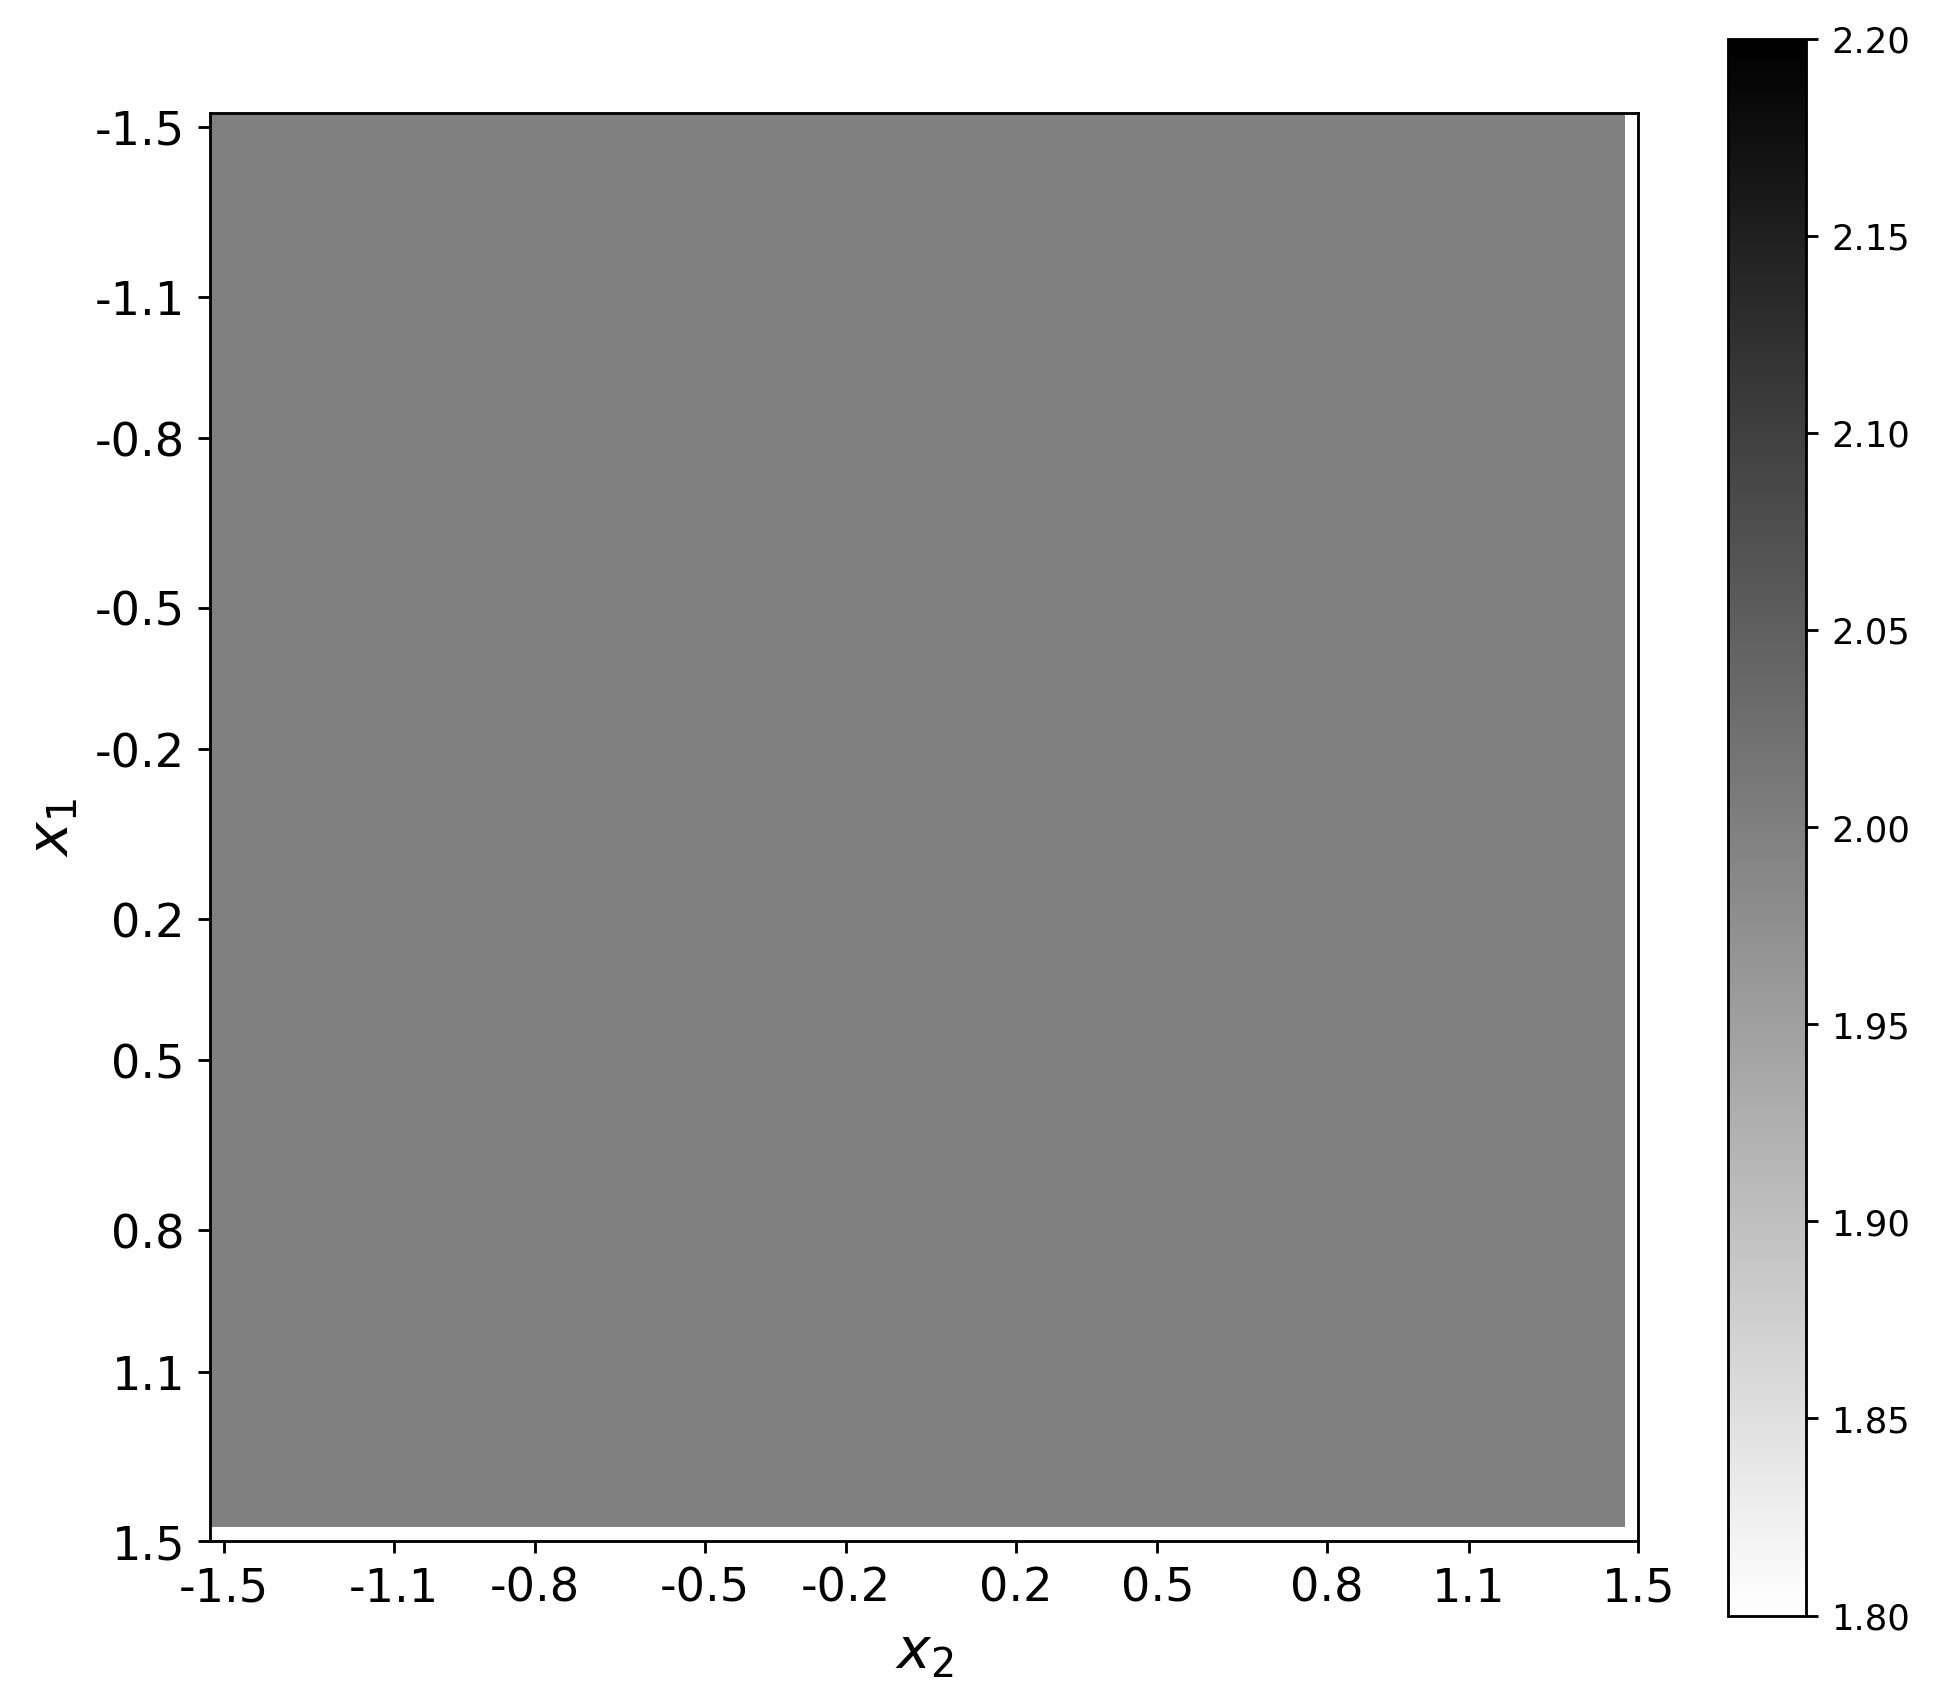

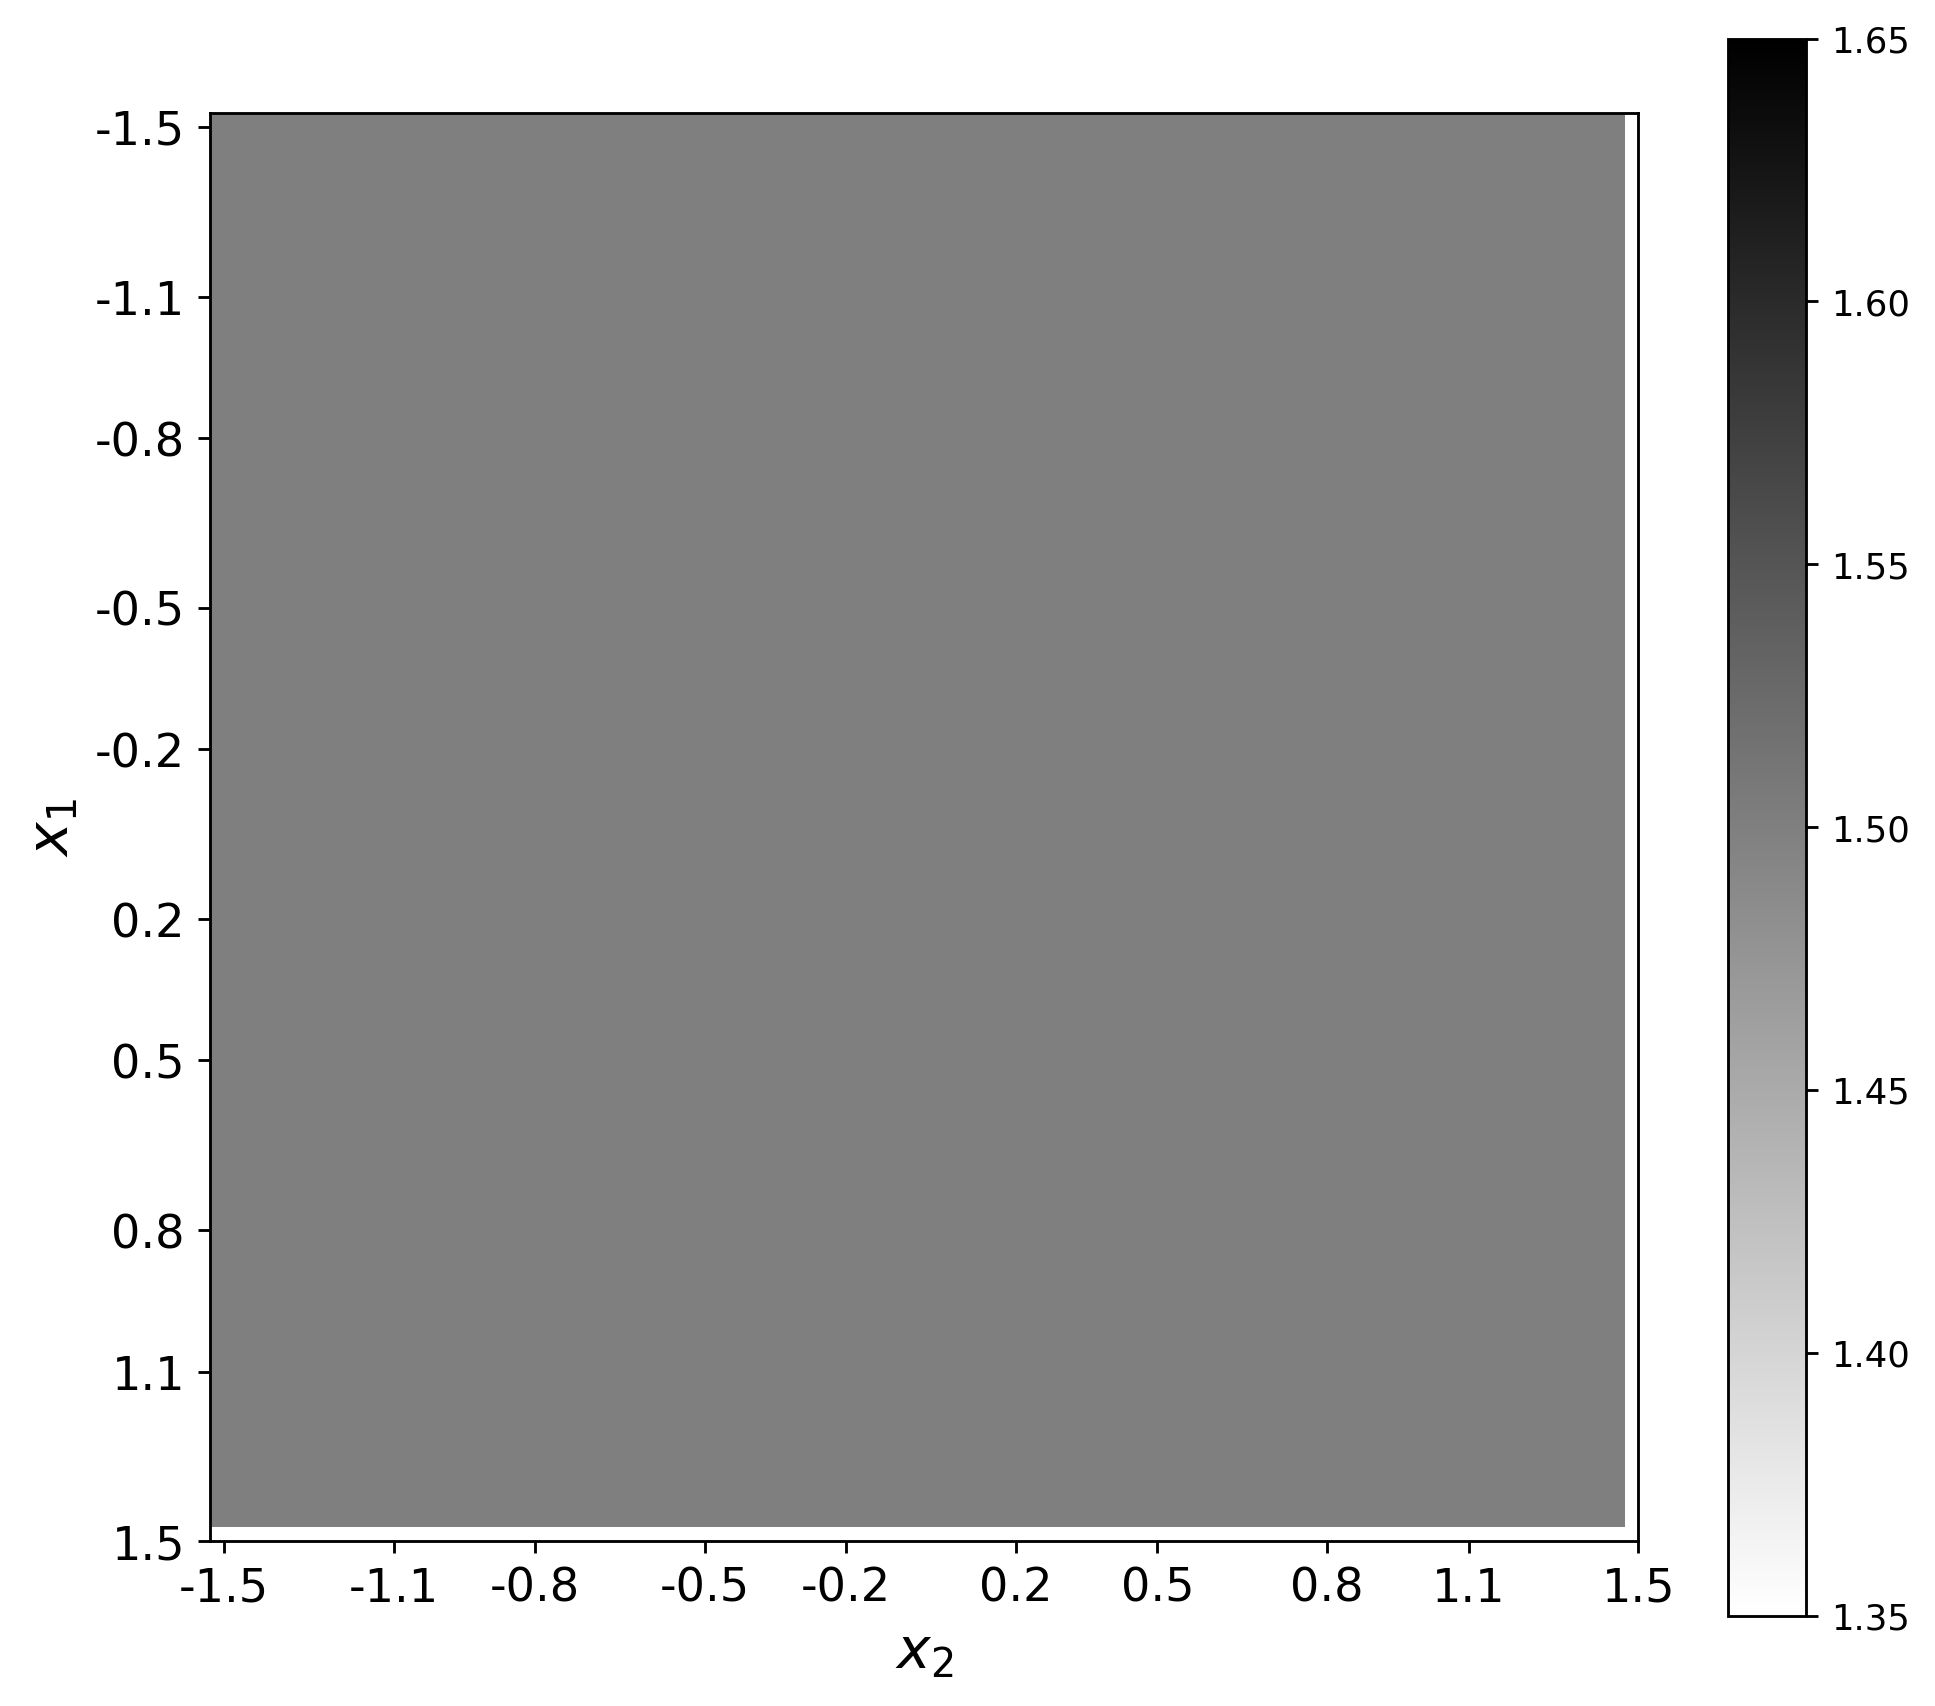

In [158]:
plot_yx(eta.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))
plot_yx(eta.reshape(n_2, n_1, n_3).imag, grid.reshape(n_2, n_1, n_3, 3))

In [159]:
# Внешняя волна, определенная в точках сетки
f_wave = wave(grid, **problem_config)
power_f = np.sum(np.abs(f_wave))/f_wave.size

print("Количество значений на сетке", f_wave.shape)
print("Мощность волны", power_f)

Количество значений на сетке (125000,)
Мощность волны 1.0


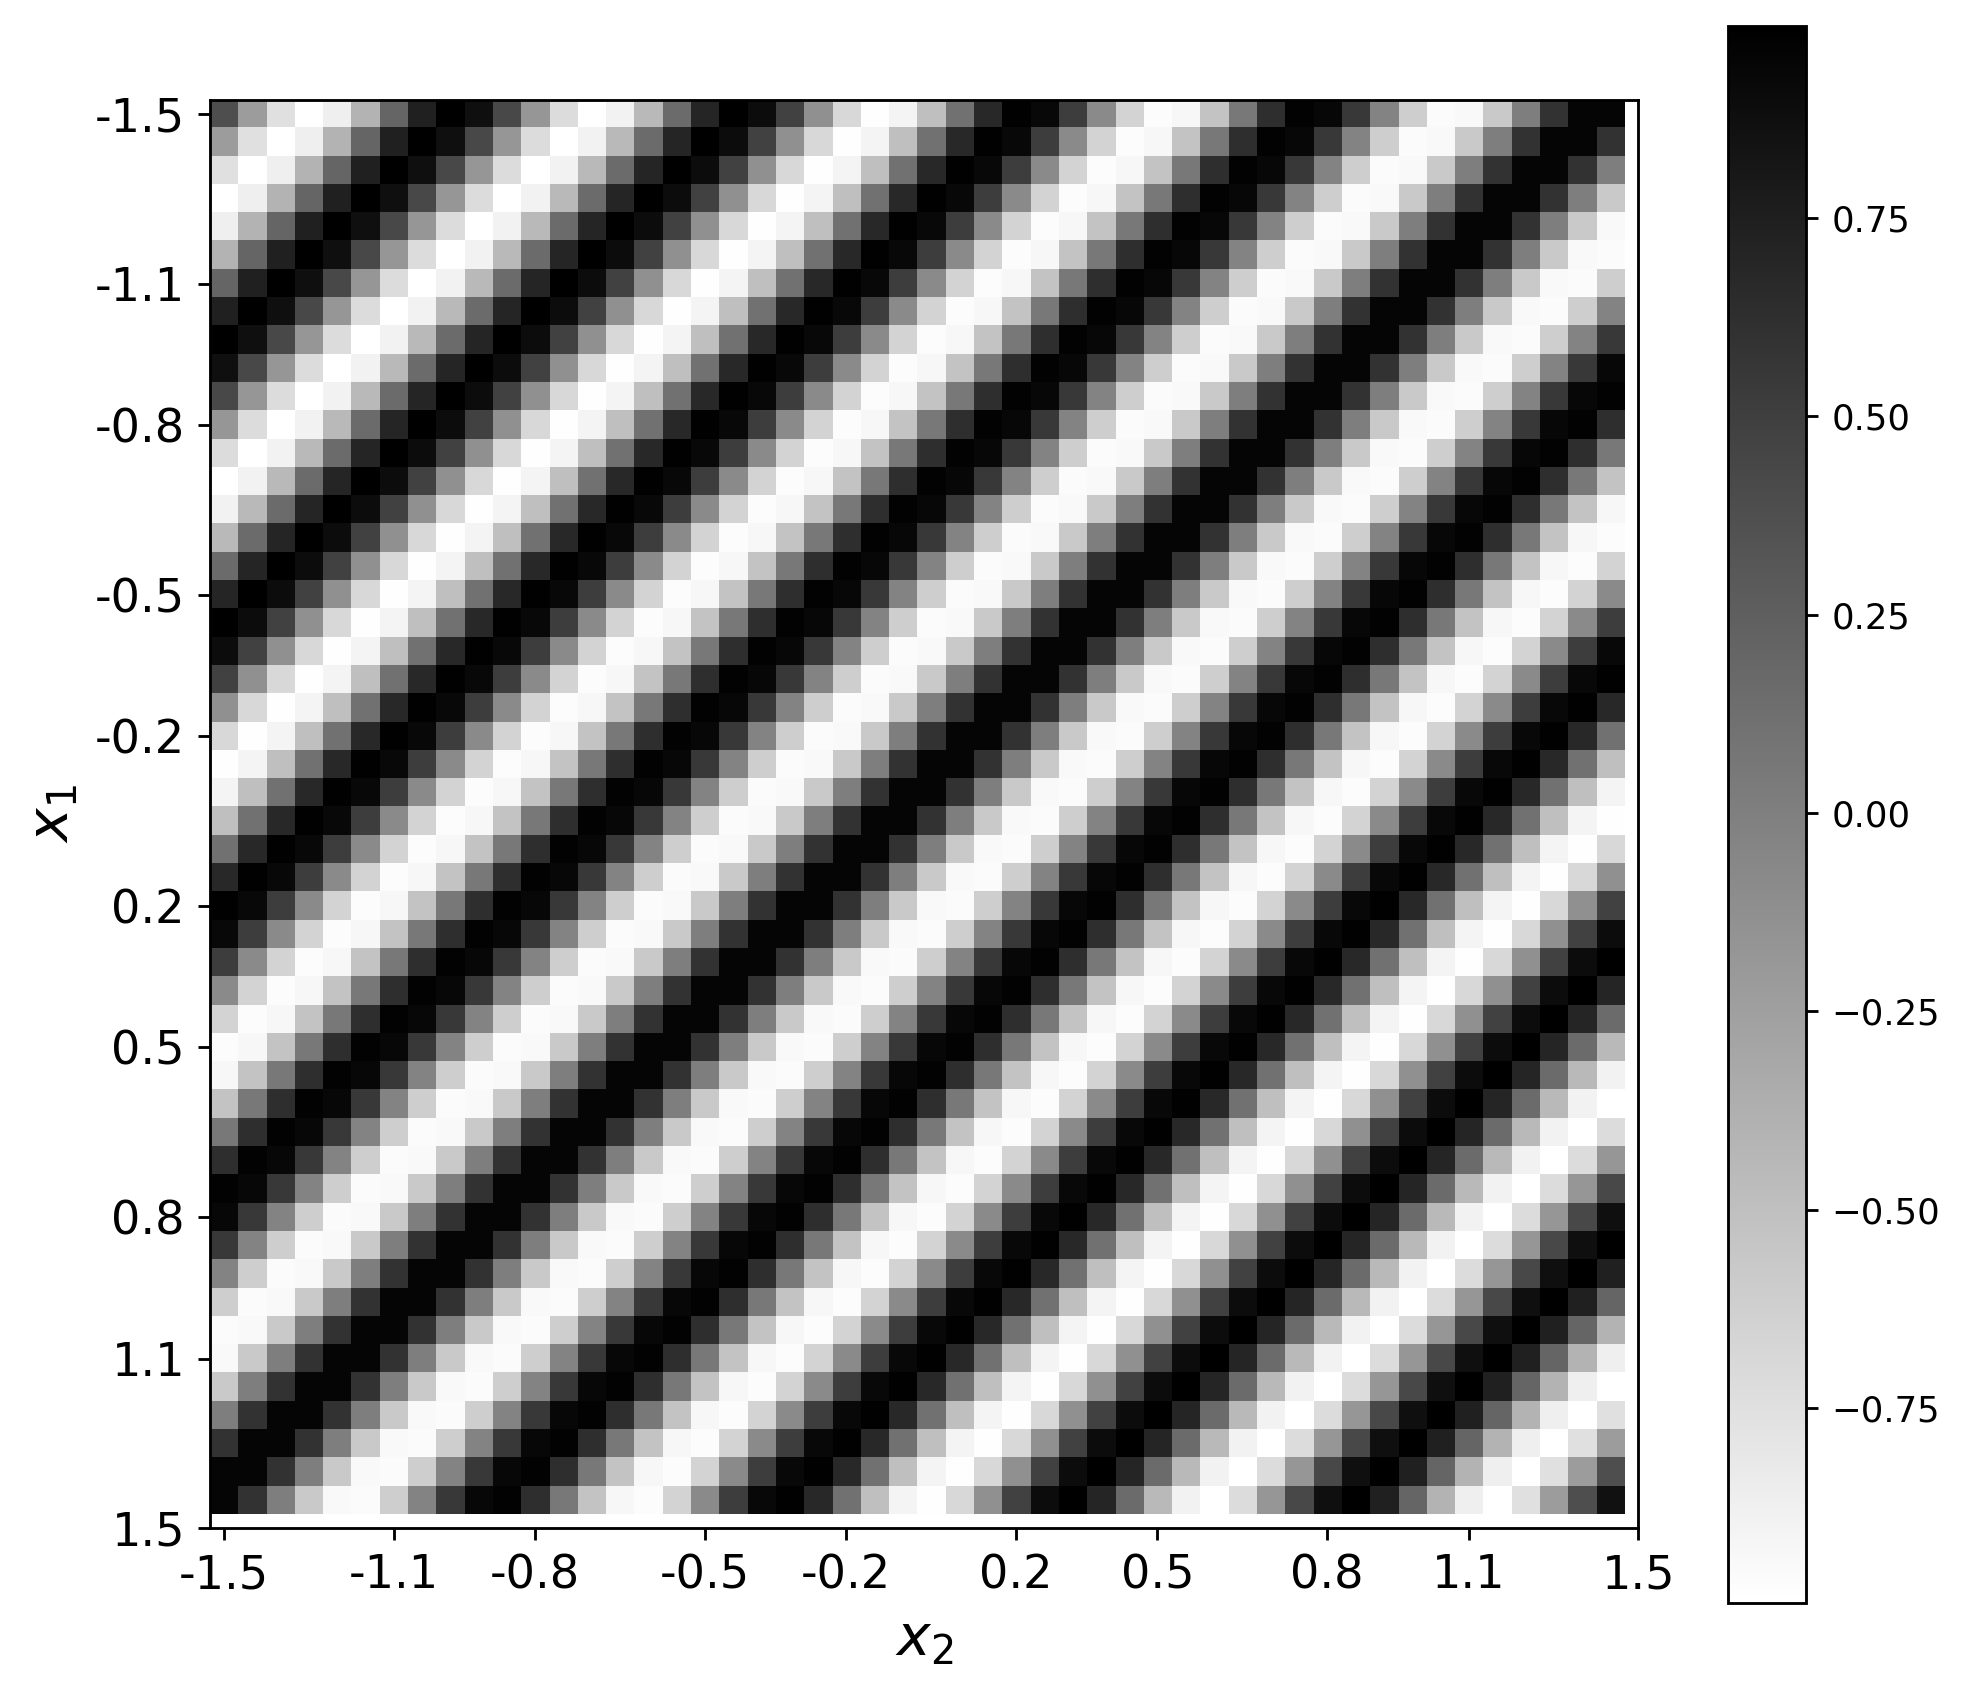

In [160]:
plot_yx(f_wave.reshape(n_2, n_1, n_3).real, grid.reshape(n_1, n_2, n_3, 3))

In [161]:
# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))
dists[0] = 10e-8
dists

array([1.00000000e-07, 6.00000000e-02, 1.20000000e-01, ...,
       5.02390287e+00, 5.05782562e+00, 5.09222937e+00])

In [162]:
# Заполнение первой строки матрицы 
G_array = kernel(dists, **problem_config) * volume
G_array[0] = 0
G_array

array([ 0.00000000e+00+0.00000000e+00j,  1.35025630e-04+2.52662300e-04j,
       -7.95980394e-05+1.19086909e-04j, ...,
       -2.66910237e-06+2.14051534e-06j, -3.39119457e-06+2.21848158e-07j,
       -2.87070515e-06-1.77565133e-06j])

In [163]:
# # Массив ядра интегрального уравнения
# prep_fourier_oper = prep_fftbbtensor(G_array, G_array, n=n_1, m=n_2, k=n_3)
# # Массив комплексно-сопряженных значений ядра интегрального уравнения
# prep_conj_oper = prep_fftbbtensor(np.conj(G_array), np.conj(G_array), n_1, n_2, n_3)

In [164]:
# Умножение внешней волны на ядро оператора
u0_array = -1.0 * fast_bbtmv_mul(G_array.reshape(n_2, n_1, n_3), 
                          G_array.reshape(n_2, n_1, n_3), 
                          f_wave.reshape(n_2, n_1, n_3), 
                          n_2, n_1, n_3).reshape(-1, )

In [165]:
np.sum(np.abs(u0_array))/u0_array.size

0.03638097453003648

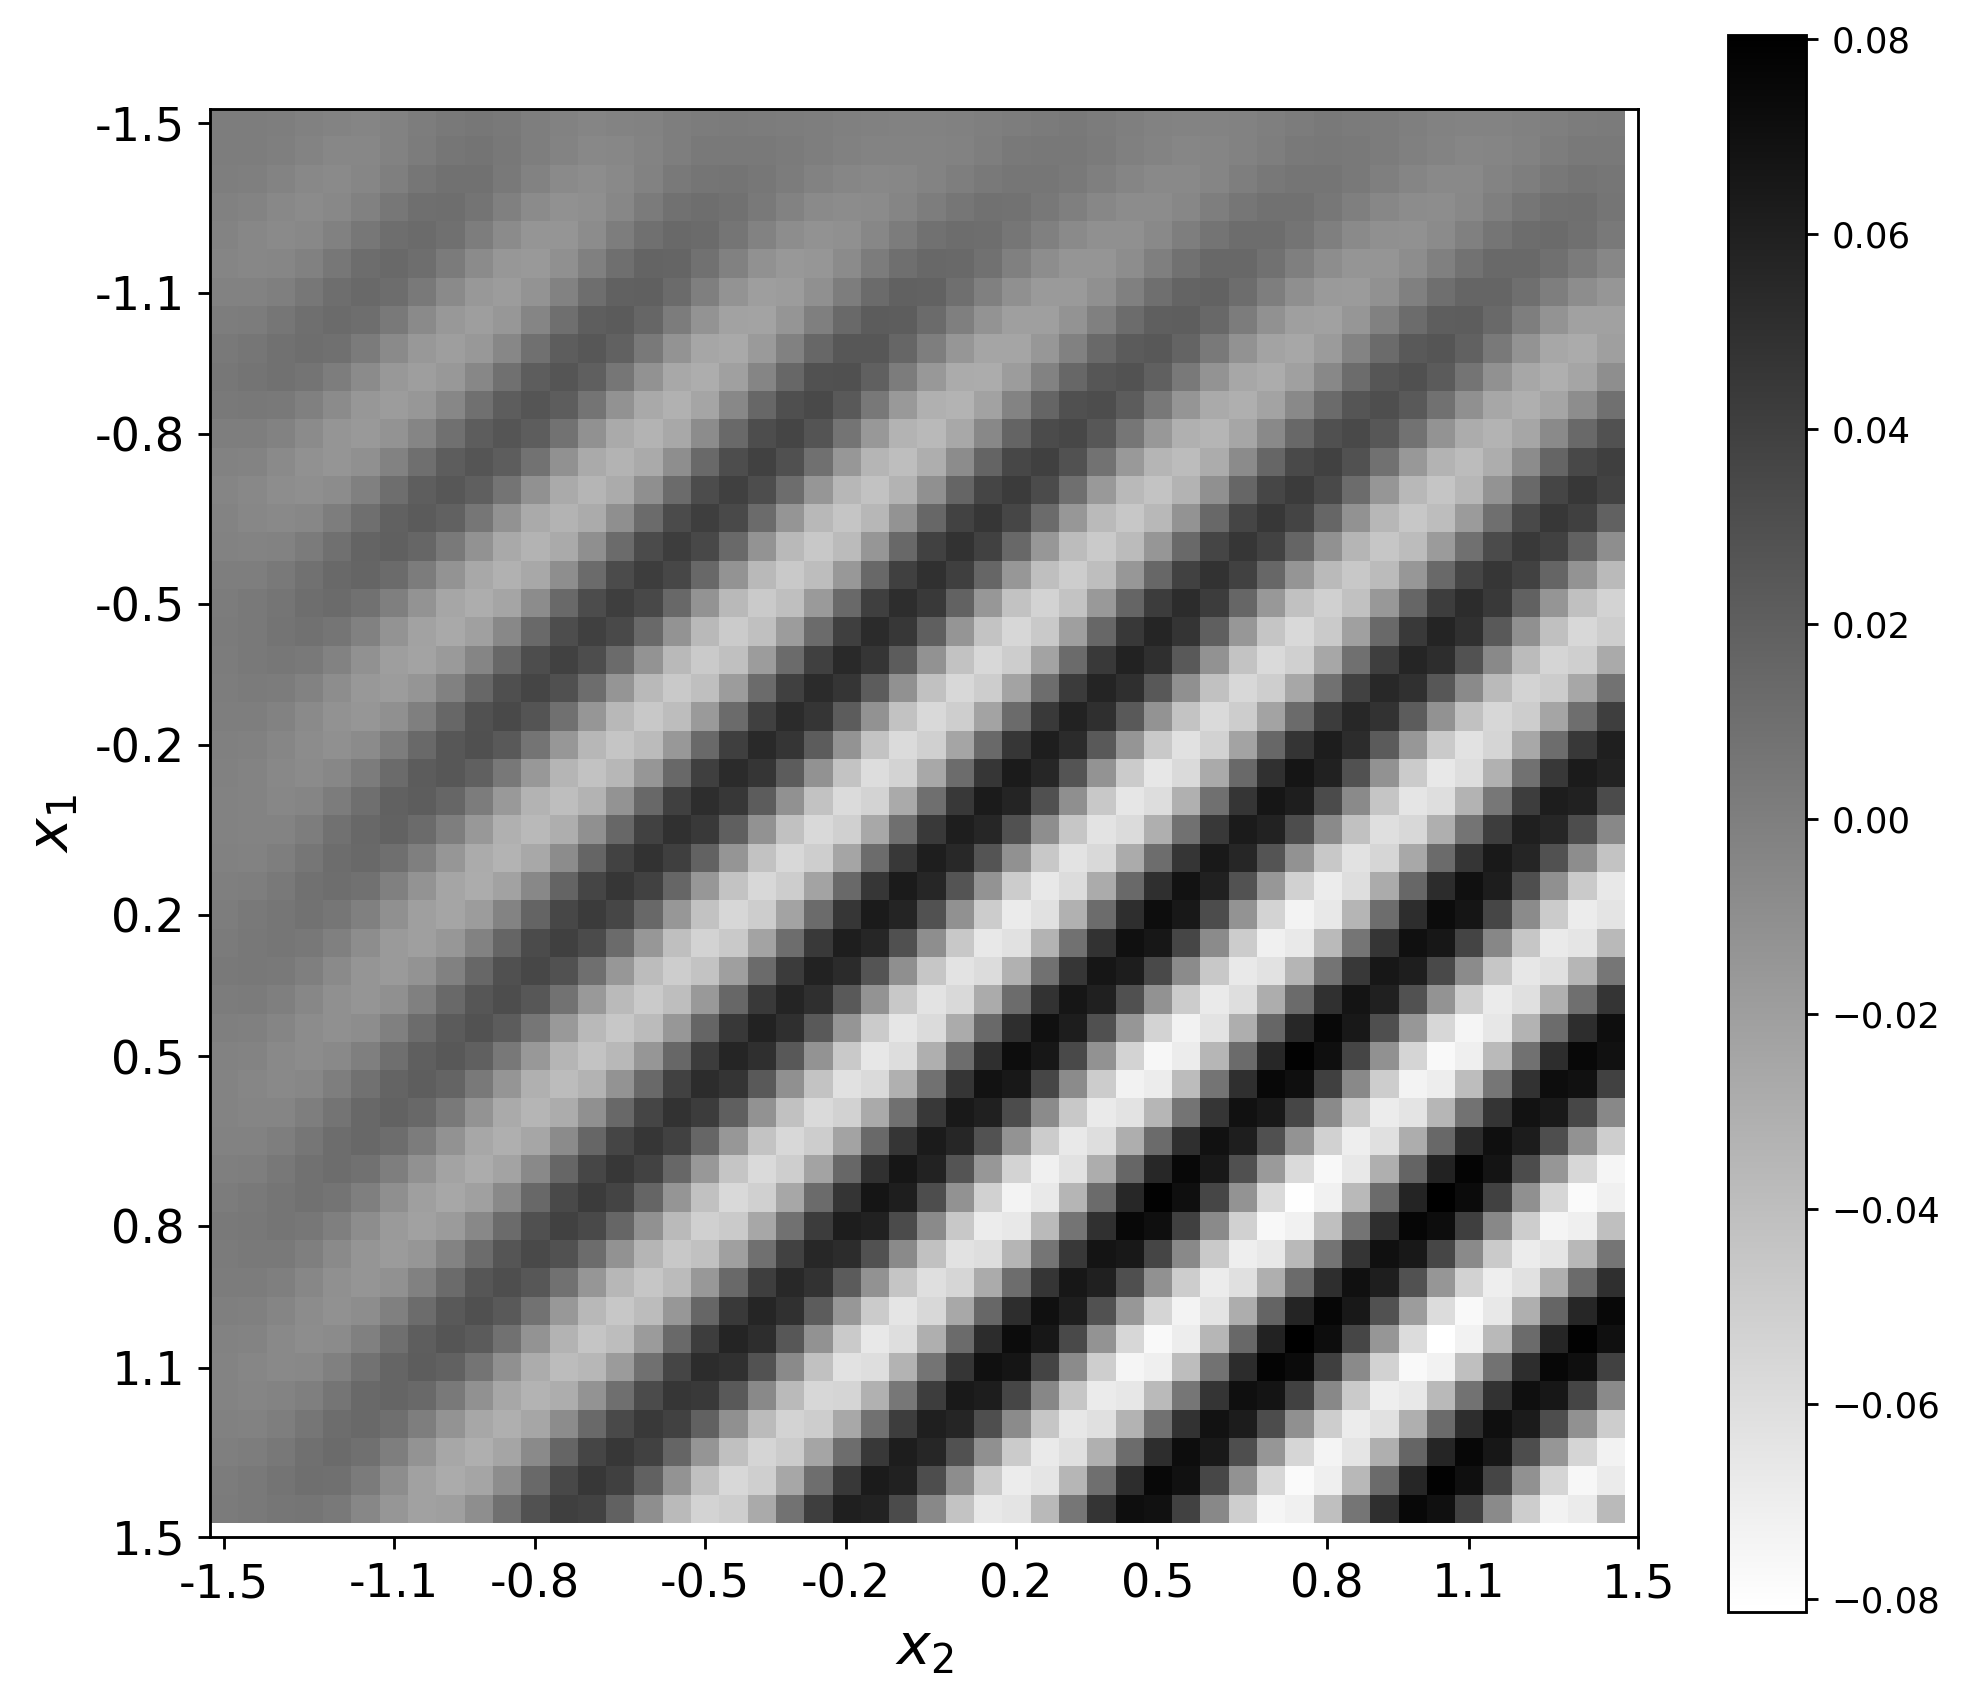

In [166]:
plot_yx(u0_array.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))

In [167]:
import timeit

In [169]:
# result_BICGStab, iters_BICGStab, accuracy_iters_BICGStab, resid_iters_BICGStab = \
# BiCGStab_nu(matrix_A=prep_fourier_oper, vector_f=f_wave, vector_nu=eta - 1.0, vector_u0=None, n=n_1, m=n_2, k=n_3)
start_time = timeit.default_timer()
result_BICGStab, iters_BICGStab, eps_BICGStab, resid_BICGStab = \
bicgstab(G_array, 
         u0_array, 
         (eta-1),
         k_wave,
         vector_u0=None, 
         n_1=n_2, n_2=n_1, n_3=n_3, 
         tol=1e-7, max_iter=150)
elapsed = timeit.default_timer() - start_time
print(elapsed)

Итерация №1: Умножений М-В L = 5, Умножений В-В V = 4, Критерий останова eps = 0.05732382886978335
Итерация №2: Умножений М-В L = 7, Умножений В-В V = 6, Критерий останова eps = 0.0813317351255261
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 8, Критерий останова eps = 0.055488509038053274
Итерация №4: Умножений М-В L = 11, Умножений В-В V = 10, Критерий останова eps = 0.04953557607052763
Итерация №5: Умножений М-В L = 13, Умножений В-В V = 12, Критерий останова eps = 0.0279843674086294
Итерация №6: Умножений М-В L = 15, Умножений В-В V = 14, Критерий останова eps = 0.035358481407303584
Итерация №7: Умножений М-В L = 17, Умножений В-В V = 16, Критерий останова eps = 0.024482999642490958
Итерация №8: Умножений М-В L = 19, Умножений В-В V = 18, Критерий останова eps = 0.005238046530410347
Итерация №9: Умножений М-В L = 21, Умножений В-В V = 20, Критерий останова eps = 0.0073591519153261495
Итерация №10: Умножений М-В L = 23, Умножений В-В V = 22, Критерий останова eps = 0.008146844

Итерация №80: Умножений М-В L = 163, Умножений В-В V = 162, Критерий останова eps = 1.3115302868788452e-06
Итерация №81: Умножений М-В L = 165, Умножений В-В V = 164, Критерий останова eps = 3.3989409881597314e-05
Итерация №82: Умножений М-В L = 167, Умножений В-В V = 166, Критерий останова eps = 3.249405696984969e-05
Итерация №83: Умножений М-В L = 169, Умножений В-В V = 168, Критерий останова eps = 5.461747488871107e-06
Итерация №84: Умножений М-В L = 171, Умножений В-В V = 170, Критерий останова eps = 1.2164918133076328e-06
Итерация №85: Умножений М-В L = 173, Умножений В-В V = 172, Критерий останова eps = 1.2164317990775202e-06
Итерация №86: Умножений М-В L = 175, Умножений В-В V = 174, Критерий останова eps = 2.0219207721357125e-06
Итерация №87: Умножений М-В L = 177, Умножений В-В V = 176, Критерий останова eps = 7.558507383185619e-07
Итерация №88: Умножений М-В L = 179, Умножений В-В V = 178, Критерий останова eps = 1.1020582786827484e-06
Итерация №89: Умножений М-В L = 181, Умн

In [93]:
np.sum(np.abs(result_BICGStab))/result_BICGStab.size

0.005295345385453833

In [170]:
start_time = timeit.default_timer()
result_TS, iterations_TS, accuracy_TS, resid_TS = \
TwoStep(G_array, 
        np.conj(G_array), 
        u0_array, 
        (eta-1),
        k_wave,
        z_0=None, 
        n_1=n_2, n_2=n_1, n_3=n_3, 
        rtol=1e-7, max_iter=100)
elapsed = timeit.default_timer() - start_time
print(elapsed)

Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.022471862497269065
Итерация №2: Умножений М-В L = 6, Умножений В-В V = 8, Критерий останова eps = 0.011275802479448128
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 12, Критерий останова eps = 0.006735541730929455
Итерация №4: Умножений М-В L = 12, Умножений В-В V = 16, Критерий останова eps = 0.0047370557745512526
Итерация №5: Умножений М-В L = 15, Умножений В-В V = 20, Критерий останова eps = 0.003608754076695837
Итерация №6: Умножений М-В L = 18, Умножений В-В V = 24, Критерий останова eps = 0.002704868278813497
Итерация №7: Умножений М-В L = 21, Умножений В-В V = 28, Критерий останова eps = 0.0021878197217190145
Итерация №8: Умножений М-В L = 24, Умножений В-В V = 32, Критерий останова eps = 0.0018459331718458508
Итерация №9: Умножений М-В L = 27, Умножений В-В V = 36, Критерий останова eps = 0.001441443532431432
Итерация №10: Умножений М-В L = 30, Умножений В-В V = 40, Критерий останова eps = 0.

Итерация №79: Умножений М-В L = 237, Умножений В-В V = 316, Критерий останова eps = 5.234103213571828e-05
Итерация №80: Умножений М-В L = 240, Умножений В-В V = 320, Критерий останова eps = 6.126571454546267e-05
Итерация №81: Умножений М-В L = 243, Умножений В-В V = 324, Критерий останова eps = 5.706421777209055e-05
Итерация №82: Умножений М-В L = 246, Умножений В-В V = 328, Критерий останова eps = 5.153270595364592e-05
Итерация №83: Умножений М-В L = 249, Умножений В-В V = 332, Критерий останова eps = 5.936348104051088e-05
Итерация №84: Умножений М-В L = 252, Умножений В-В V = 336, Критерий останова eps = 4.305328653777647e-05
Итерация №85: Умножений М-В L = 255, Умножений В-В V = 340, Критерий останова eps = 4.7229167753148156e-05
Итерация №86: Умножений М-В L = 258, Умножений В-В V = 344, Критерий останова eps = 3.287079147615609e-05
Итерация №87: Умножений М-В L = 261, Умножений В-В V = 348, Критерий останова eps = 4.126535341567404e-05
Итерация №88: Умножений М-В L = 264, Умножени

In [171]:
np.sum(np.abs(result_TS))/result_TS.size

0.0016676283436573428

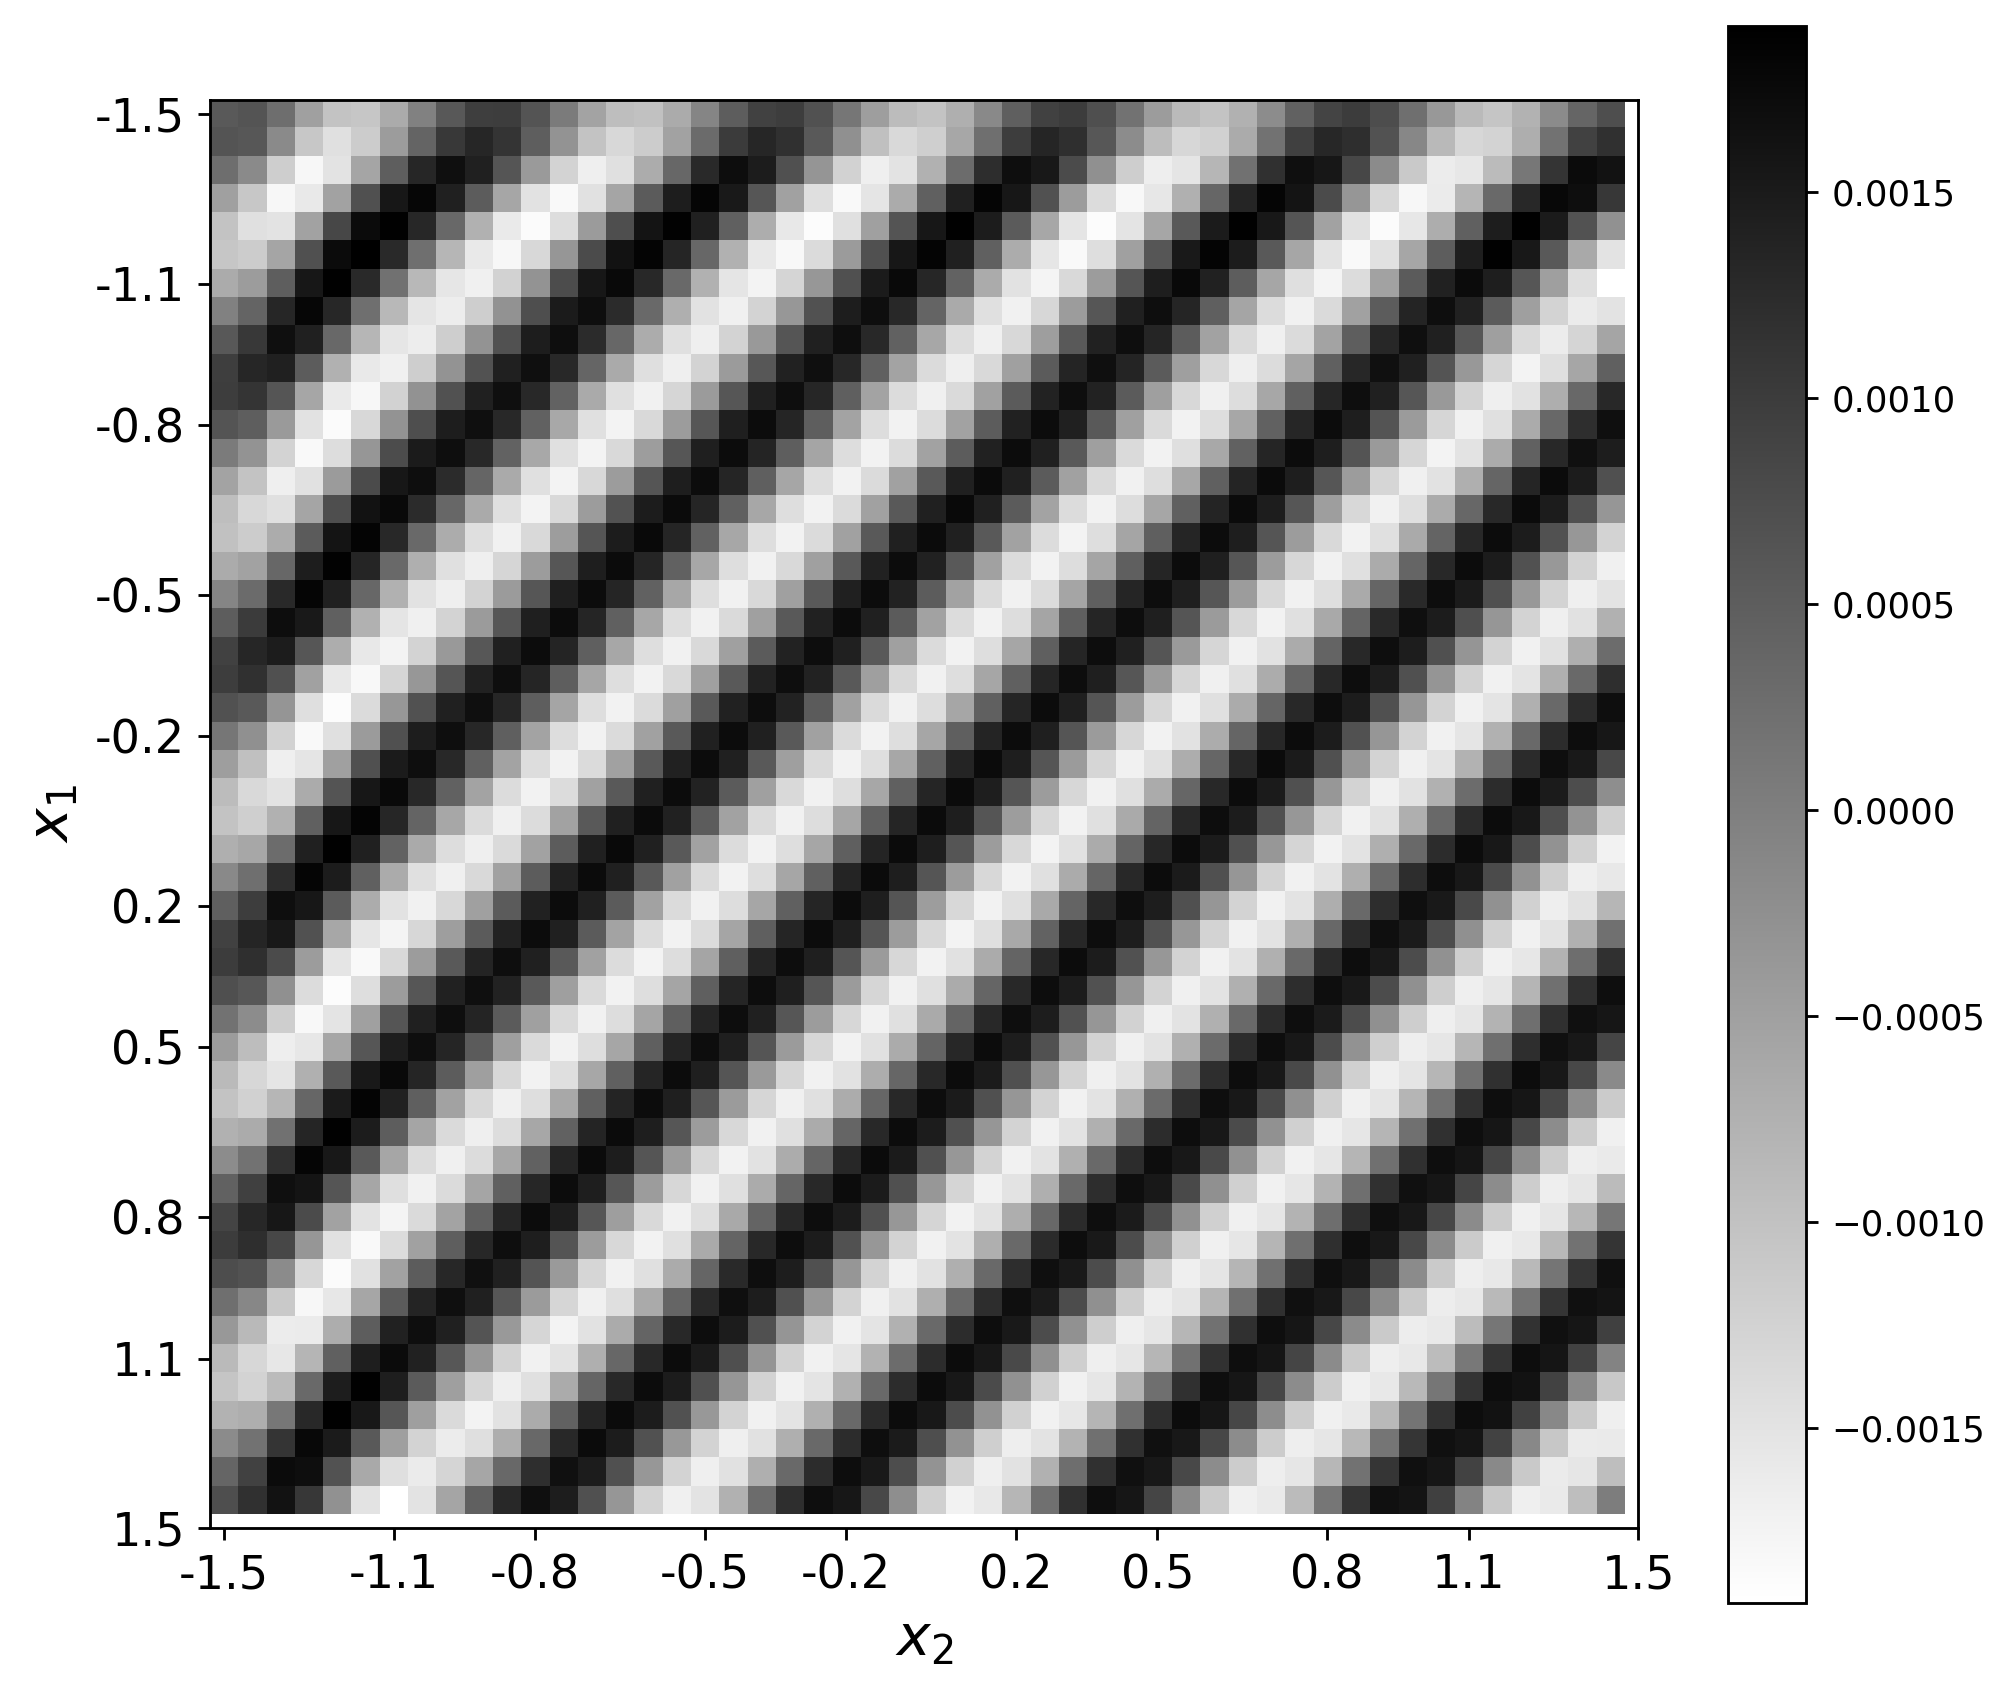

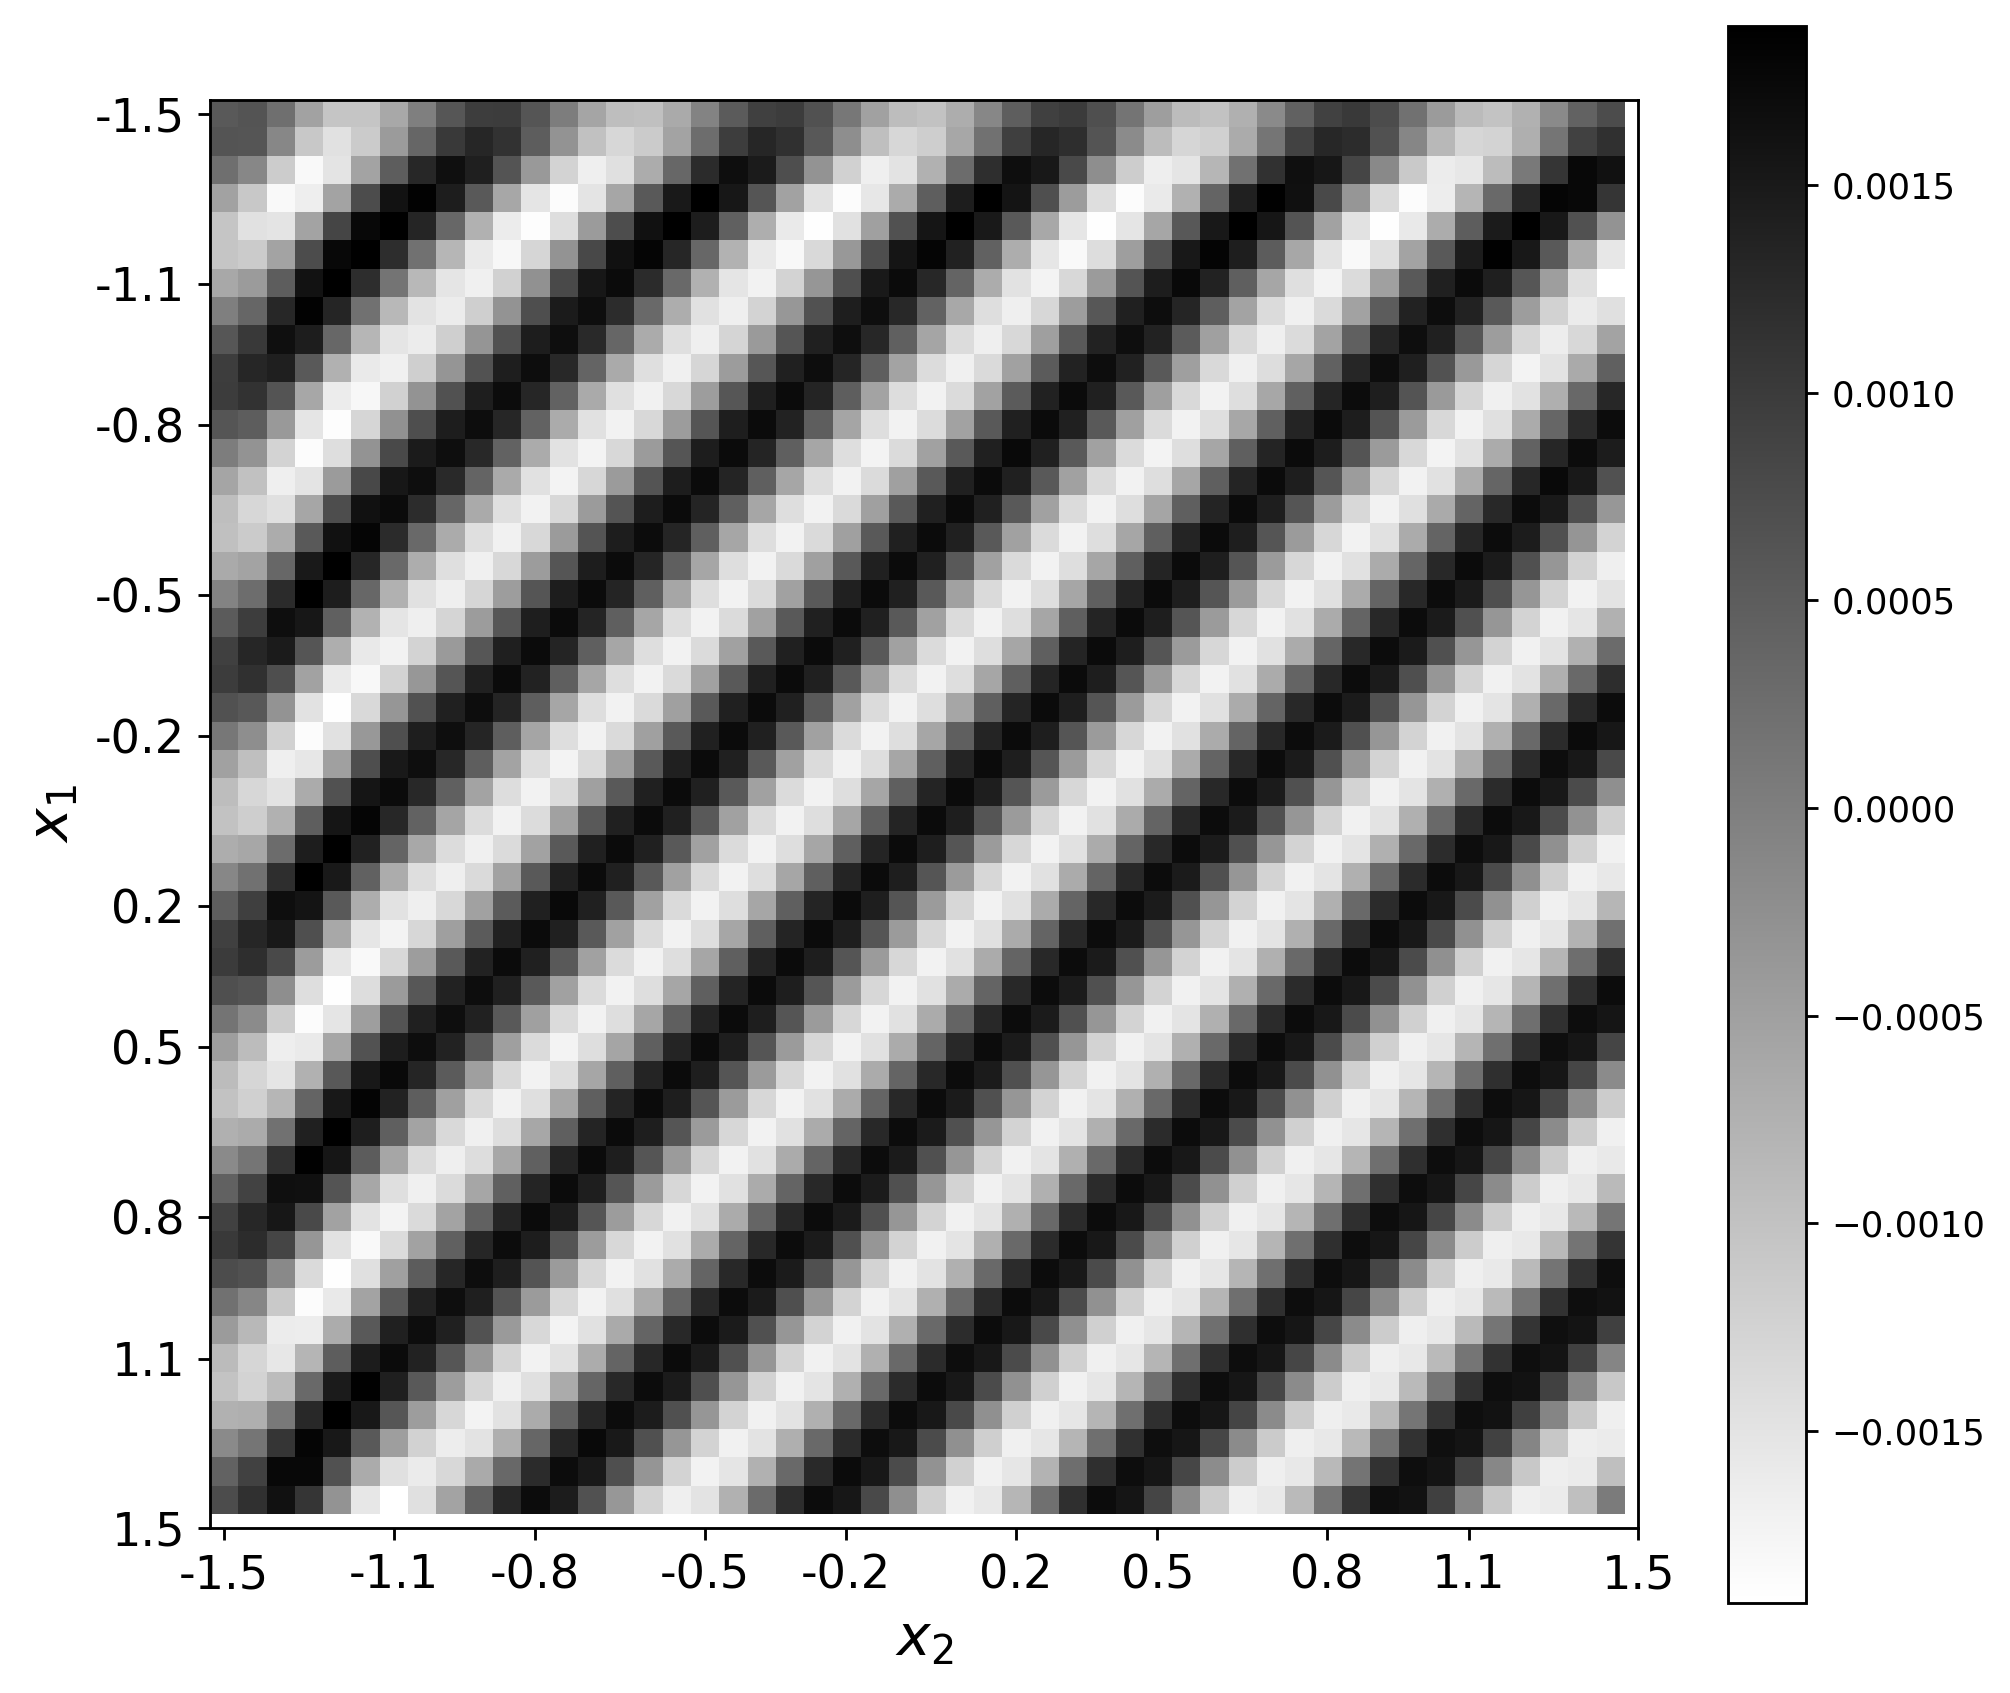

In [172]:
plot_yx(result_TS.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))
plot_yx(result_BICGStab.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))

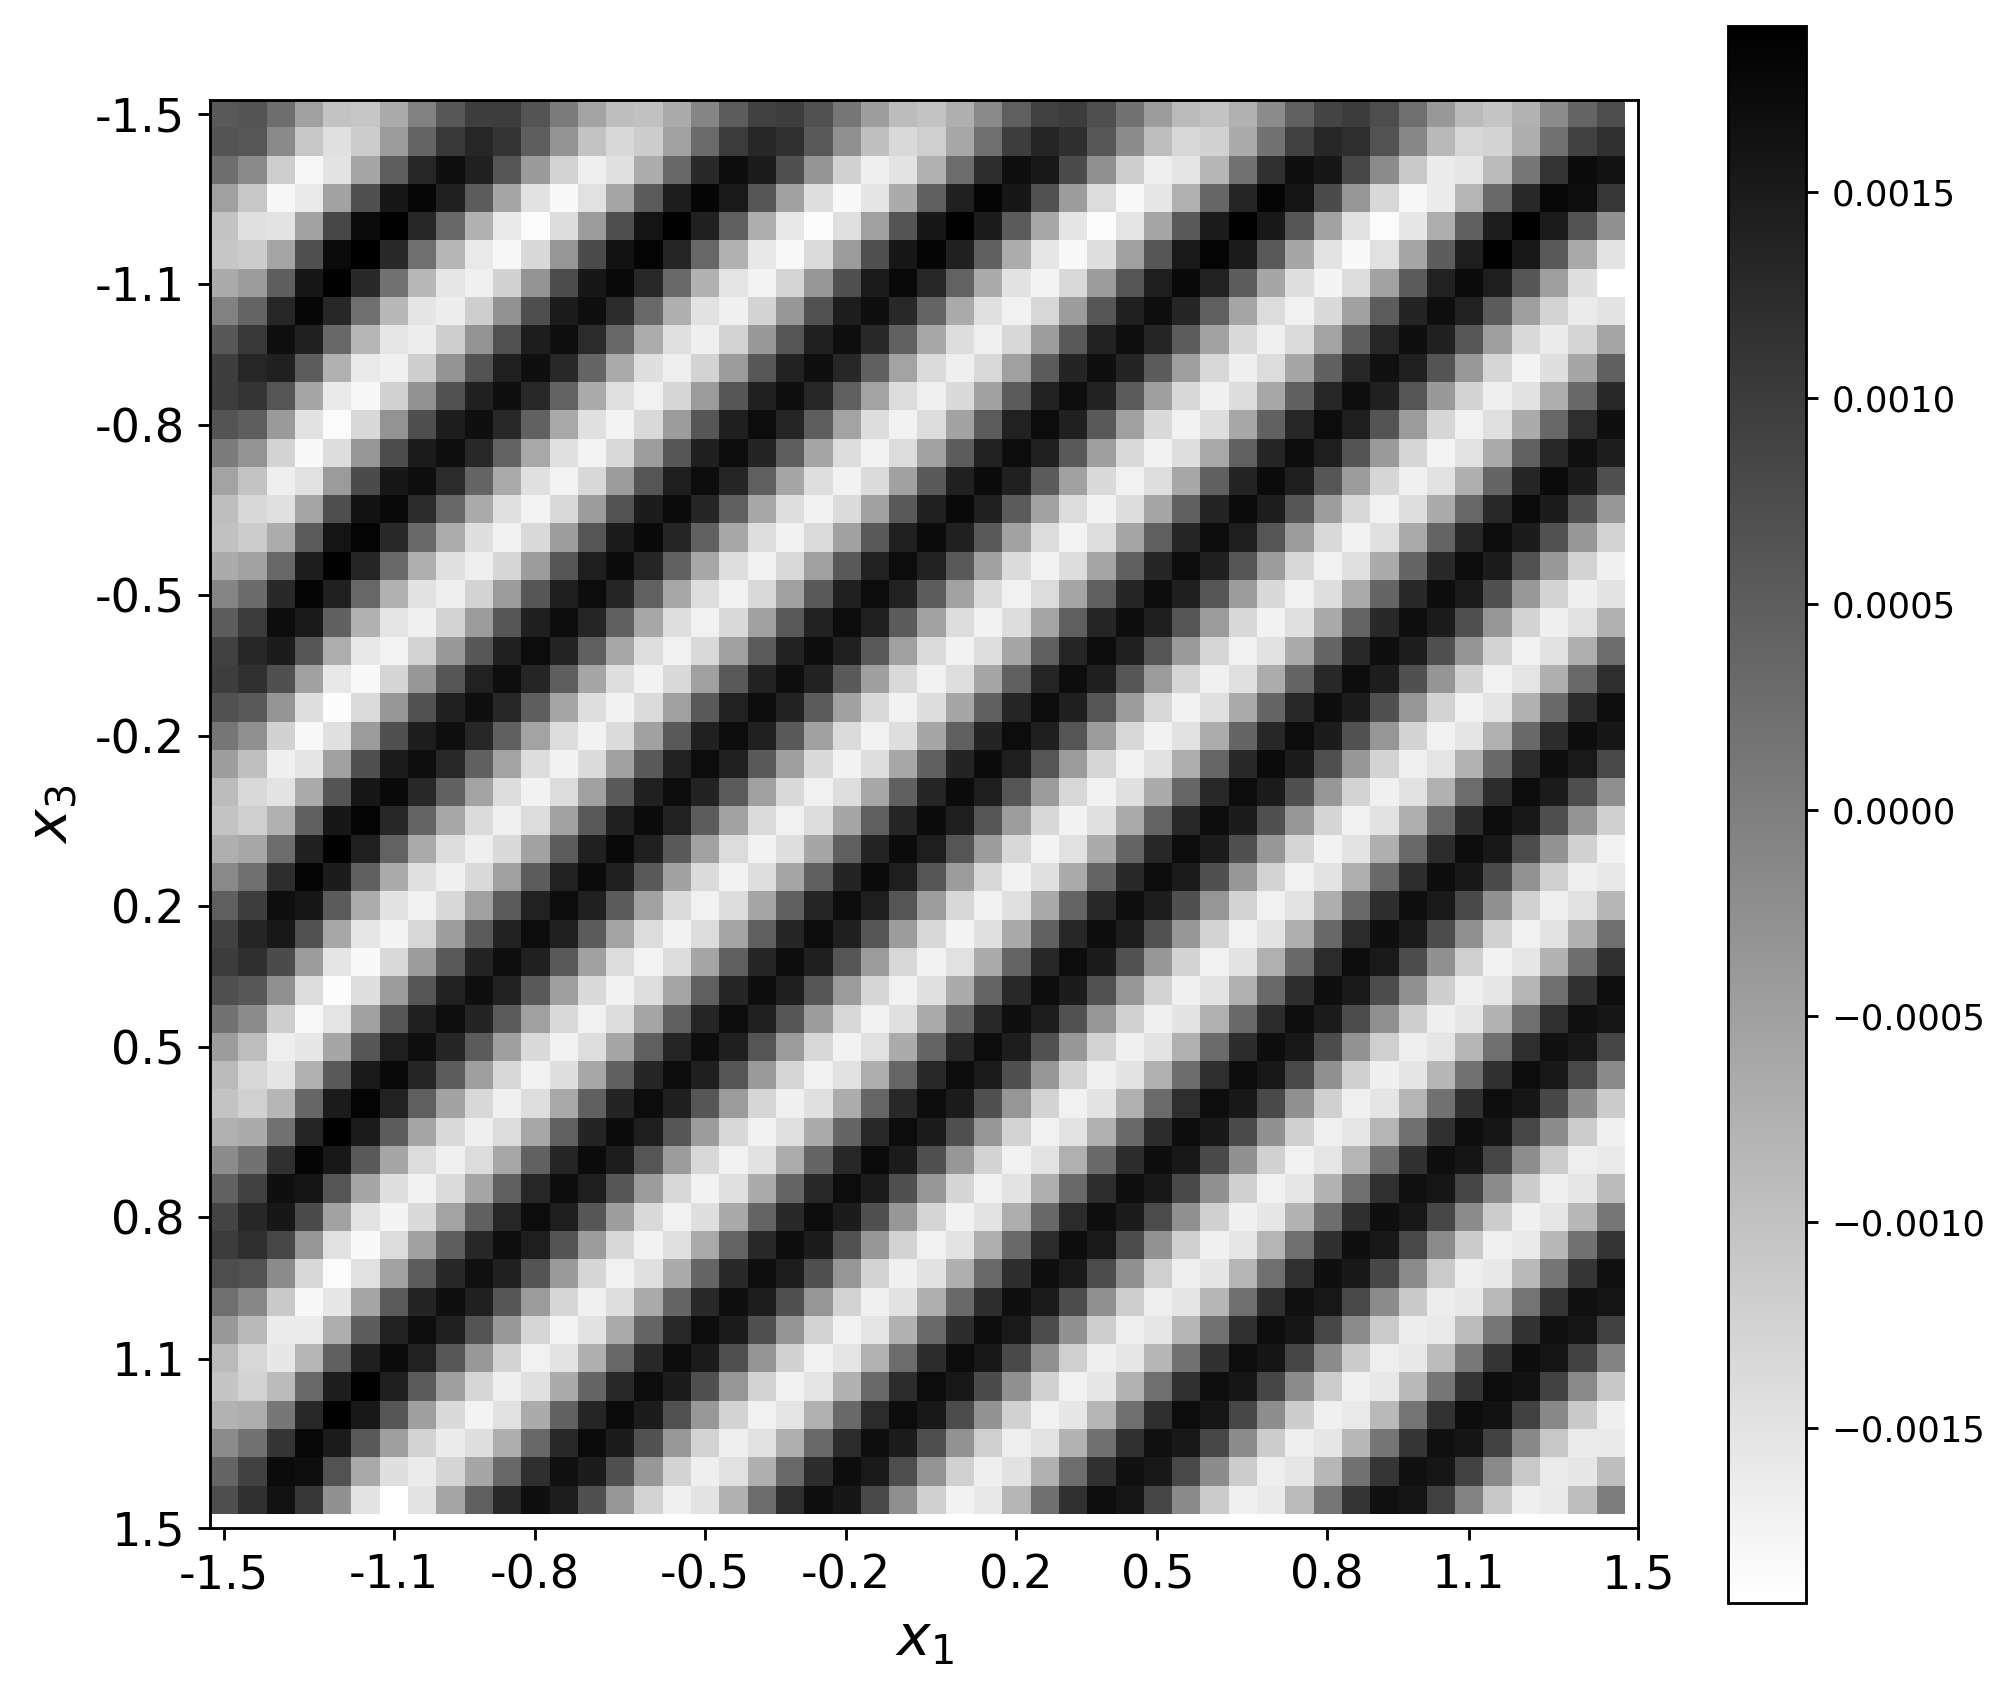

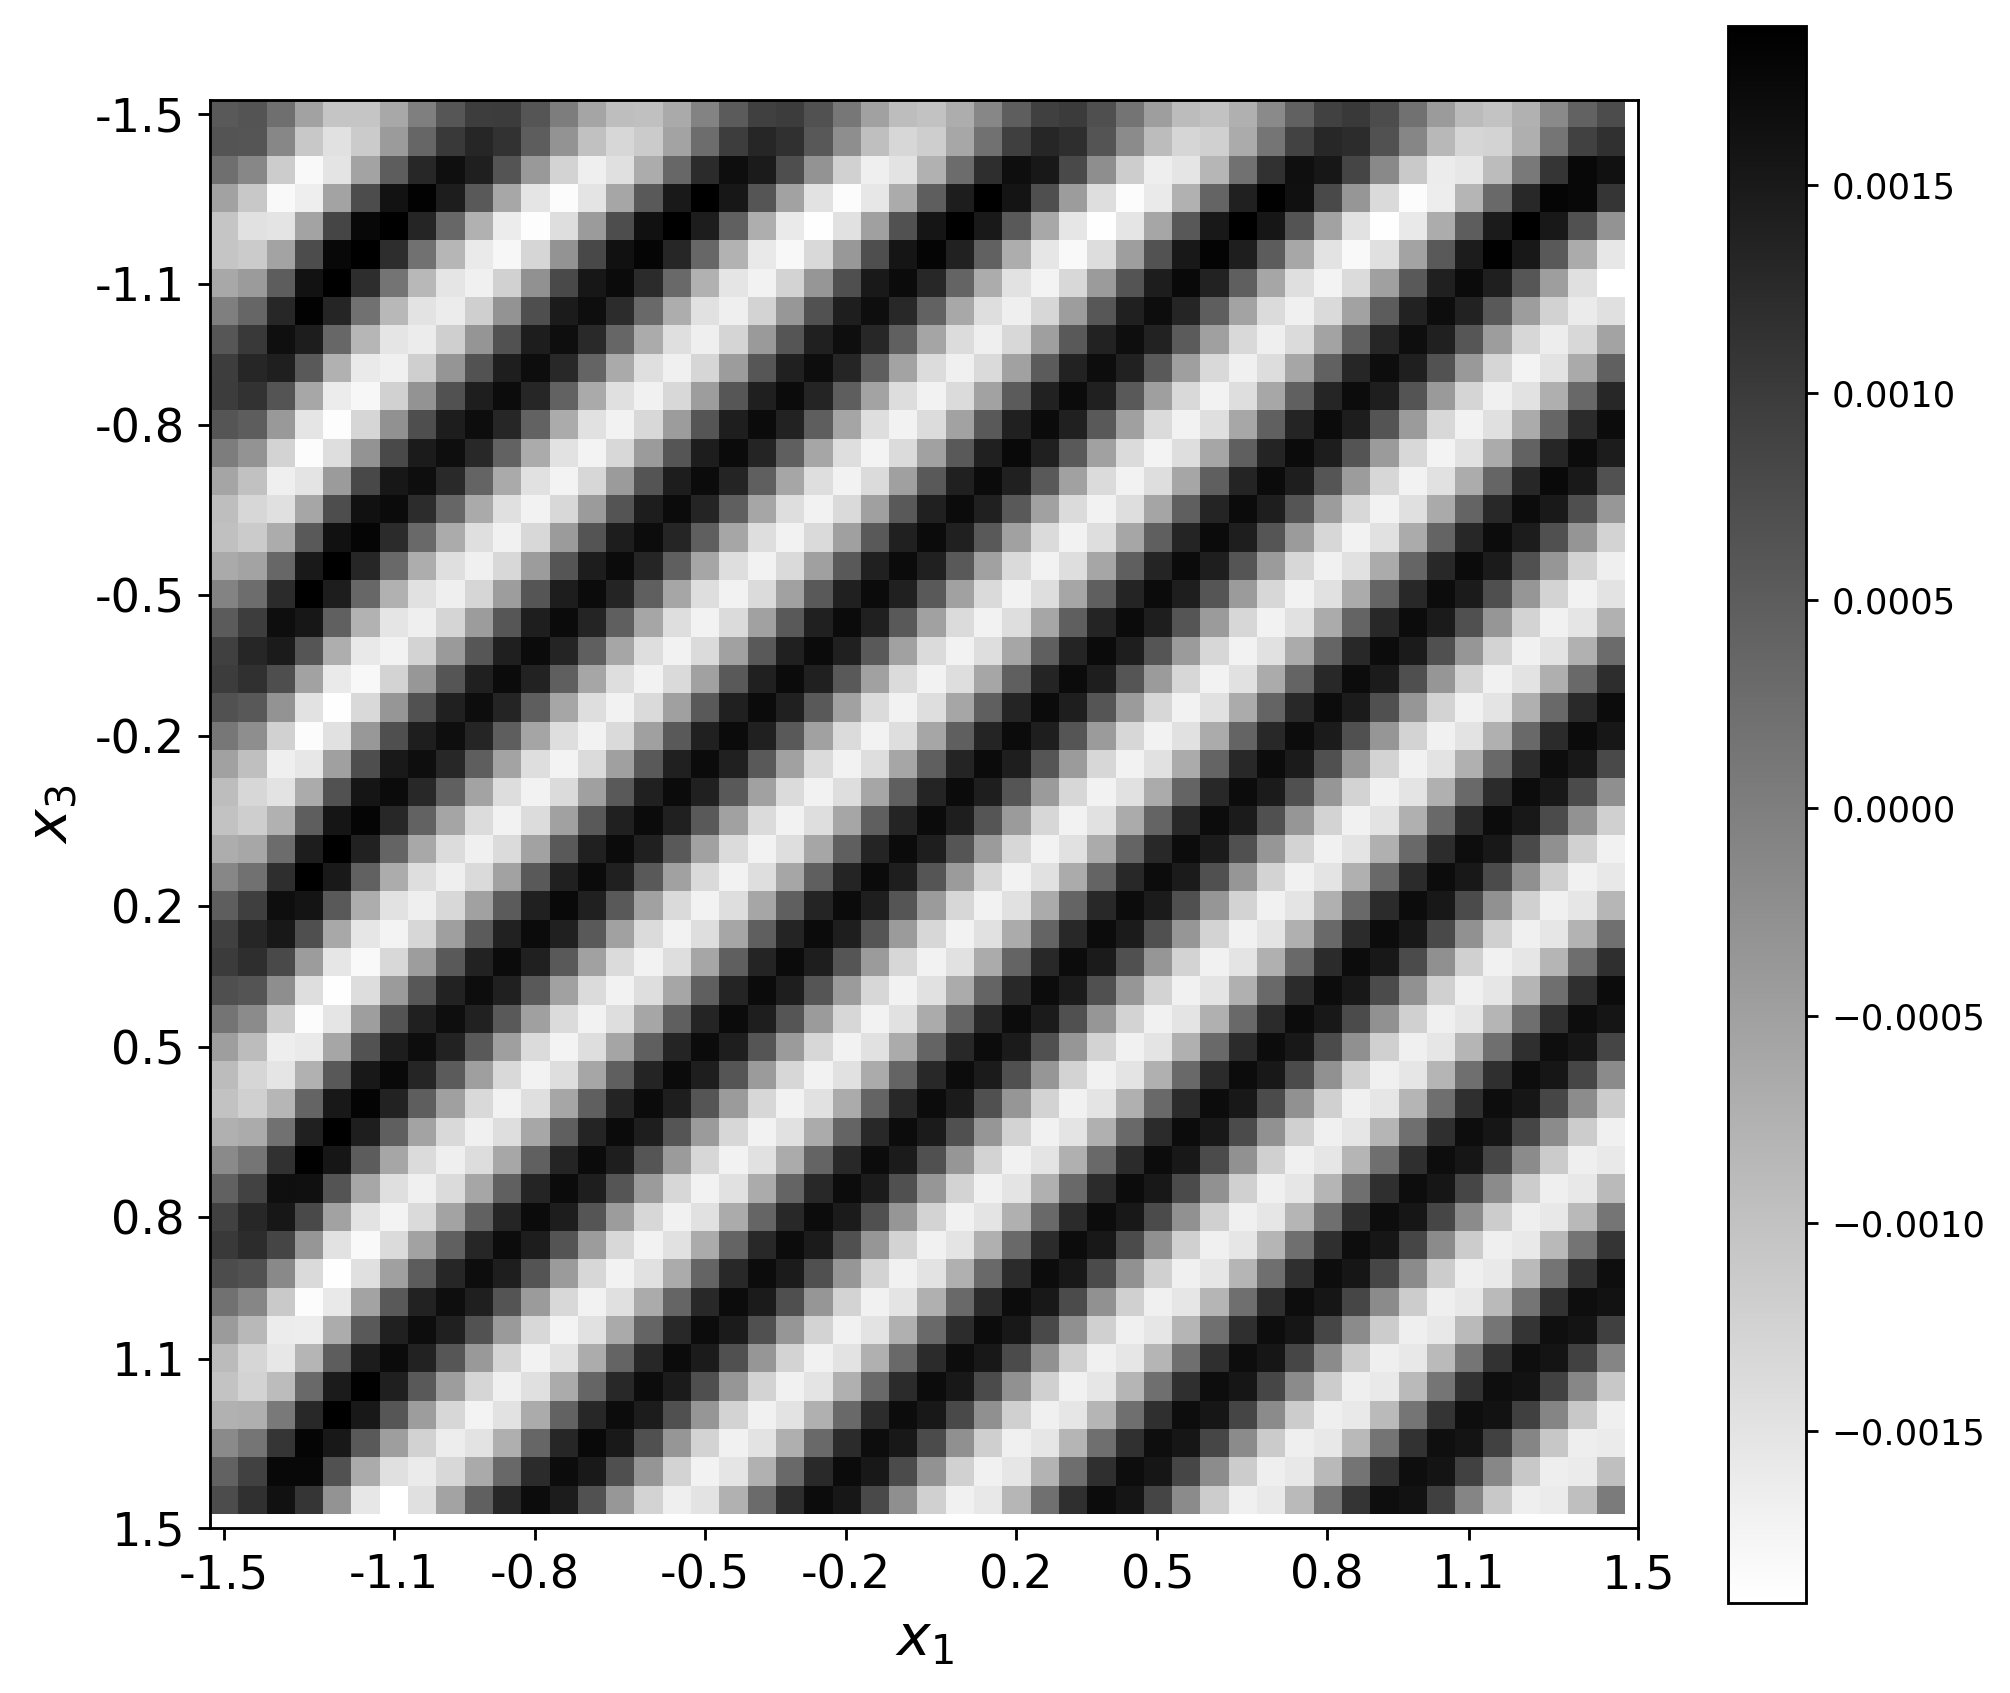

In [173]:
plot_xz(result_TS.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))
plot_xz(result_BICGStab.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))

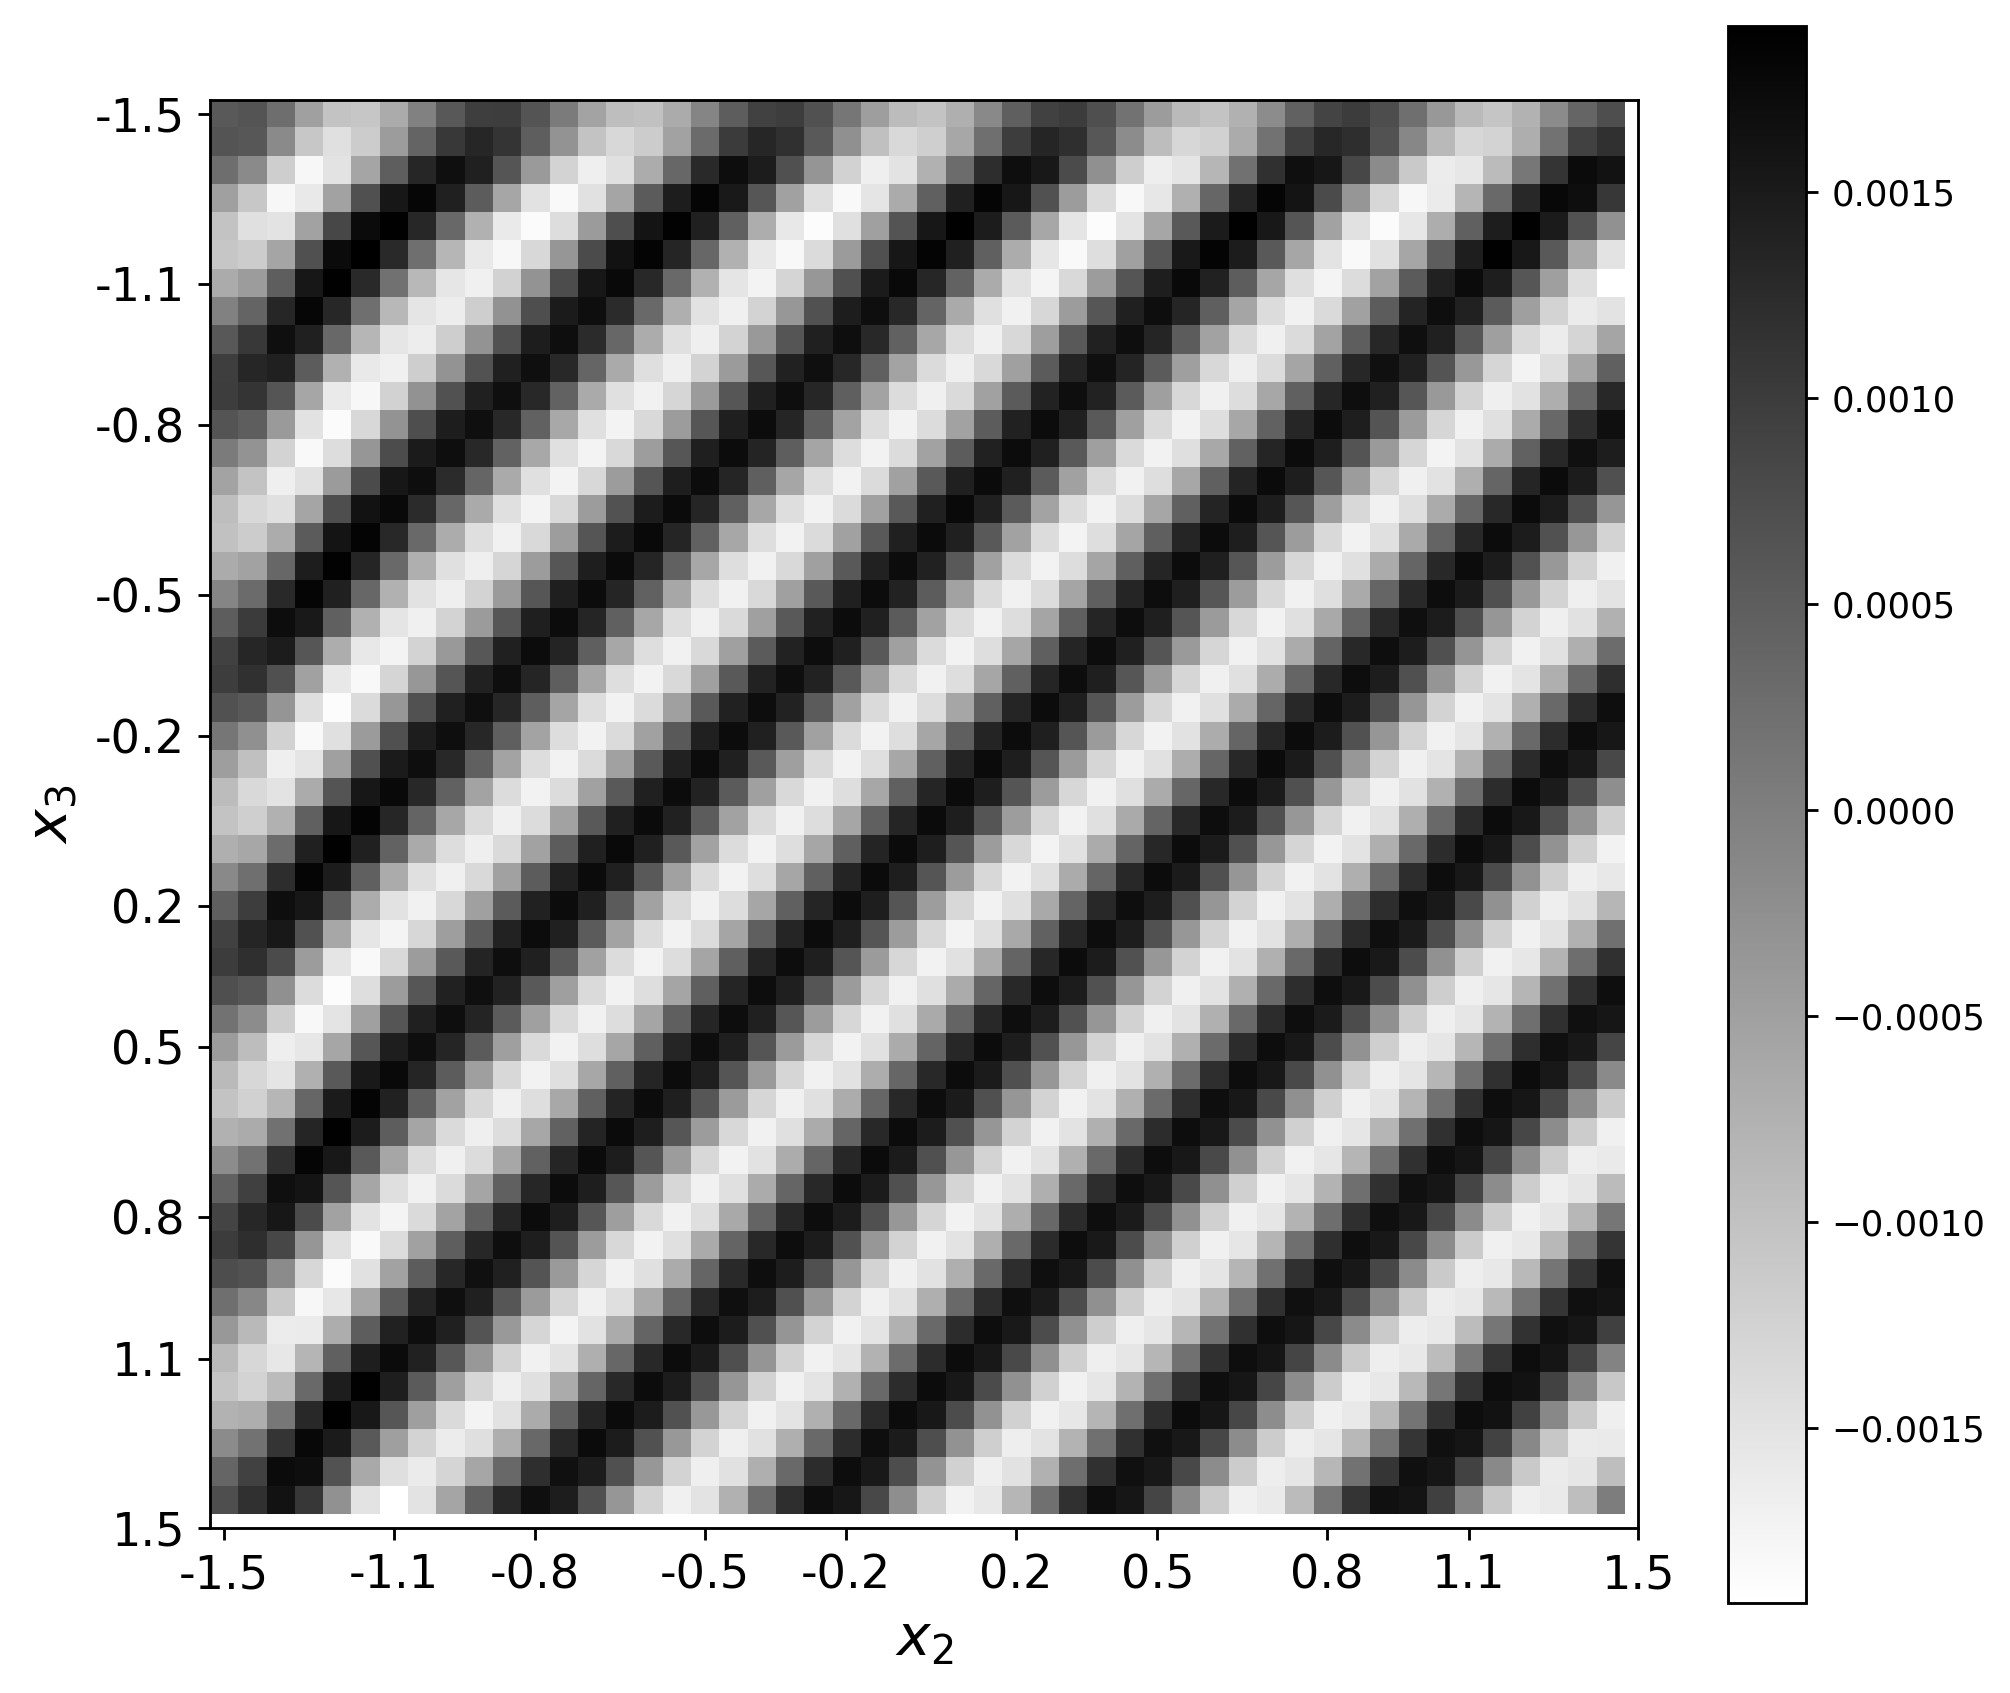

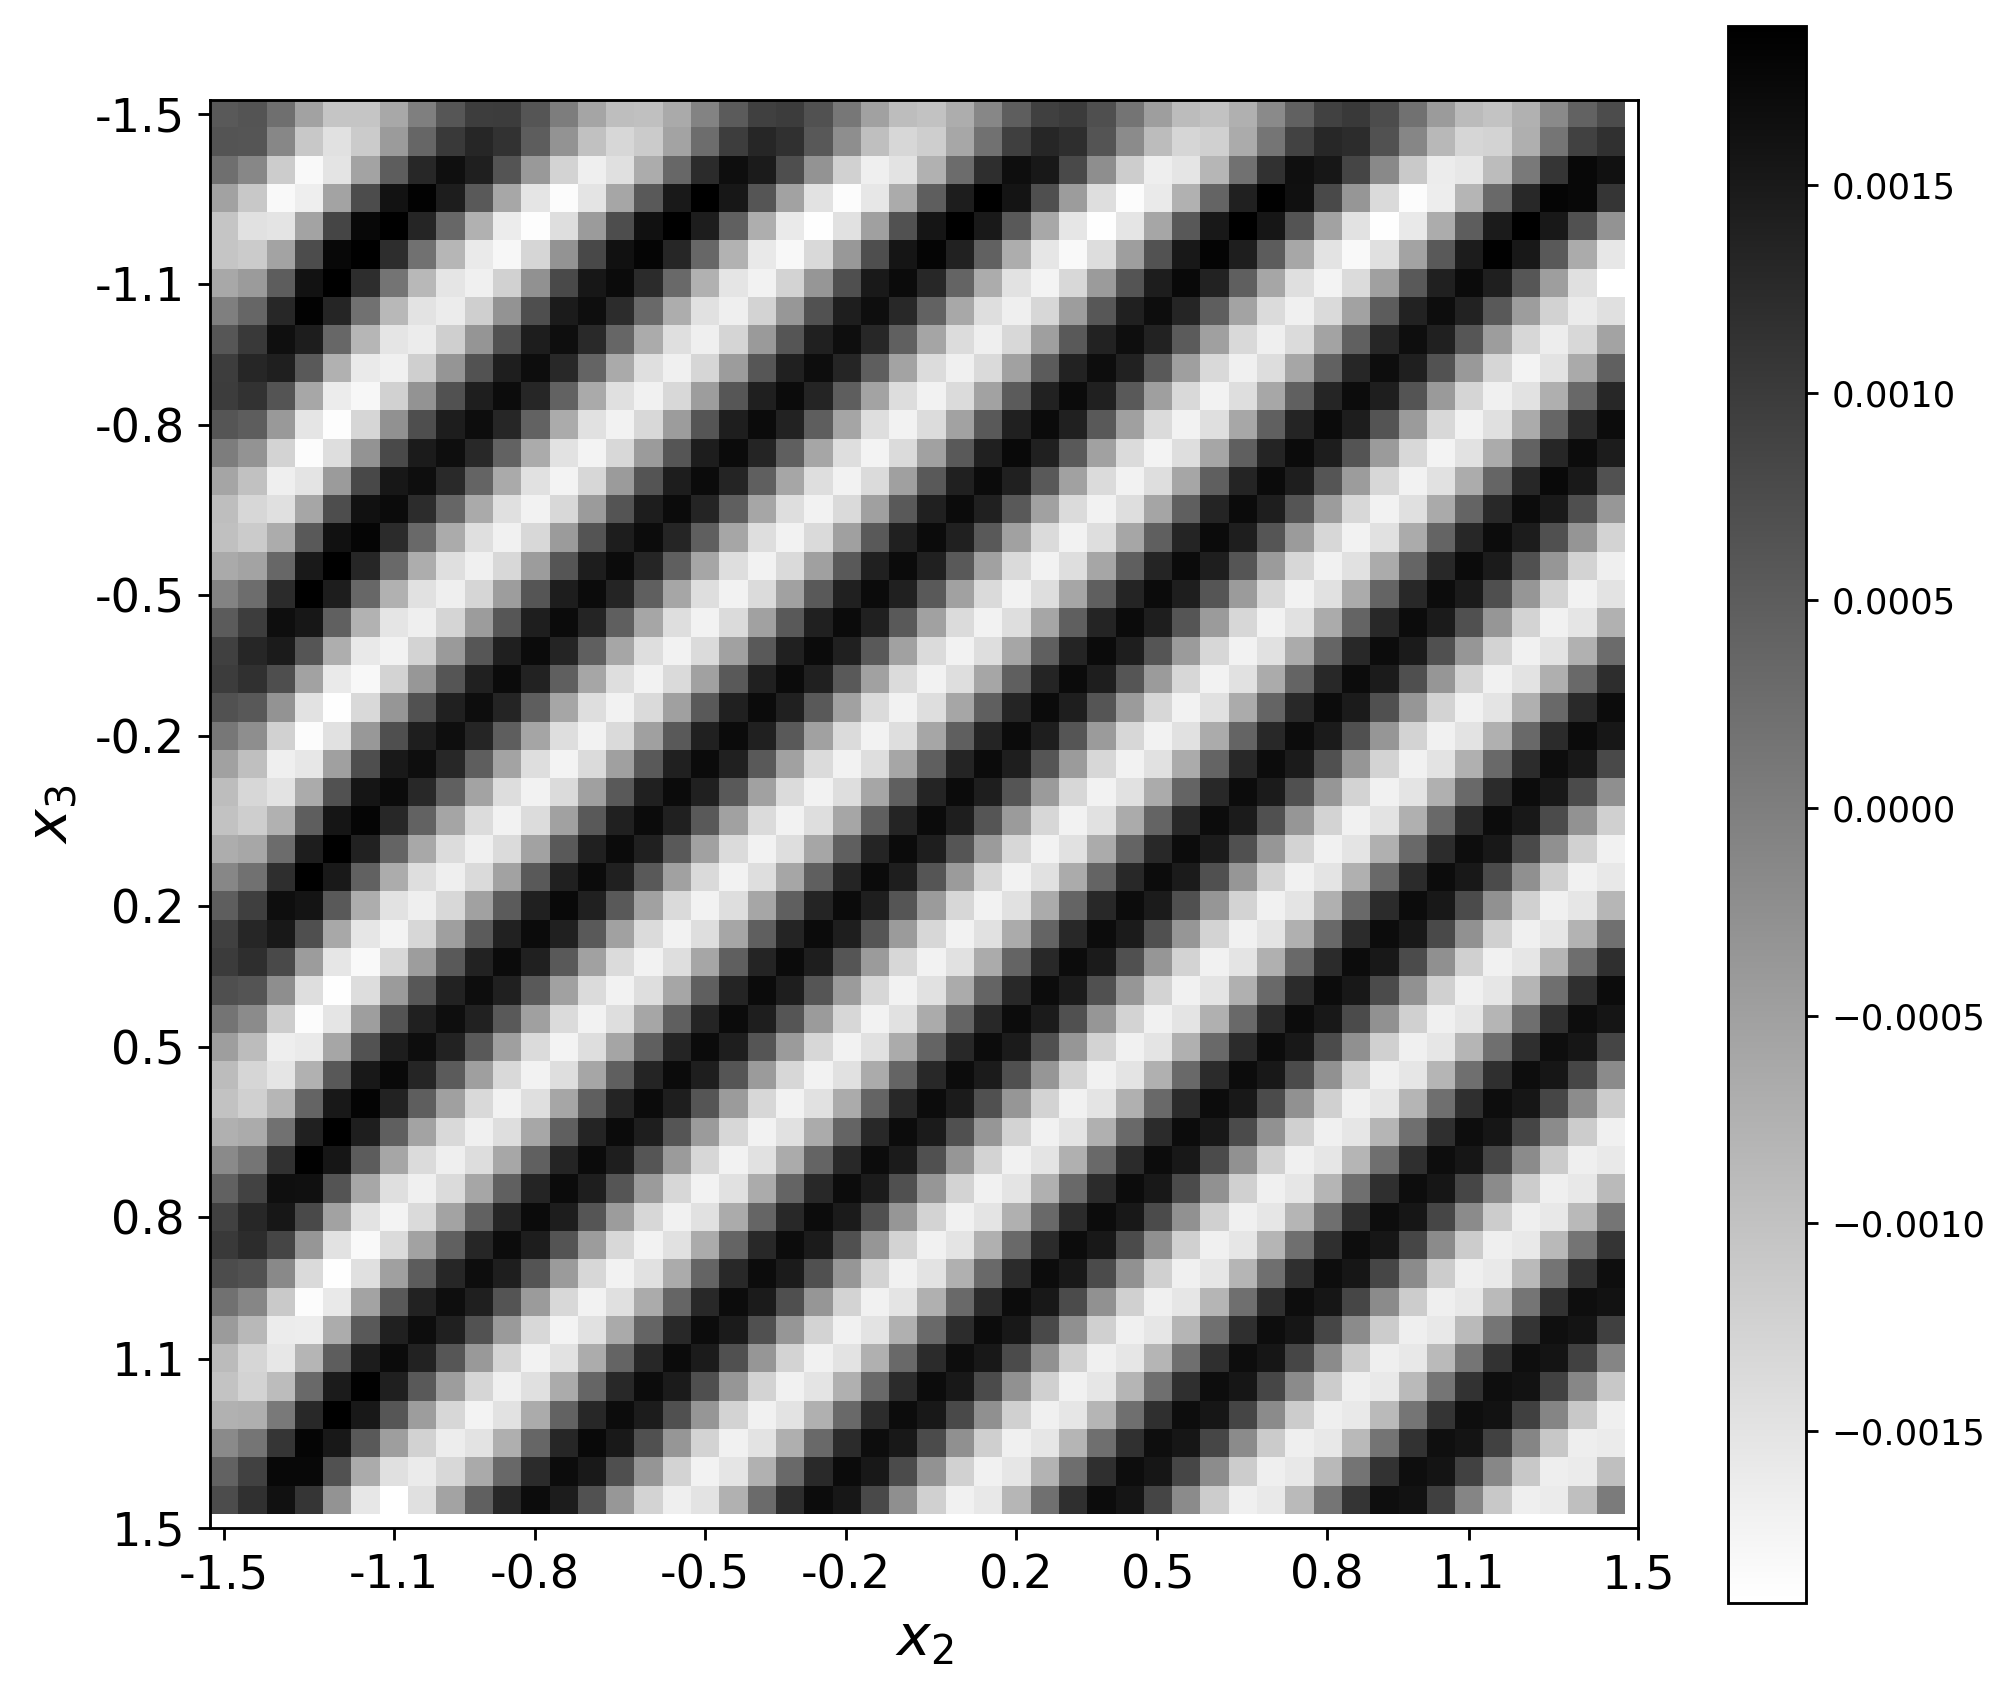

In [174]:
plot_yz(result_TS.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))
plot_yz(result_BICGStab.reshape(n_2, n_1, n_3).real, grid.reshape(n_2, n_1, n_3, 3))

In [175]:
resid_bicgstab = operator(G_array, result_BICGStab, (eta-1), k_wave, n_2, n_1, n_3) - u0_array
resid_ts = operator(G_array, result_TS, (eta-1), k_wave, n_2, n_1, n_3) - u0_array

print('Норма невязки интеграла для BICGStab:', bicg_norm(resid_bicgstab))
print('Норма невязки интеграла для TwoStep:', bicg_norm(resid_ts))

Норма невязки интеграла для BICGStab: 2.228997583354713e-05
Норма невязки интеграла для TwoStep: 0.009589760392352532


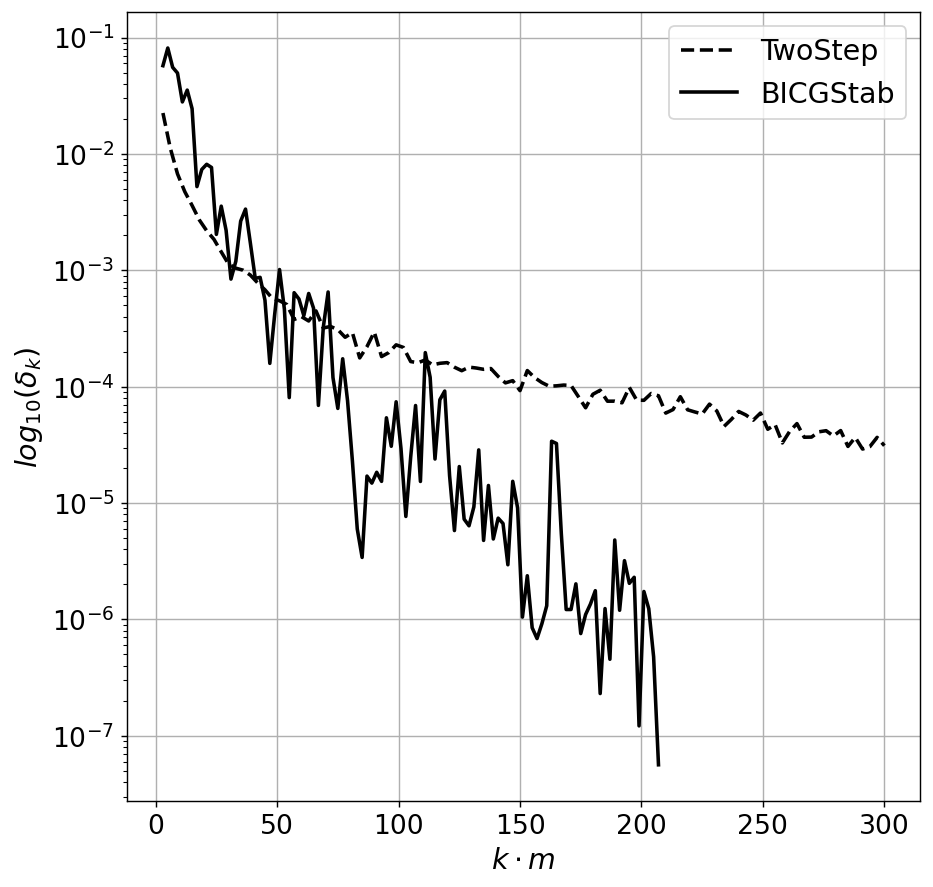

In [176]:
plt.figure(figsize=(8,8), dpi=128)
plt.plot(iterations_TS,
         accuracy_TS, 
         label="TwoStep", 
         c="black", 
         linestyle="--", 
         linewidth=2)
plt.plot(iters_BICGStab[1:], 
         eps_BICGStab[1:], 
         label="BICGStab",
         c="black", 
         linestyle="-", 
         linewidth=2)
plt.yscale('log')
plt.legend(fontsize = 16)
plt.ylabel(r'$log_{10}(\delta_k)$', fontsize=16)
plt.xlabel(r'$k\cdot m$', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

In [177]:
resid_BICGStab = [complex_norm(x) for x in resid_BICGStab]

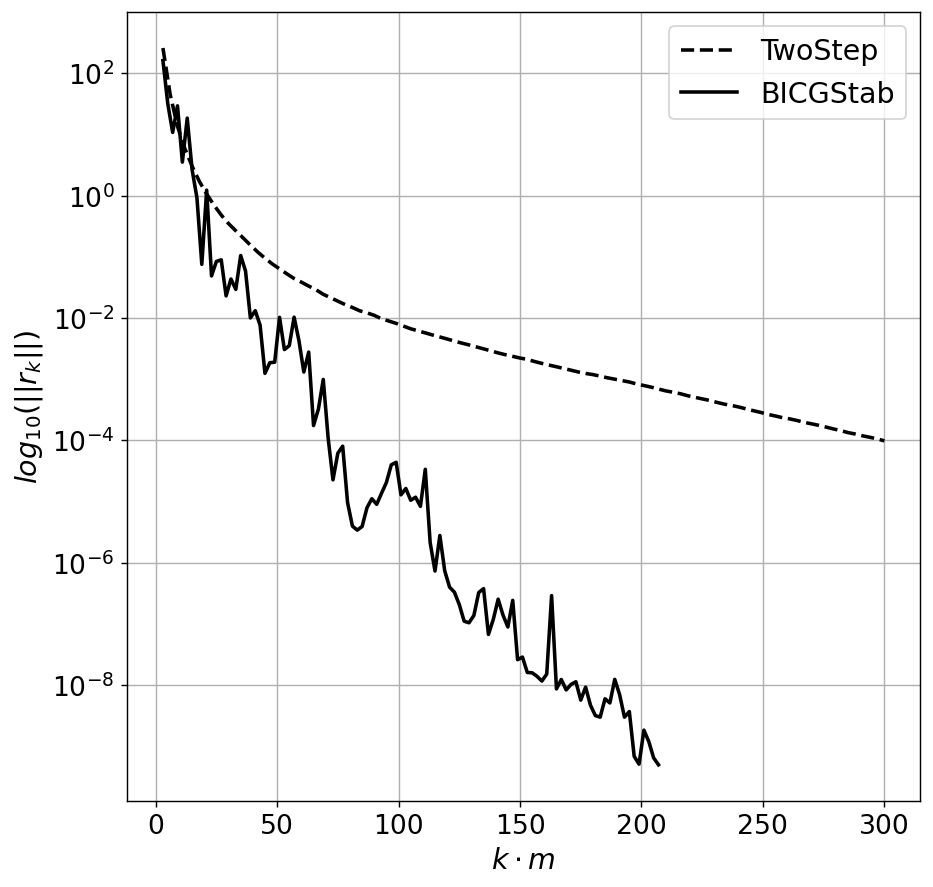

In [178]:
plt.figure(figsize=(8,8), dpi=128)
plt.plot(iterations_TS,
         resid_TS, 
         label="TwoStep", 
         c="black", 
         linestyle="--", 
         linewidth=2)
plt.plot(iters_BICGStab[1:], 
         resid_BICGStab[1:], 
         label="BICGStab",
         c="black", 
         linestyle="-", 
         linewidth=2)
plt.yscale('log')
plt.legend(fontsize = 16)
plt.ylabel(r'$log_{10} (||r_k||)$', fontsize = 16)
plt.xlabel(r'$k\cdot m$', fontsize = 16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

In [179]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 15

C:\Users\user\AppData\Local\Temp\ipykernel_11980\3755245352.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


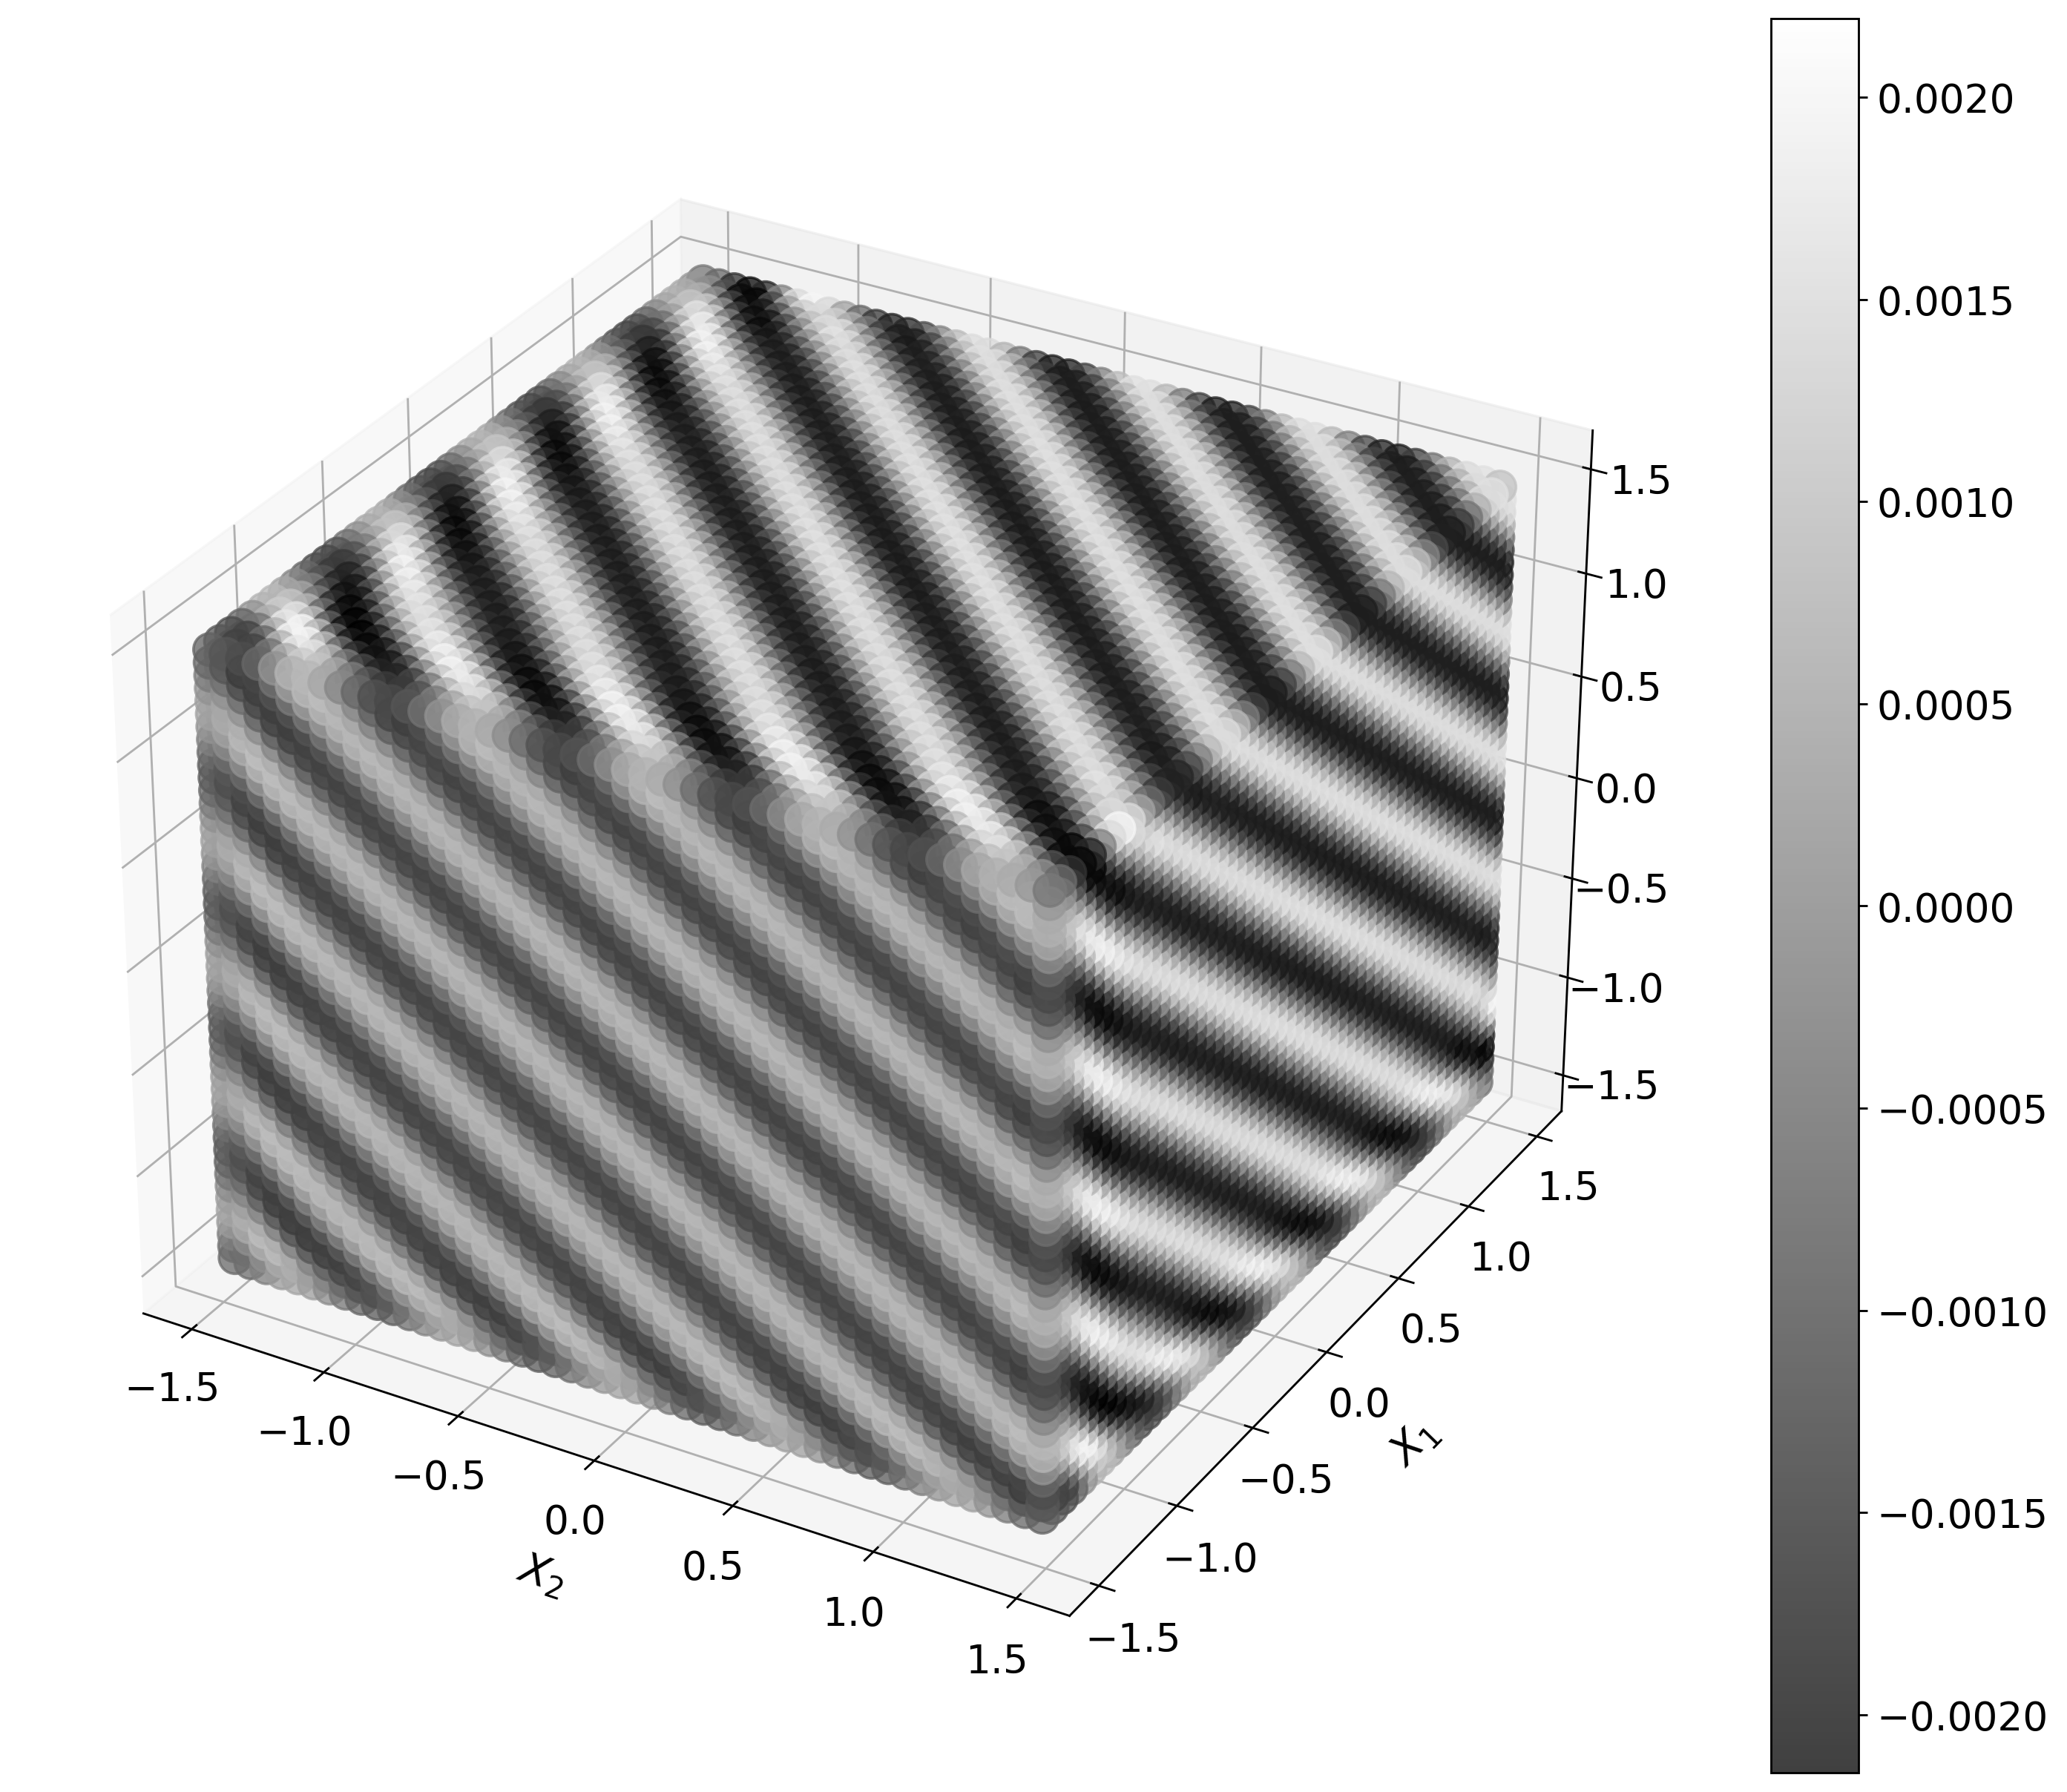

In [180]:
plot_cube_scatter3d(vector_U = result_BICGStab.real, cubes_collocations=grid,
                        figsize_opt=(14, 12),
                        cmap_opt="gray",
                        marker_size_opt=150,
                        alpha_opt=0.75,
                        title_opt="",
                        xlabel_opt=r"$X_2$",
                        ylabel_opt=r"$X_1$",
                        filename_opt="painting_scalar.png")

C:\Users\user\AppData\Local\Temp\ipykernel_10864\3755245352.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


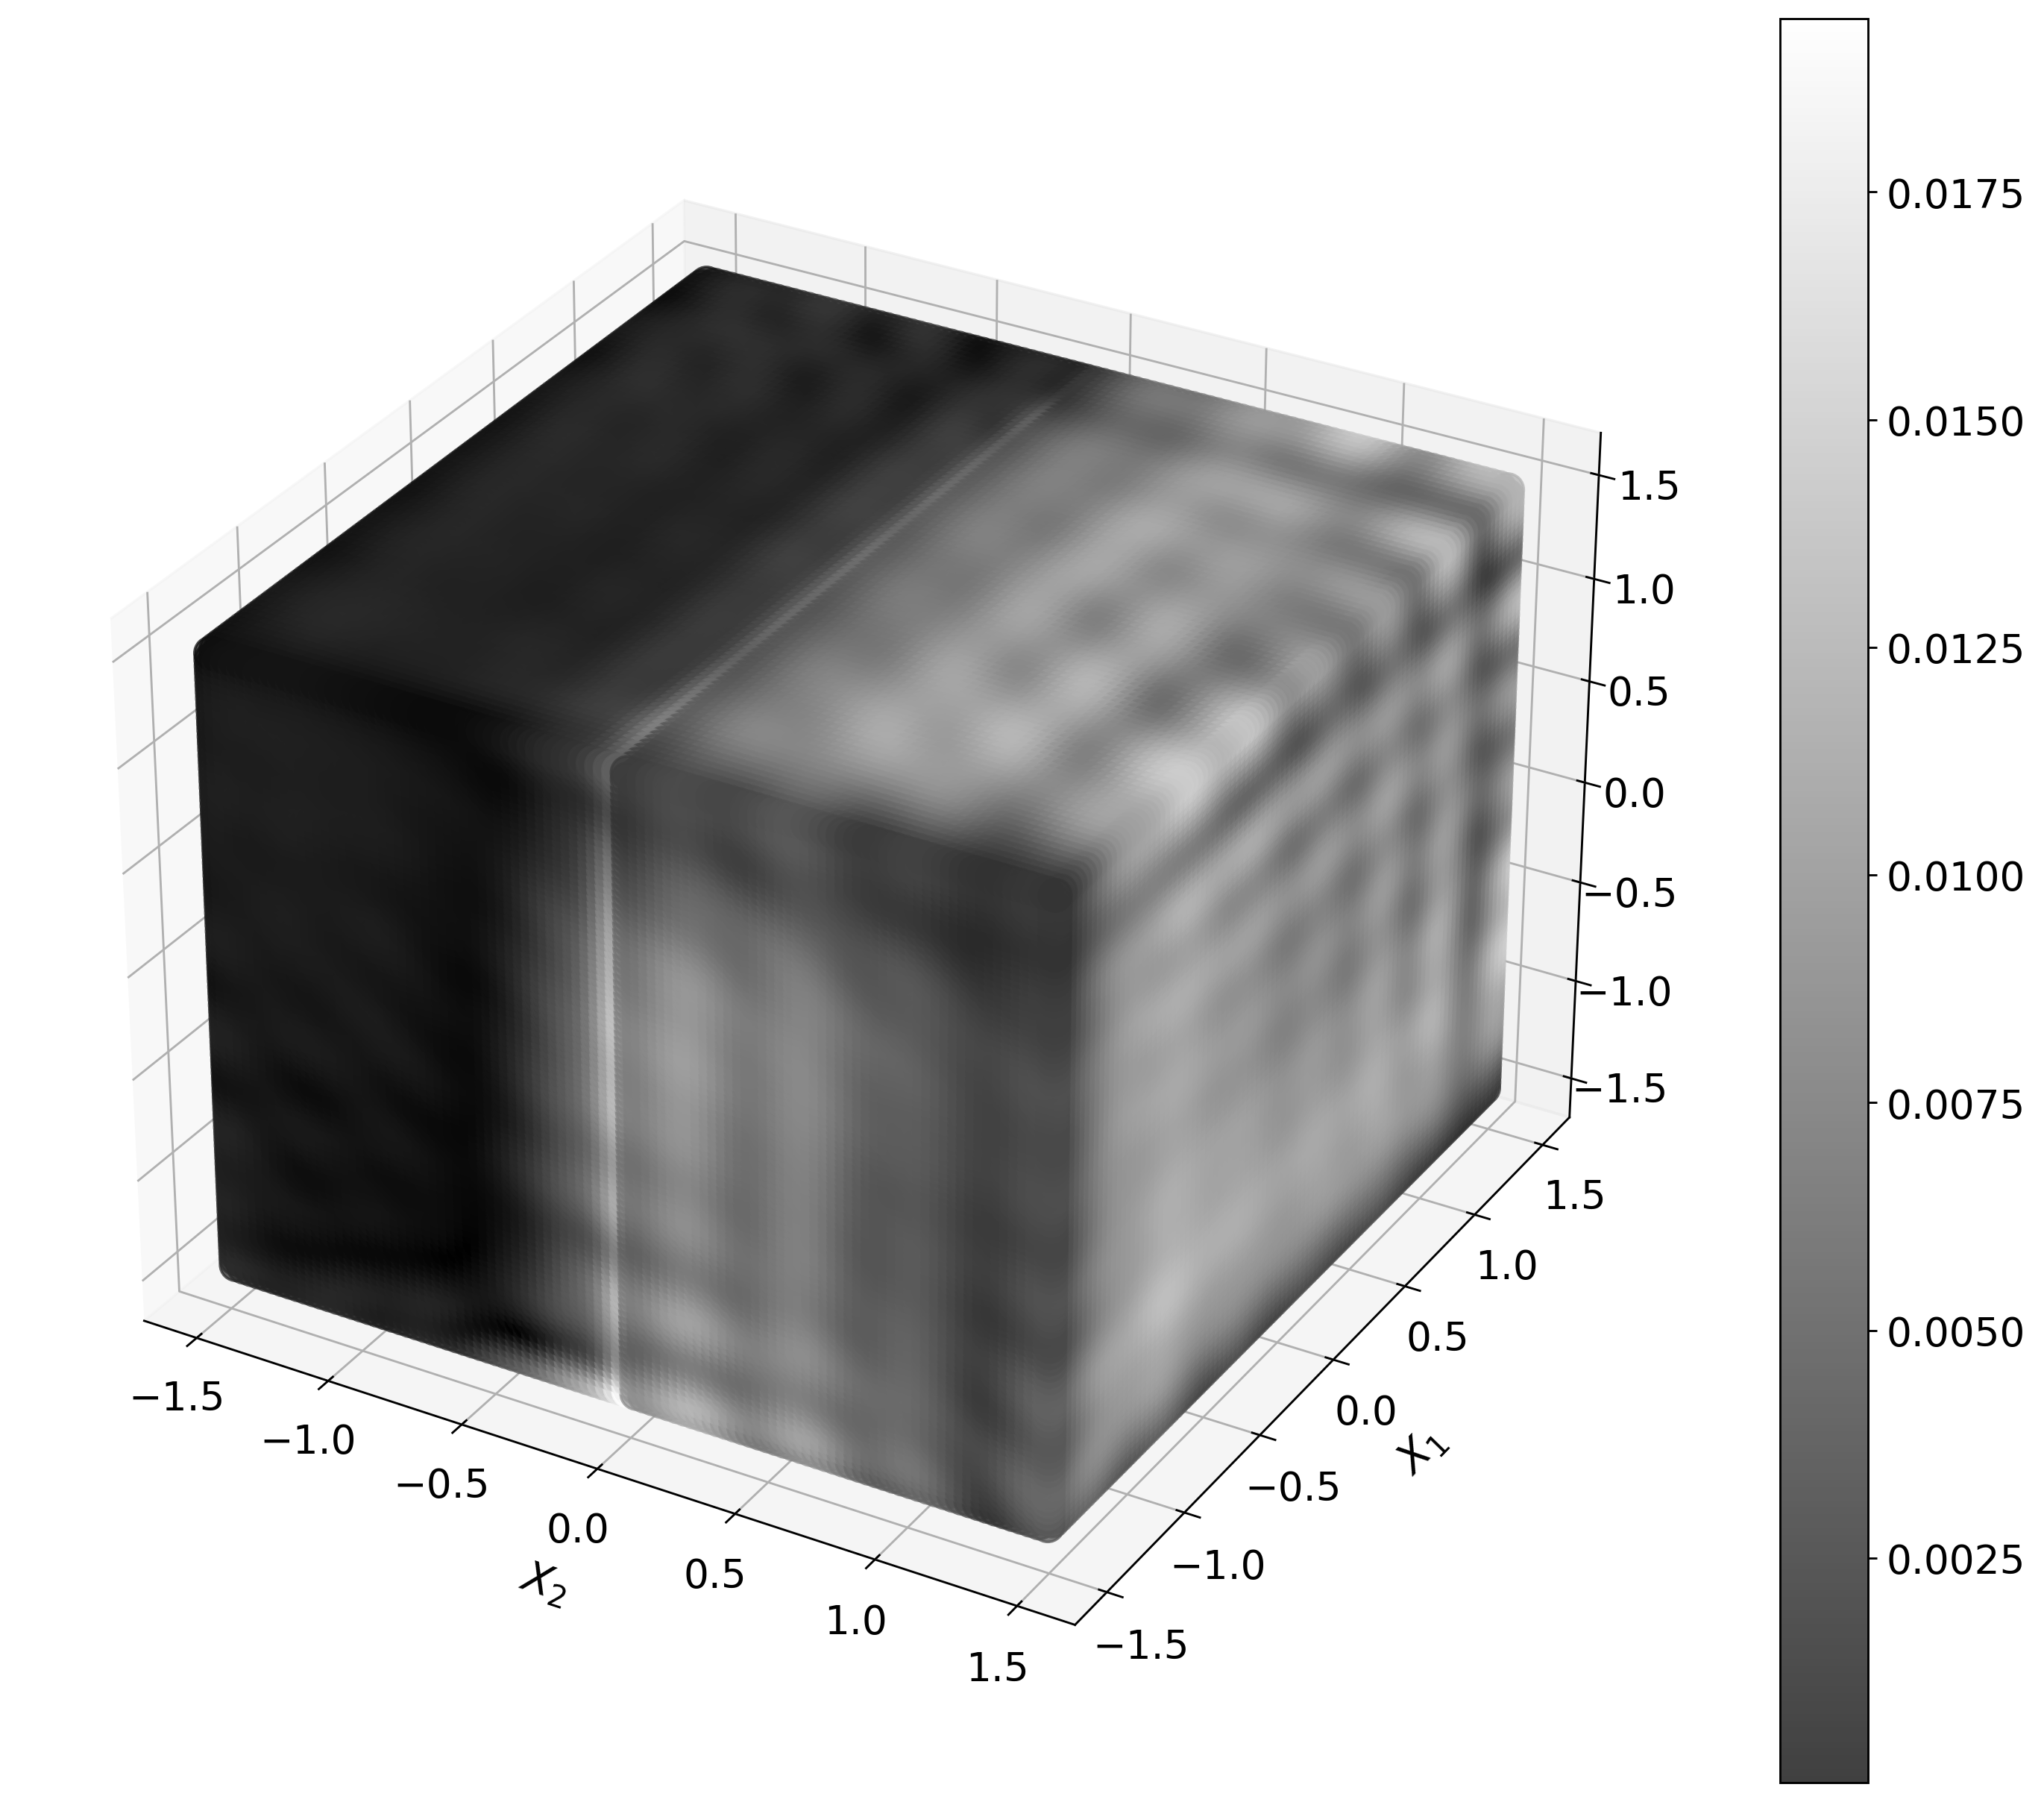

In [320]:
# plot_cube_scatter3d(vector_U = np.abs(result_TS), cubes_collocations=grid,
#                         figsize_opt=(14, 12),
#                         cmap_opt="gray",
#                         marker_size_opt=150,
#                         alpha_opt=0.75,
#                         title_opt="",
#                         xlabel_opt=r"$X_2$",
#                         ylabel_opt=r"$X_1$",
#                         filename_opt="painting_scalar_abs.png")

# Постановка вычислений для серии экспериментов

## Эксперименты для BiCGStab

In [13]:
problem_config = {
    'N': [50, 50, 50],
    'L': [3.0, 3.0, 3.0],
    'center': [0.0, 0.0, 0.0],
    'k': 10.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 2.0,
            "eps_imag": 1.5,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 0.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
l_1 = problem_config.get('L')[0]
l_2 = problem_config.get('L')[1]
l_3 = problem_config.get('L')[2]
k_wave = problem_config.get('k')

# Трехмерная сетка
grid, volume = make_grid(**problem_config)

print("Размерность сетки", grid.shape)
print("Объем ячейки", round(volume, 6))

# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)

# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))

Размерность сетки (125000, 3)
Объем ячейки 0.000216


In [14]:
iterations = 150

k_array = [2.0, 4.0]
k_array = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


iters_array_B = []
eps_array_B = []
resid_array_B = []
elapsed_array_B = []

for num, k_wave in enumerate(k_array):
    # Внешняя волна, определенная в точках сетки
    f_wave = wave(grid, k=k_wave, orient=problem_config.get("orient"), 
                  sign=problem_config.get("sign"), amplitude=problem_config.get("amplitude"))
    power_f = np.sum(np.abs(f_wave))/f_wave.size

    # Заполнение первой строки матрицы
    G_array = np.zeros_like(eta) + 0.0j
    G_array[1:] = kernel(dists[1:], **problem_config) * volume

    # Умножение внешней волны на ядро оператора
    u0_array = -1.0 * fast_bbtmv_mul(G_array.reshape(n_2, n_1, n_3), 
                              G_array.reshape(n_2, n_1, n_3), 
                              f_wave.reshape(n_2, n_1, n_3), 
                              n_2, n_1, n_3).reshape(-1, )
    print(f"#{num}  ---------------- ДЛИНА ВОЛНЫ k={k_wave} ----------------")
    start_time = timeit.default_timer()
    result_BICGStab, iters_BICGStab, eps_BICGStab, resid_BICGStab = \
    bicgstab(G_array, 
             u0_array, 
             (eta-1),
             k_wave,
             vector_u0=None, 
             n_1=n_2, n_2=n_1, n_3=n_3, 
             tol=1e-7, max_iter=iterations)
    elapsed = timeit.default_timer() - start_time
    resid_BICGStab = [complex_norm(x) for x in resid_BICGStab]
    
    iters_array_B.append(iters_BICGStab)
    eps_array_B.append(eps_BICGStab)
    resid_array_B.append(resid_BICGStab)
    elapsed_array_B.append(elapsed)

#0  ---------------- ДЛИНА ВОЛНЫ k=2.0 ----------------
Итерация №1: Умножений М-В L = 5, Умножений В-В V = 4, Критерий останова eps = 0.7973161821679507
Итерация №2: Умножений М-В L = 7, Умножений В-В V = 6, Критерий останова eps = 0.0739763496618356
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 8, Критерий останова eps = 0.0029157440871052944
Итерация №4: Умножений М-В L = 11, Умножений В-В V = 10, Критерий останова eps = 0.00020193992362094347
Итерация №5: Умножений М-В L = 13, Умножений В-В V = 12, Критерий останова eps = 2.4334135747110412e-05
Итерация №6: Умножений М-В L = 15, Умножений В-В V = 14, Критерий останова eps = 1.6343966104345185e-06
достичь нужной точности смогли быстрее
#1  ---------------- ДЛИНА ВОЛНЫ k=4.0 ----------------
Итерация №1: Умножений М-В L = 5, Умножений В-В V = 4, Критерий останова eps = 0.5108484744192958
Итерация №2: Умножений М-В L = 7, Умножений В-В V = 6, Критерий останова eps = 0.3853810960821746
Итерация №3: Умножений М-В L = 9, Умножений 

Итерация №29: Умножений М-В L = 61, Умножений В-В V = 60, Критерий останова eps = 6.139432656396891e-06
Итерация №30: Умножений М-В L = 63, Умножений В-В V = 62, Критерий останова eps = 1.5535213243069678e-06
Итерация №31: Умножений М-В L = 65, Умножений В-В V = 64, Критерий останова eps = 4.109994788823061e-06
Итерация №32: Умножений М-В L = 67, Умножений В-В V = 66, Критерий останова eps = 2.142751339139735e-06
Итерация №33: Умножений М-В L = 69, Умножений В-В V = 68, Критерий останова eps = 3.456975122401718e-07
Итерация №34: Умножений М-В L = 71, Умножений В-В V = 70, Критерий останова eps = 5.877362671952469e-07
Итерация №35: Умножений М-В L = 73, Умножений В-В V = 72, Критерий останова eps = 3.5702784019147404e-07
Итерация №36: Умножений М-В L = 75, Умножений В-В V = 74, Критерий останова eps = 1.473987020185453e-07
Итерация №37: Умножений М-В L = 77, Умножений В-В V = 76, Критерий останова eps = 2.3025262517189626e-07
Итерация №38: Умножений М-В L = 79, Умножений В-В V = 78, Кри

Итерация №10: Умножений М-В L = 23, Умножений В-В V = 22, Критерий останова eps = 0.005311520318684644
Итерация №11: Умножений М-В L = 25, Умножений В-В V = 24, Критерий останова eps = 0.00968488251617376
Итерация №12: Умножений М-В L = 27, Умножений В-В V = 26, Критерий останова eps = 0.008446191584077696
Итерация №13: Умножений М-В L = 29, Умножений В-В V = 28, Критерий останова eps = 0.009505549873403714
Итерация №14: Умножений М-В L = 31, Умножений В-В V = 30, Критерий останова eps = 0.002840863117201212
Итерация №15: Умножений М-В L = 33, Умножений В-В V = 32, Критерий останова eps = 0.003030933327663622
Итерация №16: Умножений М-В L = 35, Умножений В-В V = 34, Критерий останова eps = 0.017684237332055316
Итерация №17: Умножений М-В L = 37, Умножений В-В V = 36, Критерий останова eps = 0.01363296643468996
Итерация №18: Умножений М-В L = 39, Умножений В-В V = 38, Критерий останова eps = 0.004611081617836373
Итерация №19: Умножений М-В L = 41, Умножений В-В V = 40, Критерий останова

Итерация №89: Умножений М-В L = 181, Умножений В-В V = 180, Критерий останова eps = 0.00010482409033671425
Итерация №90: Умножений М-В L = 183, Умножений В-В V = 182, Критерий останова eps = 0.00011683729473460094
Итерация №91: Умножений М-В L = 185, Умножений В-В V = 184, Критерий останова eps = 2.4474987583502267e-05
Итерация №92: Умножений М-В L = 187, Умножений В-В V = 186, Критерий останова eps = 0.00012207908878677506
Итерация №93: Умножений М-В L = 189, Умножений В-В V = 188, Критерий останова eps = 6.740132569490971e-05
Итерация №94: Умножений М-В L = 191, Умножений В-В V = 190, Критерий останова eps = 2.6358183840136664e-05
Итерация №95: Умножений М-В L = 193, Умножений В-В V = 192, Критерий останова eps = 5.689451315747325e-05
Итерация №96: Умножений М-В L = 195, Умножений В-В V = 194, Критерий останова eps = 8.13324187610265e-05
Итерация №97: Умножений М-В L = 197, Умножений В-В V = 196, Критерий останова eps = 2.915914522785319e-05
Итерация №98: Умножений М-В L = 199, Умнож

Итерация №28: Умножений М-В L = 59, Умножений В-В V = 58, Критерий останова eps = 0.012201359330563552
Итерация №29: Умножений М-В L = 61, Умножений В-В V = 60, Критерий останова eps = 0.003969222925534856
Итерация №30: Умножений М-В L = 63, Умножений В-В V = 62, Критерий останова eps = 0.0013405449462093489
Итерация №31: Умножений М-В L = 65, Умножений В-В V = 64, Критерий останова eps = 0.002493230646571136
Итерация №32: Умножений М-В L = 67, Умножений В-В V = 66, Критерий останова eps = 0.0019344157031143683
Итерация №33: Умножений М-В L = 69, Умножений В-В V = 68, Критерий останова eps = 0.0036651581912158075
Итерация №34: Умножений М-В L = 71, Умножений В-В V = 70, Критерий останова eps = 0.0020064860897524503
Итерация №35: Умножений М-В L = 73, Умножений В-В V = 72, Критерий останова eps = 0.001961131258617864
Итерация №36: Умножений М-В L = 75, Умножений В-В V = 74, Критерий останова eps = 0.004336507019373518
Итерация №37: Умножений М-В L = 77, Умножений В-В V = 76, Критерий ос

Итерация №106: Умножений М-В L = 215, Умножений В-В V = 214, Критерий останова eps = 0.00037744199634180144
Итерация №107: Умножений М-В L = 217, Умножений В-В V = 216, Критерий останова eps = 0.00014003732548757163
Итерация №108: Умножений М-В L = 219, Умножений В-В V = 218, Критерий останова eps = 0.00011245906021559269
Итерация №109: Умножений М-В L = 221, Умножений В-В V = 220, Критерий останова eps = 3.094355706779759e-05
Итерация №110: Умножений М-В L = 223, Умножений В-В V = 222, Критерий останова eps = 2.982753706091694e-05
Итерация №111: Умножений М-В L = 225, Умножений В-В V = 224, Критерий останова eps = 8.994134388981111e-06
Итерация №112: Умножений М-В L = 227, Умножений В-В V = 226, Критерий останова eps = 3.259412858800034e-05
Итерация №113: Умножений М-В L = 229, Умножений В-В V = 228, Критерий останова eps = 2.554045482270963e-05
Итерация №114: Умножений М-В L = 231, Умножений В-В V = 230, Критерий останова eps = 8.037212744244571e-05
Итерация №115: Умножений М-В L = 2

Итерация №34: Умножений М-В L = 71, Умножений В-В V = 70, Критерий останова eps = 0.031369172050697655
Итерация №35: Умножений М-В L = 73, Умножений В-В V = 72, Критерий останова eps = 0.005428200913718379
Итерация №36: Умножений М-В L = 75, Умножений В-В V = 74, Критерий останова eps = 0.014621164911305707
Итерация №37: Умножений М-В L = 77, Умножений В-В V = 76, Критерий останова eps = 0.0028459136116747667
Итерация №38: Умножений М-В L = 79, Умножений В-В V = 78, Критерий останова eps = 0.0105062580495809
Итерация №39: Умножений М-В L = 81, Умножений В-В V = 80, Критерий останова eps = 0.018242655241348438
Итерация №40: Умножений М-В L = 83, Умножений В-В V = 82, Критерий останова eps = 0.01407295967225606
Итерация №41: Умножений М-В L = 85, Умножений В-В V = 84, Критерий останова eps = 0.005645662922450532
Итерация №42: Умножений М-В L = 87, Умножений В-В V = 86, Критерий останова eps = 0.004169782712960213
Итерация №43: Умножений М-В L = 89, Умножений В-В V = 88, Критерий останова

Итерация №112: Умножений М-В L = 227, Умножений В-В V = 226, Критерий останова eps = 6.768728533682901e-05
Итерация №113: Умножений М-В L = 229, Умножений В-В V = 228, Критерий останова eps = 0.00011678135325225643
Итерация №114: Умножений М-В L = 231, Умножений В-В V = 230, Критерий останова eps = 3.7195224545096064e-05
Итерация №115: Умножений М-В L = 233, Умножений В-В V = 232, Критерий останова eps = 0.00016833558846111803
Итерация №116: Умножений М-В L = 235, Умножений В-В V = 234, Критерий останова eps = 8.710491181314352e-05
Итерация №117: Умножений М-В L = 237, Умножений В-В V = 236, Критерий останова eps = 5.233608499024608e-05
Итерация №118: Умножений М-В L = 239, Умножений В-В V = 238, Критерий останова eps = 0.00015634577903197026
Итерация №119: Умножений М-В L = 241, Умножений В-В V = 240, Критерий останова eps = 0.00016119323688964723
Итерация №120: Умножений М-В L = 243, Умножений В-В V = 242, Критерий останова eps = 0.00011600205211109046
Итерация №121: Умножений М-В L 

Итерация №40: Умножений М-В L = 83, Умножений В-В V = 82, Критерий останова eps = 0.24687153776759785
Итерация №41: Умножений М-В L = 85, Умножений В-В V = 84, Критерий останова eps = 0.1958977078567262
Итерация №42: Умножений М-В L = 87, Умножений В-В V = 86, Критерий останова eps = 0.2899541988385981
Итерация №43: Умножений М-В L = 89, Умножений В-В V = 88, Критерий останова eps = 0.13742376987894625
Итерация №44: Умножений М-В L = 91, Умножений В-В V = 90, Критерий останова eps = 0.42889355941062884
Итерация №45: Умножений М-В L = 93, Умножений В-В V = 92, Критерий останова eps = 0.5056592939159852
Итерация №46: Умножений М-В L = 95, Умножений В-В V = 94, Критерий останова eps = 0.11513986509400519
Итерация №47: Умножений М-В L = 97, Умножений В-В V = 96, Критерий останова eps = 0.03134173709231593
Итерация №48: Умножений М-В L = 99, Умножений В-В V = 98, Критерий останова eps = 0.1388630718322883
Итерация №49: Умножений М-В L = 101, Умножений В-В V = 100, Критерий останова eps = 0.

Итерация №119: Умножений М-В L = 241, Умножений В-В V = 240, Критерий останова eps = 0.001981925454296409
Итерация №120: Умножений М-В L = 243, Умножений В-В V = 242, Критерий останова eps = 0.002942103859143262
Итерация №121: Умножений М-В L = 245, Умножений В-В V = 244, Критерий останова eps = 0.0033853286436763903
Итерация №122: Умножений М-В L = 247, Умножений В-В V = 246, Критерий останова eps = 0.003985107281669512
Итерация №123: Умножений М-В L = 249, Умножений В-В V = 248, Критерий останова eps = 0.0033370621586190034
Итерация №124: Умножений М-В L = 251, Умножений В-В V = 250, Критерий останова eps = 0.004205163968498102
Итерация №125: Умножений М-В L = 253, Умножений В-В V = 252, Критерий останова eps = 0.01522112625912795
Итерация №126: Умножений М-В L = 255, Умножений В-В V = 254, Критерий останова eps = 0.016044205581007224
Итерация №127: Умножений М-В L = 257, Умножений В-В V = 256, Критерий останова eps = 0.0009814345099480495
Итерация №128: Умножений М-В L = 259, Умноже

Итерация №48: Умножений М-В L = 99, Умножений В-В V = 98, Критерий останова eps = 0.0010746934902988068
Итерация №49: Умножений М-В L = 101, Умножений В-В V = 100, Критерий останова eps = 0.002418392691304087
Итерация №50: Умножений М-В L = 103, Умножений В-В V = 102, Критерий останова eps = 0.002359894466416969
Итерация №51: Умножений М-В L = 105, Умножений В-В V = 104, Критерий останова eps = 0.0032516968847663844
Итерация №52: Умножений М-В L = 107, Умножений В-В V = 106, Критерий останова eps = 0.002777986220045628
Итерация №53: Умножений М-В L = 109, Умножений В-В V = 108, Критерий останова eps = 0.001843583119234482
Итерация №54: Умножений М-В L = 111, Умножений В-В V = 110, Критерий останова eps = 0.0016010732319421597
Итерация №55: Умножений М-В L = 113, Умножений В-В V = 112, Критерий останова eps = 0.0006042560067431532
Итерация №56: Умножений М-В L = 115, Умножений В-В V = 114, Критерий останова eps = 0.0041440903637269925
Итерация №57: Умножений М-В L = 117, Умножений В-В V

Итерация №126: Умножений М-В L = 255, Умножений В-В V = 254, Критерий останова eps = 8.341463837965613e-05
Итерация №127: Умножений М-В L = 257, Умножений В-В V = 256, Критерий останова eps = 9.618406519365656e-05
Итерация №128: Умножений М-В L = 259, Умножений В-В V = 258, Критерий останова eps = 0.00017073627439788983
Итерация №129: Умножений М-В L = 261, Умножений В-В V = 260, Критерий останова eps = 3.4764063693378054e-05
Итерация №130: Умножений М-В L = 263, Умножений В-В V = 262, Критерий останова eps = 1.88758344761454e-05
Итерация №131: Умножений М-В L = 265, Умножений В-В V = 264, Критерий останова eps = 2.9579158431167236e-05
Итерация №132: Умножений М-В L = 267, Умножений В-В V = 266, Критерий останова eps = 6.384674863214216e-05
Итерация №133: Умножений М-В L = 269, Умножений В-В V = 268, Критерий останова eps = 7.496045148273326e-06
Итерация №134: Умножений М-В L = 271, Умножений В-В V = 270, Критерий останова eps = 4.147693732638233e-05
Итерация №135: Умножений М-В L = 27

In [15]:
print("Количество точек на длину волны")
np.array(2 * np.pi * n_1 / np.array(k_array) / l_1, dtype=int)

Количество точек на длину волны


array([52, 26, 17, 13, 10,  8,  7,  6,  5,  5])

In [16]:
np.array([x[-1] for x in eps_array_B])

array([1.63439661e-06, 7.82502340e-08, 7.41145440e-08, 8.18750215e-08,
       8.64516575e-08, 8.23787425e-08, 9.30251520e-07, 8.76159371e-06,
       2.88744290e-03, 8.61466792e-05])

In [17]:
elapsed_array_B

[1.9813308999998753,
 4.138005999999905,
 8.61007040000004,
 11.767867600000045,
 16.11523349999993,
 39.80809320000003,
 42.68855080000003,
 42.64453389999994,
 42.437142400000084,
 42.76467899999989]

In [18]:
np.array([x[-1] for x in resid_array_B])

array([1.38692238e-13, 7.44837960e-14, 4.35546626e-12, 9.55512085e-13,
       3.16136190e-10, 5.07088482e-11, 7.86425045e-10, 3.66212501e-08,
       4.85204586e-03, 4.37641582e-07])

In [19]:
np.array([x[-1] for x in iters_array_B])

array([ 13,  29,  61,  83, 113, 279, 301, 301, 301, 301])

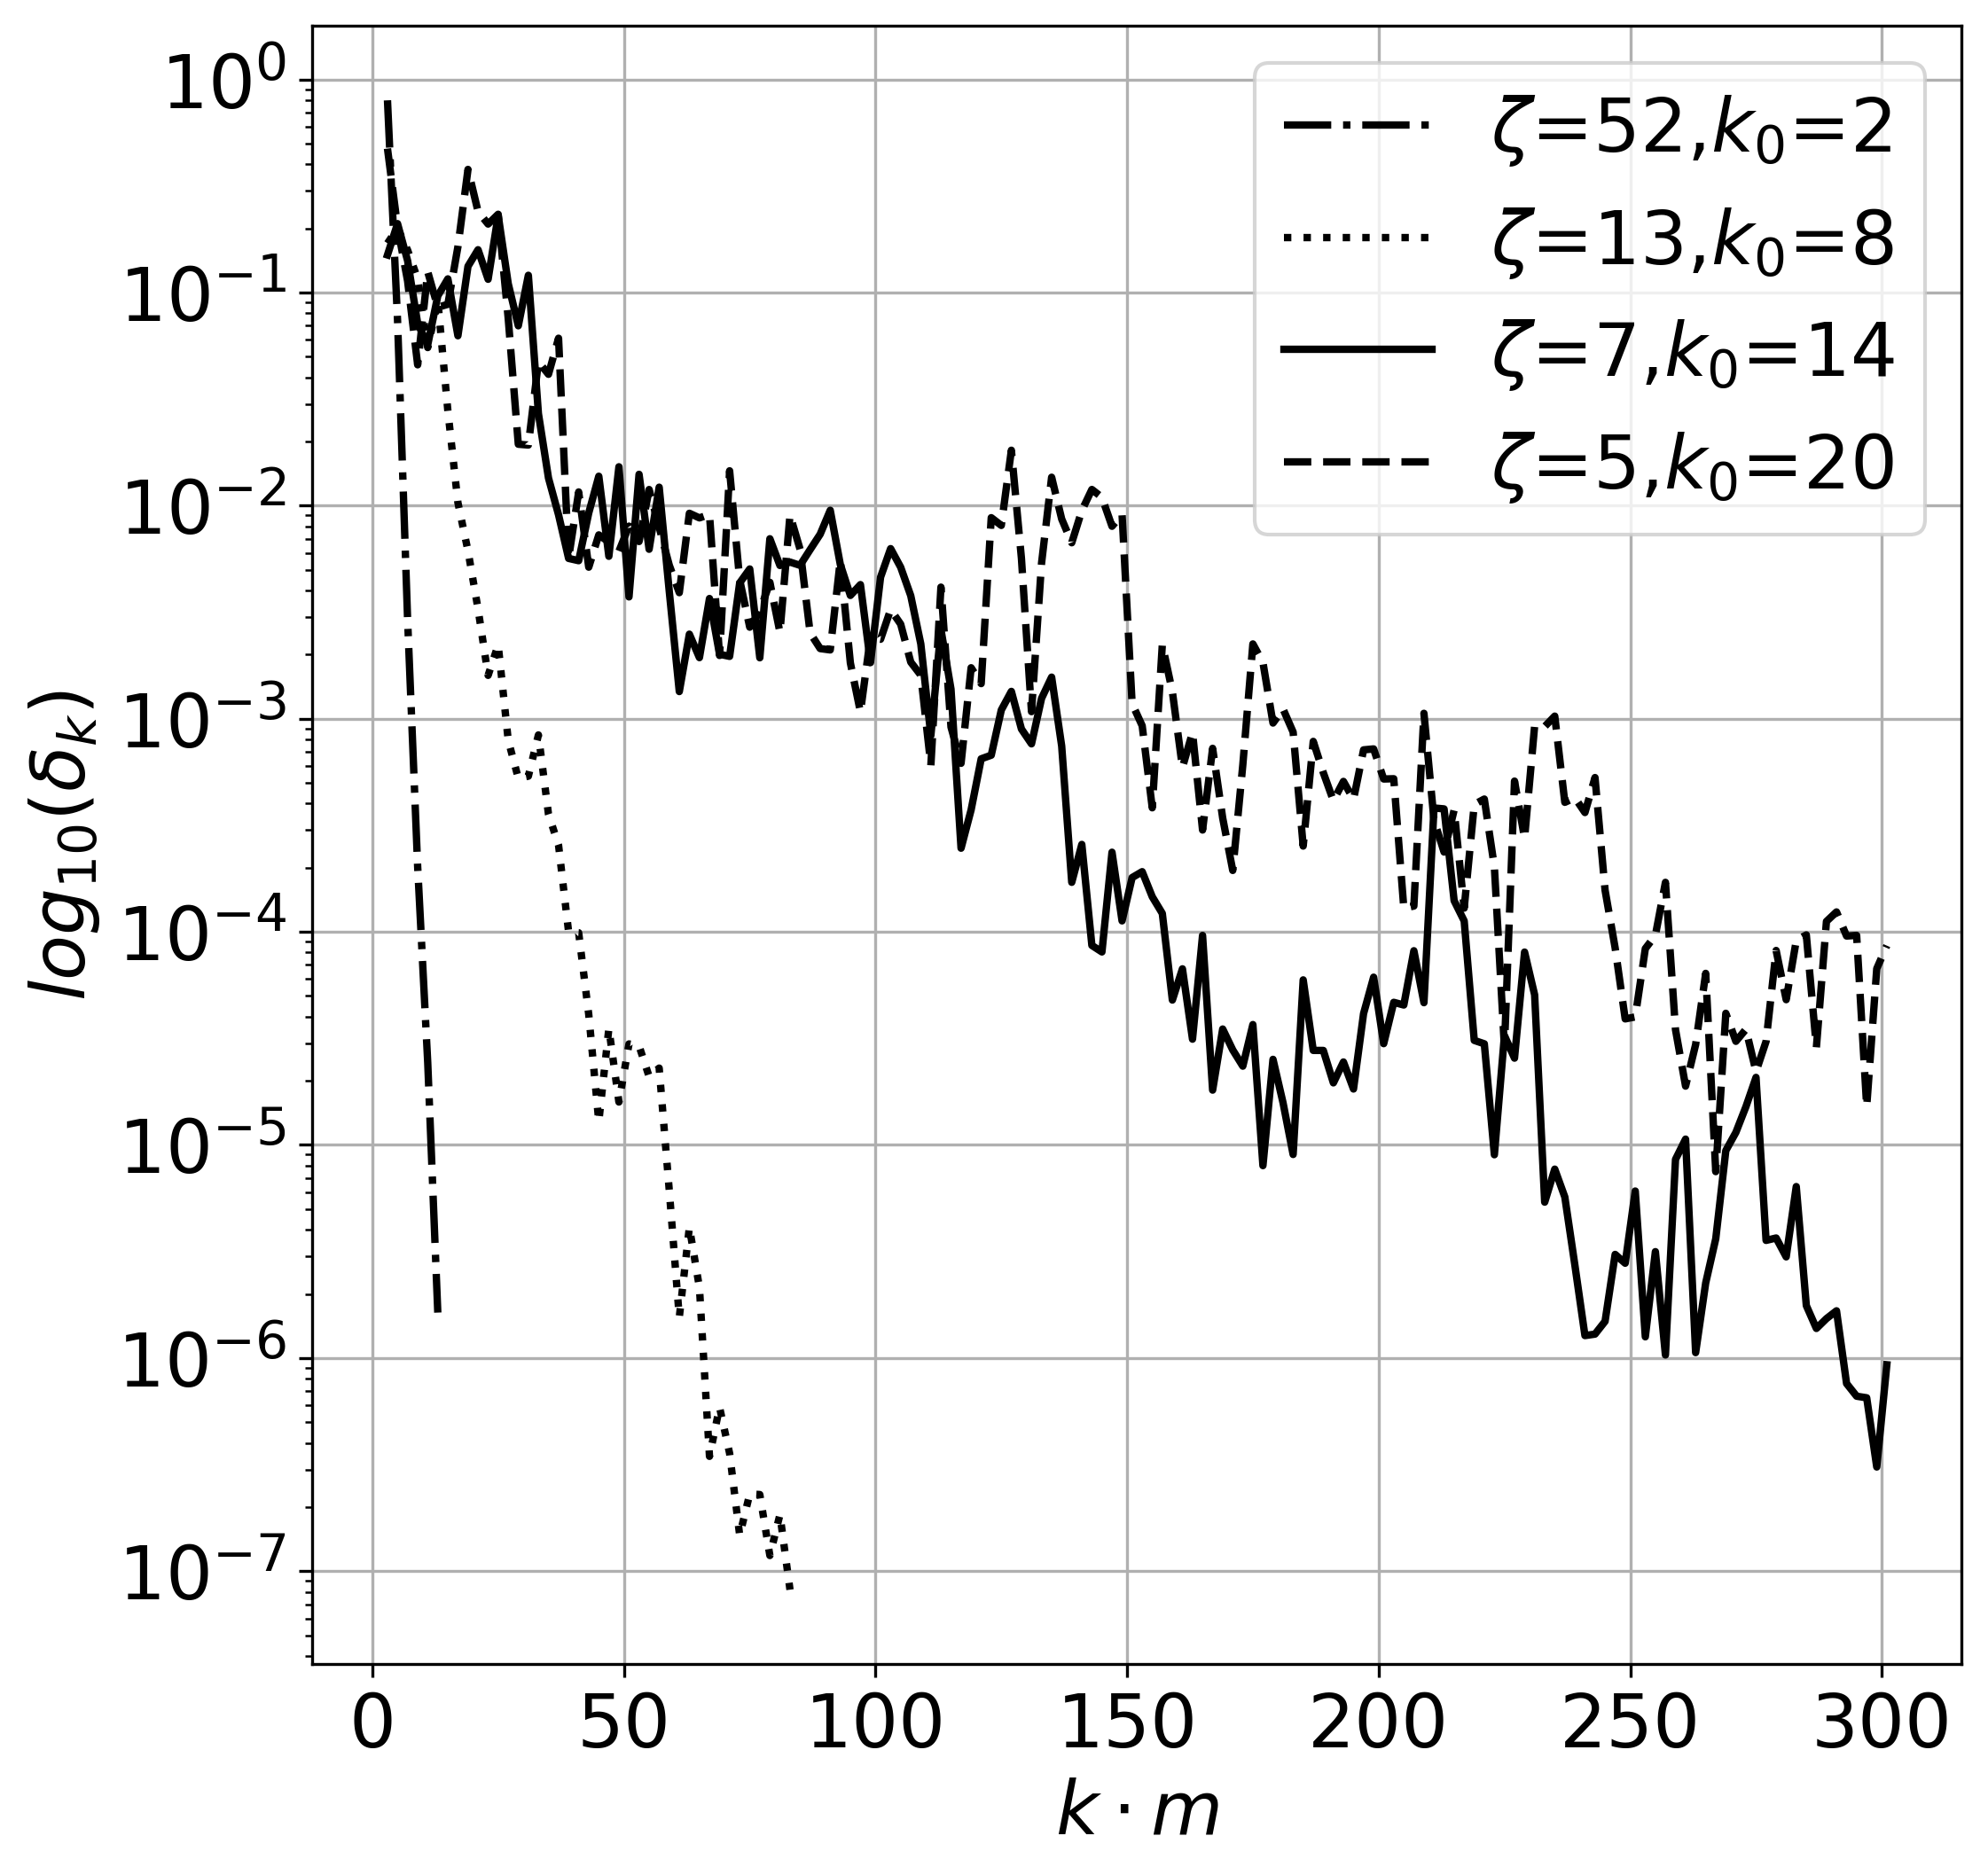

In [24]:
# Задаём список стилей линий (их можно расширять или менять)
linestyles = [
    '-.', ':', '-', '--', 
    (0, (1, 10)),  # чередование коротких штрихов и длинных пробелов
    (0, (5, 5)),   # равномерные штрихи
    (0, (3, 1, 1, 1)),  # комплексное чередование
    (0, (1, 3)),   # штрихи с большим пробелом
    (0, (3, 5, 1, 5)),
    (0, (3, 5, 1, 3))
]

# Список маркеров. Если маркеры не нужны, их можно не указывать, оставив только стили линий.
#markers = ['o', 's', '^', '*', 'D', 'v', '<', '>', 'p', 'h']

plt.figure(figsize=(8,8), dpi=300)
for num, k_wave in enumerate(k_array[::3]):
    zeta = int(2*np.pi*n_1/l_1/k_wave)    # Количество точек на длину волны
    plt.plot(iters_array_B[3 * num][1:], 
             eps_array_B[3 * num][1:], 
             label=r"$\zeta$="+f"{zeta}"+r",$k_0$" +f"={int(k_wave)}",
             c="black", 
             linestyle=linestyles[num],        # Для каждой линии свой стиль
#             marker=markers[num],
             linewidth=2)

plt.yscale('log')
plt.legend(fontsize = 20)
plt.ylabel(r'$log_{10}(\delta_k)$', fontsize=20)
plt.xlabel(r'$k\cdot m$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

# Эксперимент для двухшагового метода 

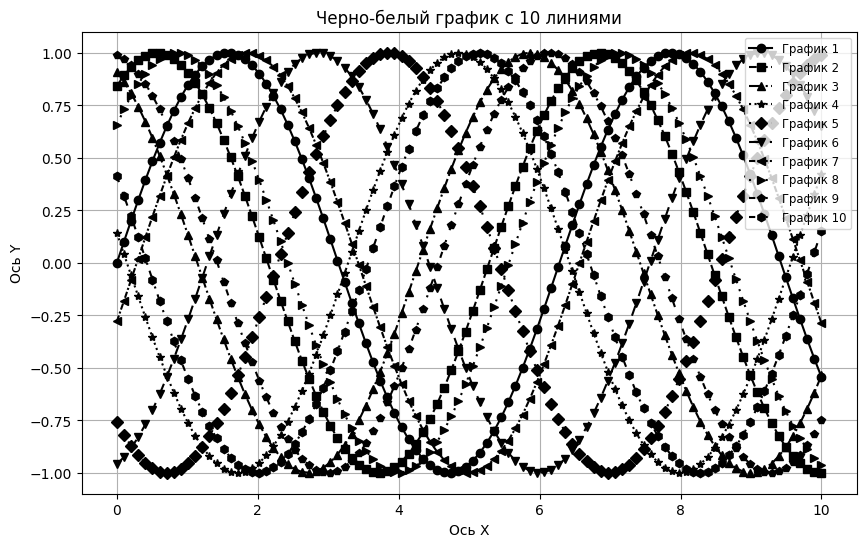

In [121]:
problem_config = {
    'N': [50, 50, 50],
    'L': [3.0, 3.0, 3.0],
    'center': [0.0, 0.0, 0.0],
    'k': 10.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 2.0,
            "eps_imag": 1.5,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 0.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
l_1 = problem_config.get('L')[0]
l_2 = problem_config.get('L')[1]
l_3 = problem_config.get('L')[2]
k_wave = problem_config.get('k')

# Трехмерная сетка
grid, volume = make_grid(**problem_config)

print("Размерность сетки", grid.shape)
print("Объем ячейки", round(volume, 6))

# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)

# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))

In [142]:
iterations = 100

k_array = [2.0, 4.0]
k_array = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]


iters_array_T = []
eps_array_T = []
resid_array_T = []
elapsed_array_T = []

for num, k_wave in enumerate(k_array):
    # Внешняя волна, определенная в точках сетки
    f_wave = wave(grid, k=k_wave, orient=problem_config.get("orient"), 
                  sign=problem_config.get("sign"), amplitude=problem_config.get("amplitude"))
    power_f = np.sum(np.abs(f_wave))/f_wave.size

    # Заполнение первой строки матрицы
    G_array = np.zeros_like(eta) + 0.0j
    G_array[1:] = kernel(dists[1:], **problem_config) * volume

    # Умножение внешней волны на ядро оператора
    u0_array = -1.0 * fast_bbtmv_mul(G_array.reshape(n_2, n_1, n_3), 
                              G_array.reshape(n_2, n_1, n_3), 
                              f_wave.reshape(n_2, n_1, n_3), 
                              n_2, n_1, n_3).reshape(-1, )
    print(f"#{num}  ---------------- ДЛИНА ВОЛНЫ k={k_wave} ----------------")
    start_time = timeit.default_timer()
    result_TS, iters_TS, eps_TS, resid_TS = \
    TwoStep(G_array, 
        np.conj(G_array), 
        u0_array, 
        (eta-1),
        k_wave,
        z_0=None, 
        n_1=n_2, n_2=n_1, n_3=n_3, 
        rtol=1e-7, max_iter=iterations)
    elapsed = timeit.default_timer() - start_time
    
    iters_array_T.append(iters_TS)
    eps_array_T.append(eps_TS)
    resid_array_T.append(resid_TS)
    elapsed_array_T.append(elapsed)

#0  ---------------- ДЛИНА ВОЛНЫ k=2.0 ----------------
Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.5815736445172118
Итерация №2: Умножений М-В L = 6, Умножений В-В V = 8, Критерий останова eps = 0.22378895083310524
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 12, Критерий останова eps = 0.09675863817295438
Итерация №4: Умножений М-В L = 12, Умножений В-В V = 16, Критерий останова eps = 0.02739268806355497
Итерация №5: Умножений М-В L = 15, Умножений В-В V = 20, Критерий останова eps = 0.009388405525479926
Итерация №6: Умножений М-В L = 18, Умножений В-В V = 24, Критерий останова eps = 0.0029676739341633917
Итерация №7: Умножений М-В L = 21, Умножений В-В V = 28, Критерий останова eps = 0.0008666833252533655
Итерация №8: Умножений М-В L = 24, Умножений В-В V = 32, Критерий останова eps = 0.00029229545487324625
Итерация №9: Умножений М-В L = 27, Умножений В-В V = 36, Критерий останова eps = 9.026475233113618e-05
Итерация №10: Умножений М-В L =

Итерация №27: Умножений М-В L = 81, Умножений В-В V = 108, Критерий останова eps = 0.00027795600838665676
Итерация №28: Умножений М-В L = 84, Умножений В-В V = 112, Критерий останова eps = 0.00030548647751205994
Итерация №29: Умножений М-В L = 87, Умножений В-В V = 116, Критерий останова eps = 0.00015929380889003234
Итерация №30: Умножений М-В L = 90, Умножений В-В V = 120, Критерий останова eps = 0.00014574428039959206
Итерация №31: Умножений М-В L = 93, Умножений В-В V = 124, Критерий останова eps = 9.40561142444369e-05
Итерация №32: Умножений М-В L = 96, Умножений В-В V = 128, Критерий останова eps = 0.00010993108296491993
Итерация №33: Умножений М-В L = 99, Умножений В-В V = 132, Критерий останова eps = 5.87518414353237e-05
Итерация №34: Умножений М-В L = 102, Умножений В-В V = 136, Критерий останова eps = 7.952888456375392e-05
Итерация №35: Умножений М-В L = 105, Умножений В-В V = 140, Критерий останова eps = 4.602584433680606e-05
Итерация №36: Умножений М-В L = 108, Умножений В-В

Итерация №40: Умножений М-В L = 120, Умножений В-В V = 160, Критерий останова eps = 0.00013388429313062833
Итерация №41: Умножений М-В L = 123, Умножений В-В V = 164, Критерий останова eps = 0.00014986021473590308
Итерация №42: Умножений М-В L = 126, Умножений В-В V = 168, Критерий останова eps = 5.168077295789979e-05
Итерация №43: Умножений М-В L = 129, Умножений В-В V = 172, Критерий останова eps = 8.057878065636738e-05
Итерация №44: Умножений М-В L = 132, Умножений В-В V = 176, Критерий останова eps = 6.112432102684098e-05
Итерация №45: Умножений М-В L = 135, Умножений В-В V = 180, Критерий останова eps = 6.26816339451174e-05
Итерация №46: Умножений М-В L = 138, Умножений В-В V = 184, Критерий останова eps = 7.20836481503718e-05
Итерация №47: Умножений М-В L = 141, Умножений В-В V = 188, Критерий останова eps = 4.306817575043068e-05
Итерация №48: Умножений М-В L = 144, Умножений В-В V = 192, Критерий останова eps = 7.91512625931458e-05
Итерация №49: Умножений М-В L = 147, Умножений 

Итерация №21: Умножений М-В L = 63, Умножений В-В V = 84, Критерий останова eps = 0.0004201194580980145
Итерация №22: Умножений М-В L = 66, Умножений В-В V = 88, Критерий останова eps = 0.0006698811549451073
Итерация №23: Умножений М-В L = 69, Умножений В-В V = 92, Критерий останова eps = 0.0007964456463322229
Итерация №24: Умножений М-В L = 72, Умножений В-В V = 96, Критерий останова eps = 0.000433726428138489
Итерация №25: Умножений М-В L = 75, Умножений В-В V = 100, Критерий останова eps = 0.00046534662350004174
Итерация №26: Умножений М-В L = 78, Умножений В-В V = 104, Критерий останова eps = 0.0006406794370971618
Итерация №27: Умножений М-В L = 81, Умножений В-В V = 108, Критерий останова eps = 0.00045378298957260893
Итерация №28: Умножений М-В L = 84, Умножений В-В V = 112, Критерий останова eps = 0.0005039140289076748
Итерация №29: Умножений М-В L = 87, Умножений В-В V = 116, Критерий останова eps = 0.0005202556394965927
Итерация №30: Умножений М-В L = 90, Умножений В-В V = 120,

Итерация №99: Умножений М-В L = 297, Умножений В-В V = 396, Критерий останова eps = 3.4461260492692975e-06
Итерация №100: Умножений М-В L = 300, Умножений В-В V = 400, Критерий останова eps = 4.5886867953041685e-07
#5  ---------------- ДЛИНА ВОЛНЫ k=12.0 ----------------
Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.028940503636430956
Итерация №2: Умножений М-В L = 6, Умножений В-В V = 8, Критерий останова eps = 0.014617454063211395
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 12, Критерий останова eps = 0.00815157999533047
Итерация №4: Умножений М-В L = 12, Умножений В-В V = 16, Критерий останова eps = 0.005882733739691957
Итерация №5: Умножений М-В L = 15, Умножений В-В V = 20, Критерий останова eps = 0.004297149926377361
Итерация №6: Умножений М-В L = 18, Умножений В-В V = 24, Критерий останова eps = 0.0029675524068226464
Итерация №7: Умножений М-В L = 21, Умножений В-В V = 28, Критерий останова eps = 0.00216900190241651
Итерация №8: Умножен

Итерация №77: Умножений М-В L = 231, Умножений В-В V = 308, Критерий останова eps = 2.695375413821406e-05
Итерация №78: Умножений М-В L = 234, Умножений В-В V = 312, Критерий останова eps = 4.025571942065577e-05
Итерация №79: Умножений М-В L = 237, Умножений В-В V = 316, Критерий останова eps = 2.1396488848256654e-05
Итерация №80: Умножений М-В L = 240, Умножений В-В V = 320, Критерий останова eps = 3.572640590025838e-05
Итерация №81: Умножений М-В L = 243, Умножений В-В V = 324, Критерий останова eps = 1.593848679996454e-05
Итерация №82: Умножений М-В L = 246, Умножений В-В V = 328, Критерий останова eps = 3.689567692121809e-05
Итерация №83: Умножений М-В L = 249, Умножений В-В V = 332, Критерий останова eps = 1.1775246489161955e-05
Итерация №84: Умножений М-В L = 252, Умножений В-В V = 336, Критерий останова eps = 2.9153947490763616e-05
Итерация №85: Умножений М-В L = 255, Умножений В-В V = 340, Критерий останова eps = 7.624089390003196e-06
Итерация №86: Умножений М-В L = 258, Умноже

Итерация №55: Умножений М-В L = 165, Умножений В-В V = 220, Критерий останова eps = 5.301761409052137e-05
Итерация №56: Умножений М-В L = 168, Умножений В-В V = 224, Критерий останова eps = 8.1388019342169e-05
Итерация №57: Умножений М-В L = 171, Умножений В-В V = 228, Критерий останова eps = 0.00012524774533971086
Итерация №58: Умножений М-В L = 174, Умножений В-В V = 232, Критерий останова eps = 4.8898607988557325e-05
Итерация №59: Умножений М-В L = 177, Умножений В-В V = 236, Критерий останова eps = 7.050824346632709e-05
Итерация №60: Умножений М-В L = 180, Умножений В-В V = 240, Критерий останова eps = 7.017955099125067e-05
Итерация №61: Умножений М-В L = 183, Умножений В-В V = 244, Критерий останова eps = 8.020377567563999e-05
Итерация №62: Умножений М-В L = 186, Умножений В-В V = 248, Критерий останова eps = 5.356297854304123e-05
Итерация №63: Умножений М-В L = 189, Умножений В-В V = 252, Критерий останова eps = 3.24806738403947e-05
Итерация №64: Умножений М-В L = 192, Умножений 

Итерация №33: Умножений М-В L = 99, Умножений В-В V = 132, Критерий останова eps = 0.00015766203038868217
Итерация №34: Умножений М-В L = 102, Умножений В-В V = 136, Критерий останова eps = 9.268207437711016e-05
Итерация №35: Умножений М-В L = 105, Умножений В-В V = 140, Критерий останова eps = 8.98486159323845e-05
Итерация №36: Умножений М-В L = 108, Умножений В-В V = 144, Критерий останова eps = 0.00011176106868698271
Итерация №37: Умножений М-В L = 111, Умножений В-В V = 148, Критерий останова eps = 0.00012999377429998027
Итерация №38: Умножений М-В L = 114, Умножений В-В V = 152, Критерий останова eps = 0.00010728354400135228
Итерация №39: Умножений М-В L = 117, Умножений В-В V = 156, Критерий останова eps = 6.562028643517352e-05
Итерация №40: Умножений М-В L = 120, Умножений В-В V = 160, Критерий останова eps = 0.00012214206258198072
Итерация №41: Умножений М-В L = 123, Умножений В-В V = 164, Критерий останова eps = 5.924910359304253e-05
Итерация №42: Умножений М-В L = 126, Умноже

Итерация №10: Умножений М-В L = 30, Умножений В-В V = 40, Критерий останова eps = 0.0006936214710119792
Итерация №11: Умножений М-В L = 33, Умножений В-В V = 44, Критерий останова eps = 0.0006479714230496516
Итерация №12: Умножений М-В L = 36, Умножений В-В V = 48, Критерий останова eps = 0.0004060348750877
Итерация №13: Умножений М-В L = 39, Умножений В-В V = 52, Критерий останова eps = 0.00042812202787824574
Итерация №14: Умножений М-В L = 42, Умножений В-В V = 56, Критерий останова eps = 0.00036753543893152746
Итерация №15: Умножений М-В L = 45, Умножений В-В V = 60, Критерий останова eps = 0.00023586944693145358
Итерация №16: Умножений М-В L = 48, Умножений В-В V = 64, Критерий останова eps = 0.0003699169160723966
Итерация №17: Умножений М-В L = 51, Умножений В-В V = 68, Критерий останова eps = 0.00025600755601952826
Итерация №18: Умножений М-В L = 54, Умножений В-В V = 72, Критерий останова eps = 0.00020963961501828222
Итерация №19: Умножений М-В L = 57, Умножений В-В V = 76, Крит

Итерация №88: Умножений М-В L = 264, Умножений В-В V = 352, Критерий останова eps = 7.645060013570784e-06
Итерация №89: Умножений М-В L = 267, Умножений В-В V = 356, Критерий останова eps = 3.412970077851775e-05
Итерация №90: Умножений М-В L = 270, Умножений В-В V = 360, Критерий останова eps = 1.9220614314493327e-05
Итерация №91: Умножений М-В L = 273, Умножений В-В V = 364, Критерий останова eps = 1.847672856240062e-05
Итерация №92: Умножений М-В L = 276, Умножений В-В V = 368, Критерий останова eps = 3.590935619974095e-05
Итерация №93: Умножений М-В L = 279, Умножений В-В V = 372, Критерий останова eps = 2.079433105728078e-05
Итерация №94: Умножений М-В L = 282, Умножений В-В V = 376, Критерий останова eps = 1.95679607322365e-05
Итерация №95: Умножений М-В L = 285, Умножений В-В V = 380, Критерий останова eps = 7.5121591603696536e-06
Итерация №96: Умножений М-В L = 288, Умножений В-В V = 384, Критерий останова eps = 3.220806668163864e-05
Итерация №97: Умножений М-В L = 291, Умножени

Итерация №66: Умножений М-В L = 198, Умножений В-В V = 264, Критерий останова eps = 2.33194617709975e-05
Итерация №67: Умножений М-В L = 201, Умножений В-В V = 268, Критерий останова eps = 4.312481792282533e-05
Итерация №68: Умножений М-В L = 204, Умножений В-В V = 272, Критерий останова eps = 1.9663763429689093e-05
Итерация №69: Умножений М-В L = 207, Умножений В-В V = 276, Критерий останова eps = 2.86800536790924e-05
Итерация №70: Умножений М-В L = 210, Умножений В-В V = 280, Критерий останова eps = 2.031333216574945e-05
Итерация №71: Умножений М-В L = 213, Умножений В-В V = 284, Критерий останова eps = 1.419163485520293e-05
Итерация №72: Умножений М-В L = 216, Умножений В-В V = 288, Критерий останова eps = 2.232710897089684e-05
Итерация №73: Умножений М-В L = 219, Умножений В-В V = 292, Критерий останова eps = 1.9682616795996414e-05
Итерация №74: Умножений М-В L = 222, Умножений В-В V = 296, Критерий останова eps = 2.17760056223326e-05
Итерация №75: Умножений М-В L = 225, Умножений 

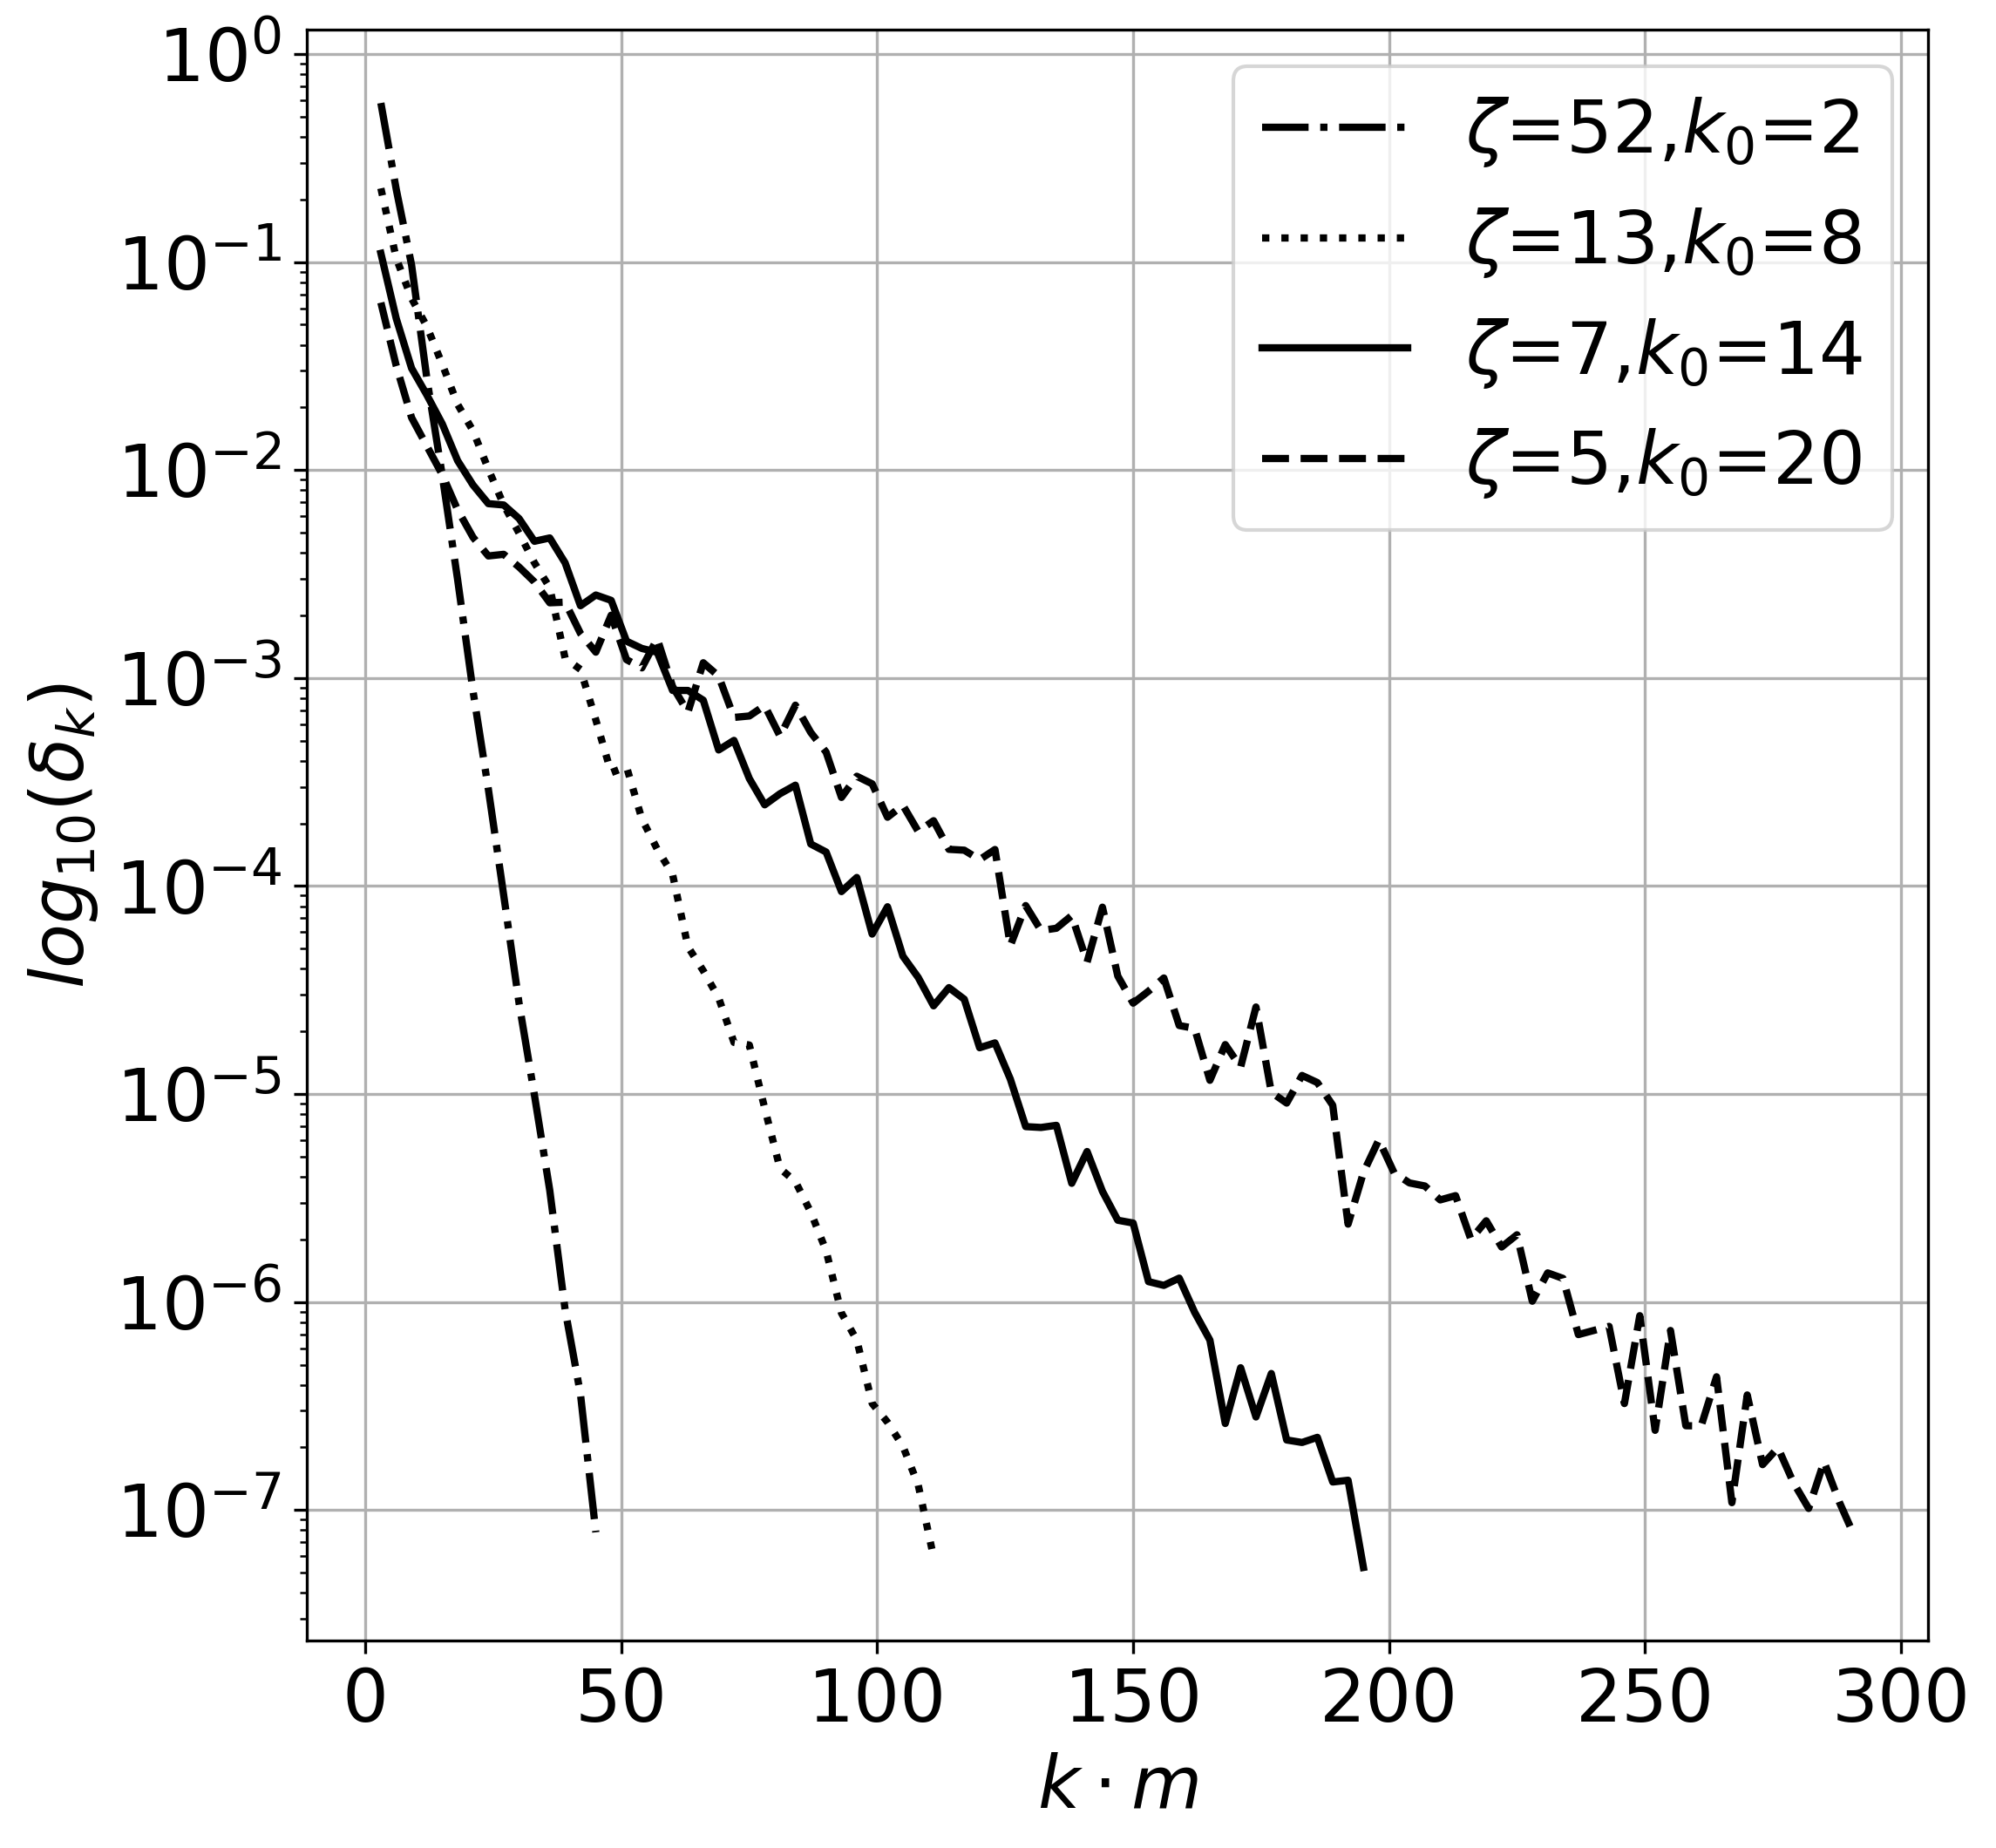

In [146]:
# Задаём список стилей линий (их можно расширять или менять)
linestyles = [
    '-.', ':', '-', '--', 
    (0, (1, 10)),  # чередование коротких штрихов и длинных пробелов
    (0, (5, 5)),   # равномерные штрихи
    (0, (3, 1, 1, 1)),  # комплексное чередование
    (0, (1, 3)),   # штрихи с большим пробелом
    (0, (3, 5, 1, 5)),
    (0, (3, 5, 1, 3))
]

# Список маркеров. Если маркеры не нужны, их можно не указывать, оставив только стили линий.
#markers = ['o', 's', '^', '*', 'D', 'v', '<', '>', 'p', 'h']

plt.figure(figsize=(8,8), dpi=300)
for num, k_wave in enumerate(k_array[::3]):
    zeta = int(2*np.pi*n_1/l_1/k_wave)    # Количество точек на длину волны
    plt.plot(iters_array_T[3*num], 
             eps_array_T[3*num], 
             label=r"$\zeta$="+f"{zeta}"+r",$k_0$" +f"={int(k_wave)}",
             c="black", 
             linestyle=linestyles[num],        # Для каждой линии свой стиль
#             marker=markers[num],
             linewidth=2)

plt.yscale('log')
plt.legend(fontsize = 20)
plt.ylabel(r'$log_{10}(\delta_k)$', fontsize=20)
plt.xlabel(r'$k\cdot m$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

In [149]:
np.array([x[-1] for x in iters_array_T])

array([ 45, 111, 195, 291, 300, 300, 300, 300, 300, 300])

In [150]:
np.array([x[-1] for x in resid_array_T])

array([9.80112949e-12, 2.27999877e-11, 9.61088934e-11, 2.38865651e-10,
       1.57031508e-07, 6.89929409e-06, 6.16823033e-05, 1.90578032e-04,
       3.16038506e-04, 3.70715019e-04])

In [151]:
elapsed_array_T

[6.362462500001129,
 15.50725230000171,
 27.063235700003133,
 40.06613099999959,
 41.41066109999883,
 41.28737949999777,
 41.556213200001366,
 41.22896010000113,
 41.43955619999906,
 41.4232058000016]

In [152]:
np.array([x[-1] for x in eps_array_T])

array([7.81703777e-08, 5.94518673e-08, 5.29658049e-08, 7.43701459e-08,
       4.58868680e-07, 3.79145793e-06, 1.31274917e-05, 2.60934023e-05,
       3.43218129e-05, 3.05420016e-05])

C:\Users\user\AppData\Local\Temp\ipykernel_11980\3755245352.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


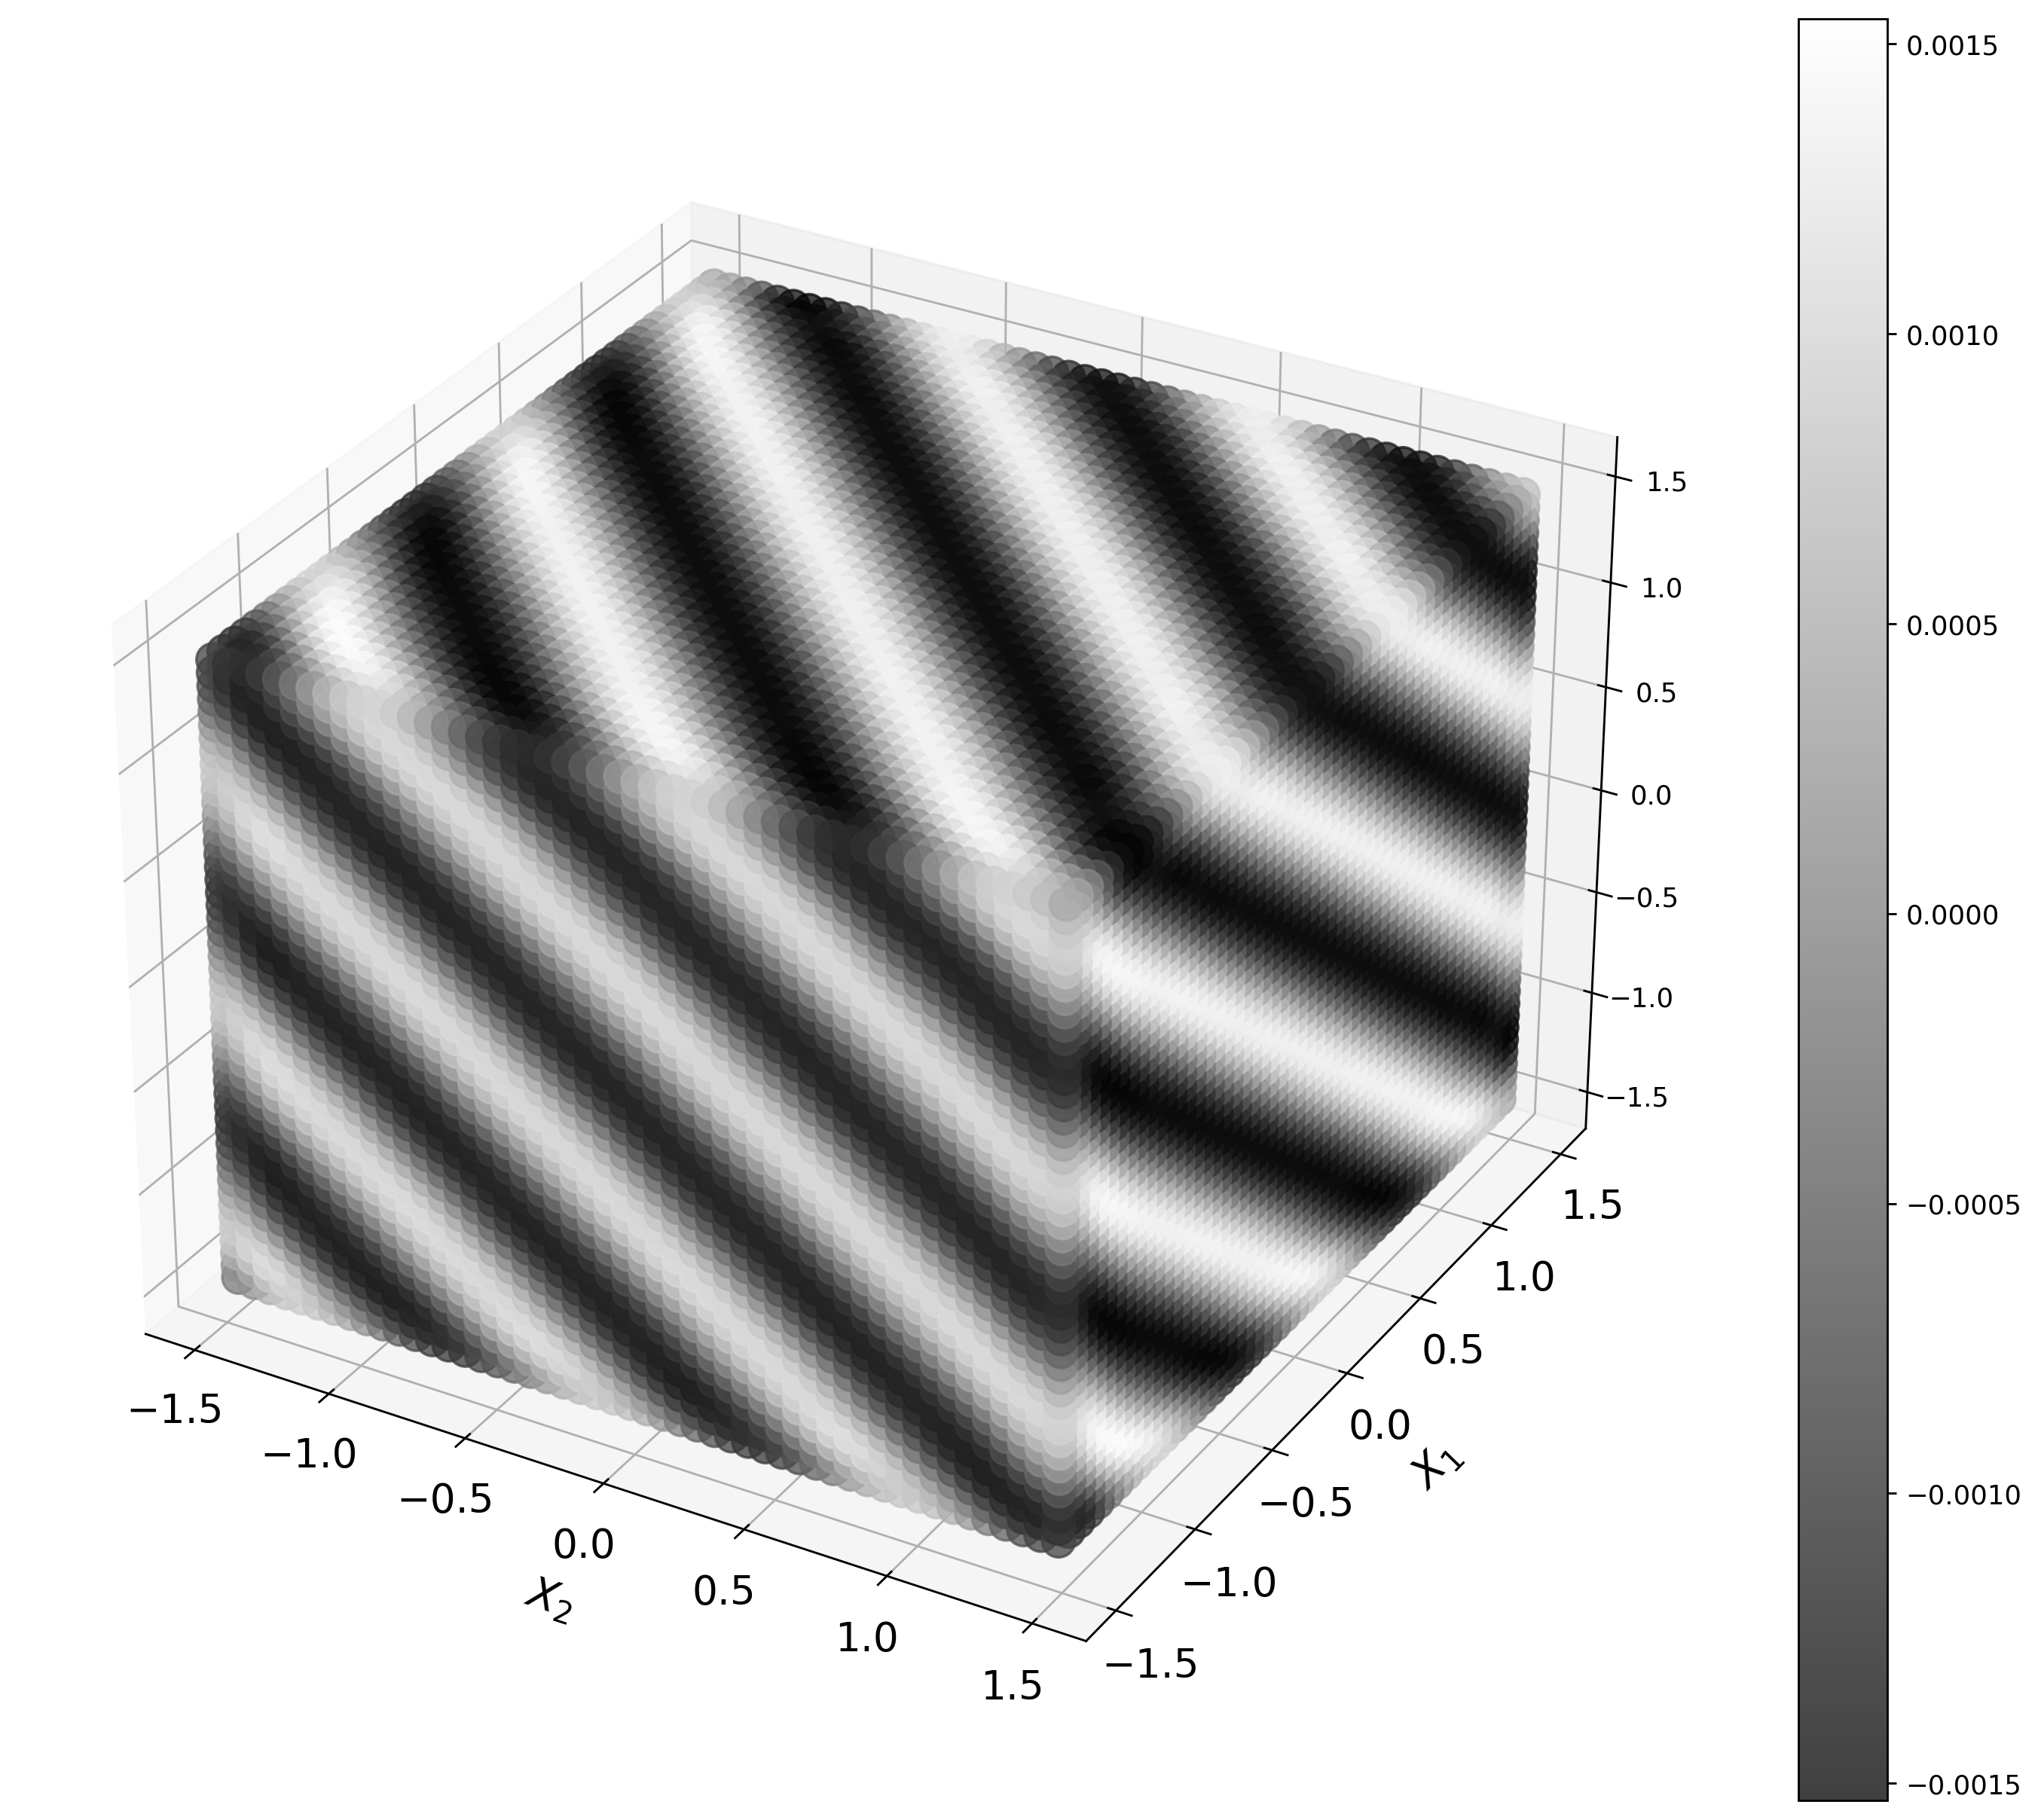

In [153]:
plot_cube_scatter3d(vector_U = result_TS.real, cubes_collocations=grid,
                        figsize_opt=(14, 12),
                        cmap_opt="gray",
                        marker_size_opt=150,
                        alpha_opt=0.75,
                        title_opt="",
                        xlabel_opt=r"$X_2$",
                        ylabel_opt=r"$X_1$",
                        filename_opt="painting_scalar_T.png")